In [26]:
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
X = np.random.normal(0,1,(5000))

In [28]:
min(X), max(X)

(-3.8977512704093207, 3.7578329144718188)

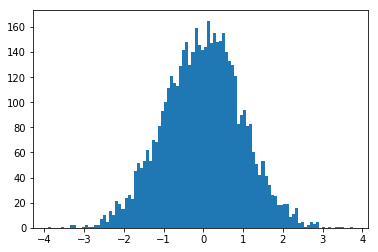

In [29]:
plt.hist(X,100);

In [30]:
X_noise = np.random.random((20000,100))

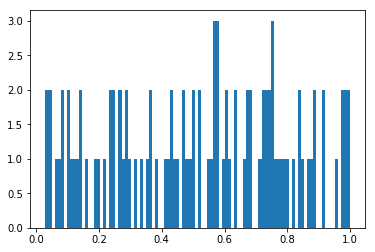

In [31]:
plt.hist(X_noise[0,:],100);

#### Generador

In [32]:
#se crea el modelo secuencial el cual hará las veces de generador de ruido
model = Sequential()
model.add(Dense(256, input_shape=(100,)))
model.add(LeakyReLU(alpha=0.2)) #función rectificadora
model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1, activation='tanh'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

In [33]:
#model.summary()
#batch = 640
#gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
syntetic_dist = model.predict(X_noise)
print("Datos: ",syntetic_dist.shape)

Datos:  (20000, 1)


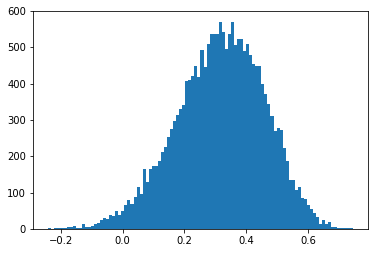

In [34]:
plt.hist(syntetic_dist,100);

### - GANs

In [35]:
batch = 64
random_index = np.random.randint(0, len(X) - np.int64(batch/2))
legit_data = X[random_index:random_index + np.int64(batch/2)]

In [36]:
X_noise = np.random.random((20000, 100))

In [37]:
X_noise.shape

(20000, 100)

In [45]:
np.random.normal(0,1,((np.int64(100/2), 100))).shape

(50, 100)

In [60]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self):
        self.SHAPE = (1,1)
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        #print("Compilando el generador...")
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        #print("Compilando el discriminador...")
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(100, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(50))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(50))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))
        return model

    #Discriminador del modelo
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense(100, input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(50))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs, batch):
        ## train discriminator
        data_gen = [] #datos generados
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X) - np.int64(batch/2))
            legit_data = X[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),1,1)
            
            #X_noise = np.random.random((20000,100))
            #X_noise = np.random.normal(0,1,((np.int64(batch/2), 100)))
            X_noise = np.random.random((np.int64(batch/2), 100))
            #print(gen_noise.shape)
            syntetic_data = self.G.predict(X_noise)
            syntetic_data = syntetic_data.reshape(syntetic_data.shape[0],1,1)
            #print("data original: ", legit_data.shape," data generada: ",syntetic_data.shape)
            x_combined_batch = np.concatenate((legit_data, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)),
                                               np.zeros((np.int64(batch/2), 1))))
            #print("X combinado: ", x_combined_batch.shape, " Y combinado: ", y_combined_batch.shape)

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)
            
            # train generator
            noise = np.random.random((batch, 100))
            #noise = np.random.normal(0,1,(batch, 100))
            
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
            data_gen.append(syntetic_data)
            
        return data_gen

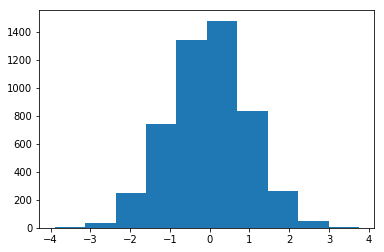

In [61]:
plt.hist(np.ravel(X));

In [62]:
X_train = X.reshape((X.shape[0], 1,1))

print(X_train.shape)
gan = GANs()
l_img = gan.train(X_train,epochs=20000,batch=100)

(5000, 1, 1)


/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.693868], [ Generator :: loss: 0.718361]
epoch: 1, [Discriminator :: d_loss: 0.689633], [ Generator :: loss: 0.717172]
epoch: 2, [Discriminator :: d_loss: 0.695383], [ Generator :: loss: 0.718647]
epoch: 3, [Discriminator :: d_loss: 0.691279], [ Generator :: loss: 0.714719]
epoch: 4, [Discriminator :: d_loss: 0.707632], [ Generator :: loss: 0.713927]
epoch: 5, [Discriminator :: d_loss: 0.699547], [ Generator :: loss: 0.715069]
epoch: 6, [Discriminator :: d_loss: 0.690995], [ Generator :: loss: 0.716386]
epoch: 7, [Discriminator :: d_loss: 0.696603], [ Generator :: loss: 0.713697]
epoch: 8, [Discriminator :: d_loss: 0.694587], [ Generator :: loss: 0.713669]
epoch: 9, [Discriminator :: d_loss: 0.696109], [ Generator :: loss: 0.711231]
epoch: 10, [Discriminator :: d_loss: 0.710606], [ Generator :: loss: 0.709276]
epoch: 11, [Discriminator :: d_loss: 0.692393], [ Generator :: loss: 0.706108]
epoch: 12, [Discriminator :: d_loss: 0.696717], [ Generator ::

epoch: 114, [Discriminator :: d_loss: 0.693664], [ Generator :: loss: 0.681347]
epoch: 115, [Discriminator :: d_loss: 0.687565], [ Generator :: loss: 0.681238]
epoch: 116, [Discriminator :: d_loss: 0.689627], [ Generator :: loss: 0.678913]
epoch: 117, [Discriminator :: d_loss: 0.680464], [ Generator :: loss: 0.681362]
epoch: 118, [Discriminator :: d_loss: 0.693631], [ Generator :: loss: 0.678889]
epoch: 119, [Discriminator :: d_loss: 0.691500], [ Generator :: loss: 0.676955]
epoch: 120, [Discriminator :: d_loss: 0.690578], [ Generator :: loss: 0.678227]
epoch: 121, [Discriminator :: d_loss: 0.691831], [ Generator :: loss: 0.678092]
epoch: 122, [Discriminator :: d_loss: 0.688848], [ Generator :: loss: 0.677507]
epoch: 123, [Discriminator :: d_loss: 0.690543], [ Generator :: loss: 0.675236]
epoch: 124, [Discriminator :: d_loss: 0.690929], [ Generator :: loss: 0.677253]
epoch: 125, [Discriminator :: d_loss: 0.686600], [ Generator :: loss: 0.677781]
epoch: 126, [Discriminator :: d_loss: 0.

epoch: 225, [Discriminator :: d_loss: 0.692254], [ Generator :: loss: 0.692568]
epoch: 226, [Discriminator :: d_loss: 0.692151], [ Generator :: loss: 0.693342]
epoch: 227, [Discriminator :: d_loss: 0.695540], [ Generator :: loss: 0.693347]
epoch: 228, [Discriminator :: d_loss: 0.691165], [ Generator :: loss: 0.695500]
epoch: 229, [Discriminator :: d_loss: 0.689592], [ Generator :: loss: 0.694180]
epoch: 230, [Discriminator :: d_loss: 0.698365], [ Generator :: loss: 0.697026]
epoch: 231, [Discriminator :: d_loss: 0.693387], [ Generator :: loss: 0.697267]
epoch: 232, [Discriminator :: d_loss: 0.691013], [ Generator :: loss: 0.697022]
epoch: 233, [Discriminator :: d_loss: 0.691786], [ Generator :: loss: 0.697355]
epoch: 234, [Discriminator :: d_loss: 0.691316], [ Generator :: loss: 0.697768]
epoch: 235, [Discriminator :: d_loss: 0.692445], [ Generator :: loss: 0.697434]
epoch: 236, [Discriminator :: d_loss: 0.691126], [ Generator :: loss: 0.699315]
epoch: 237, [Discriminator :: d_loss: 0.

epoch: 339, [Discriminator :: d_loss: 0.689401], [ Generator :: loss: 0.706798]
epoch: 340, [Discriminator :: d_loss: 0.689547], [ Generator :: loss: 0.706291]
epoch: 341, [Discriminator :: d_loss: 0.689035], [ Generator :: loss: 0.707132]
epoch: 342, [Discriminator :: d_loss: 0.690228], [ Generator :: loss: 0.707948]
epoch: 343, [Discriminator :: d_loss: 0.688998], [ Generator :: loss: 0.706695]
epoch: 344, [Discriminator :: d_loss: 0.688659], [ Generator :: loss: 0.706482]
epoch: 345, [Discriminator :: d_loss: 0.689293], [ Generator :: loss: 0.706769]
epoch: 346, [Discriminator :: d_loss: 0.685969], [ Generator :: loss: 0.706322]
epoch: 347, [Discriminator :: d_loss: 0.690016], [ Generator :: loss: 0.706380]
epoch: 348, [Discriminator :: d_loss: 0.687956], [ Generator :: loss: 0.706709]
epoch: 349, [Discriminator :: d_loss: 0.688085], [ Generator :: loss: 0.706501]
epoch: 350, [Discriminator :: d_loss: 0.689080], [ Generator :: loss: 0.707452]
epoch: 351, [Discriminator :: d_loss: 0.

epoch: 453, [Discriminator :: d_loss: 0.685860], [ Generator :: loss: 0.698156]
epoch: 454, [Discriminator :: d_loss: 0.686081], [ Generator :: loss: 0.697629]
epoch: 455, [Discriminator :: d_loss: 0.684789], [ Generator :: loss: 0.696633]
epoch: 456, [Discriminator :: d_loss: 0.687962], [ Generator :: loss: 0.696436]
epoch: 457, [Discriminator :: d_loss: 0.684133], [ Generator :: loss: 0.698134]
epoch: 458, [Discriminator :: d_loss: 0.685494], [ Generator :: loss: 0.697032]
epoch: 459, [Discriminator :: d_loss: 0.689138], [ Generator :: loss: 0.698976]
epoch: 460, [Discriminator :: d_loss: 0.687431], [ Generator :: loss: 0.698763]
epoch: 461, [Discriminator :: d_loss: 0.689420], [ Generator :: loss: 0.698902]
epoch: 462, [Discriminator :: d_loss: 0.687476], [ Generator :: loss: 0.697172]
epoch: 463, [Discriminator :: d_loss: 0.687071], [ Generator :: loss: 0.698658]
epoch: 464, [Discriminator :: d_loss: 0.685465], [ Generator :: loss: 0.697688]
epoch: 465, [Discriminator :: d_loss: 0.

epoch: 566, [Discriminator :: d_loss: 0.681154], [ Generator :: loss: 0.693808]
epoch: 567, [Discriminator :: d_loss: 0.685751], [ Generator :: loss: 0.692198]
epoch: 568, [Discriminator :: d_loss: 0.684048], [ Generator :: loss: 0.691964]
epoch: 569, [Discriminator :: d_loss: 0.676955], [ Generator :: loss: 0.692197]
epoch: 570, [Discriminator :: d_loss: 0.683306], [ Generator :: loss: 0.692271]
epoch: 571, [Discriminator :: d_loss: 0.681162], [ Generator :: loss: 0.691624]
epoch: 572, [Discriminator :: d_loss: 0.683434], [ Generator :: loss: 0.692750]
epoch: 573, [Discriminator :: d_loss: 0.682472], [ Generator :: loss: 0.691958]
epoch: 574, [Discriminator :: d_loss: 0.682297], [ Generator :: loss: 0.692433]
epoch: 575, [Discriminator :: d_loss: 0.682543], [ Generator :: loss: 0.691998]
epoch: 576, [Discriminator :: d_loss: 0.684550], [ Generator :: loss: 0.692031]
epoch: 577, [Discriminator :: d_loss: 0.682294], [ Generator :: loss: 0.692138]
epoch: 578, [Discriminator :: d_loss: 0.

epoch: 679, [Discriminator :: d_loss: 0.678005], [ Generator :: loss: 0.701594]
epoch: 680, [Discriminator :: d_loss: 0.676655], [ Generator :: loss: 0.701631]
epoch: 681, [Discriminator :: d_loss: 0.678031], [ Generator :: loss: 0.701881]
epoch: 682, [Discriminator :: d_loss: 0.678107], [ Generator :: loss: 0.701873]
epoch: 683, [Discriminator :: d_loss: 0.675349], [ Generator :: loss: 0.701065]
epoch: 684, [Discriminator :: d_loss: 0.683101], [ Generator :: loss: 0.702018]
epoch: 685, [Discriminator :: d_loss: 0.674338], [ Generator :: loss: 0.701799]
epoch: 686, [Discriminator :: d_loss: 0.677054], [ Generator :: loss: 0.700971]
epoch: 687, [Discriminator :: d_loss: 0.680378], [ Generator :: loss: 0.701584]
epoch: 688, [Discriminator :: d_loss: 0.677801], [ Generator :: loss: 0.702439]
epoch: 689, [Discriminator :: d_loss: 0.672017], [ Generator :: loss: 0.703601]
epoch: 690, [Discriminator :: d_loss: 0.676703], [ Generator :: loss: 0.703178]
epoch: 691, [Discriminator :: d_loss: 0.

epoch: 793, [Discriminator :: d_loss: 0.678566], [ Generator :: loss: 0.710269]
epoch: 794, [Discriminator :: d_loss: 0.679362], [ Generator :: loss: 0.709664]
epoch: 795, [Discriminator :: d_loss: 0.669063], [ Generator :: loss: 0.709681]
epoch: 796, [Discriminator :: d_loss: 0.666555], [ Generator :: loss: 0.708343]
epoch: 797, [Discriminator :: d_loss: 0.663366], [ Generator :: loss: 0.708286]
epoch: 798, [Discriminator :: d_loss: 0.666437], [ Generator :: loss: 0.710012]
epoch: 799, [Discriminator :: d_loss: 0.671147], [ Generator :: loss: 0.708856]
epoch: 800, [Discriminator :: d_loss: 0.679636], [ Generator :: loss: 0.707151]
epoch: 801, [Discriminator :: d_loss: 0.663725], [ Generator :: loss: 0.707499]
epoch: 802, [Discriminator :: d_loss: 0.678913], [ Generator :: loss: 0.709740]
epoch: 803, [Discriminator :: d_loss: 0.663942], [ Generator :: loss: 0.709493]
epoch: 804, [Discriminator :: d_loss: 0.659864], [ Generator :: loss: 0.708634]
epoch: 805, [Discriminator :: d_loss: 0.

epoch: 907, [Discriminator :: d_loss: 0.664612], [ Generator :: loss: 0.717161]
epoch: 908, [Discriminator :: d_loss: 0.663812], [ Generator :: loss: 0.719404]
epoch: 909, [Discriminator :: d_loss: 0.675886], [ Generator :: loss: 0.718468]
epoch: 910, [Discriminator :: d_loss: 0.663418], [ Generator :: loss: 0.720685]
epoch: 911, [Discriminator :: d_loss: 0.672404], [ Generator :: loss: 0.719638]
epoch: 912, [Discriminator :: d_loss: 0.659322], [ Generator :: loss: 0.719926]
epoch: 913, [Discriminator :: d_loss: 0.674955], [ Generator :: loss: 0.718877]
epoch: 914, [Discriminator :: d_loss: 0.666321], [ Generator :: loss: 0.720505]
epoch: 915, [Discriminator :: d_loss: 0.672753], [ Generator :: loss: 0.716851]
epoch: 916, [Discriminator :: d_loss: 0.668980], [ Generator :: loss: 0.718482]
epoch: 917, [Discriminator :: d_loss: 0.657445], [ Generator :: loss: 0.720981]
epoch: 918, [Discriminator :: d_loss: 0.669255], [ Generator :: loss: 0.721535]
epoch: 919, [Discriminator :: d_loss: 0.

epoch: 1021, [Discriminator :: d_loss: 0.673208], [ Generator :: loss: 0.722497]
epoch: 1022, [Discriminator :: d_loss: 0.664585], [ Generator :: loss: 0.725394]
epoch: 1023, [Discriminator :: d_loss: 0.649579], [ Generator :: loss: 0.727431]
epoch: 1024, [Discriminator :: d_loss: 0.649219], [ Generator :: loss: 0.727657]
epoch: 1025, [Discriminator :: d_loss: 0.651469], [ Generator :: loss: 0.726981]
epoch: 1026, [Discriminator :: d_loss: 0.664603], [ Generator :: loss: 0.727525]
epoch: 1027, [Discriminator :: d_loss: 0.672806], [ Generator :: loss: 0.727062]
epoch: 1028, [Discriminator :: d_loss: 0.646193], [ Generator :: loss: 0.727045]
epoch: 1029, [Discriminator :: d_loss: 0.674766], [ Generator :: loss: 0.728793]
epoch: 1030, [Discriminator :: d_loss: 0.670102], [ Generator :: loss: 0.723340]
epoch: 1031, [Discriminator :: d_loss: 0.671385], [ Generator :: loss: 0.731003]
epoch: 1032, [Discriminator :: d_loss: 0.651636], [ Generator :: loss: 0.732724]
epoch: 1033, [Discriminator 

epoch: 1135, [Discriminator :: d_loss: 0.636325], [ Generator :: loss: 0.736196]
epoch: 1136, [Discriminator :: d_loss: 0.643665], [ Generator :: loss: 0.737712]
epoch: 1137, [Discriminator :: d_loss: 0.664465], [ Generator :: loss: 0.735958]
epoch: 1138, [Discriminator :: d_loss: 0.652842], [ Generator :: loss: 0.732349]
epoch: 1139, [Discriminator :: d_loss: 0.667109], [ Generator :: loss: 0.734083]
epoch: 1140, [Discriminator :: d_loss: 0.656142], [ Generator :: loss: 0.730678]
epoch: 1141, [Discriminator :: d_loss: 0.660518], [ Generator :: loss: 0.732908]
epoch: 1142, [Discriminator :: d_loss: 0.668374], [ Generator :: loss: 0.730080]
epoch: 1143, [Discriminator :: d_loss: 0.636650], [ Generator :: loss: 0.729971]
epoch: 1144, [Discriminator :: d_loss: 0.653461], [ Generator :: loss: 0.733196]
epoch: 1145, [Discriminator :: d_loss: 0.644668], [ Generator :: loss: 0.734937]
epoch: 1146, [Discriminator :: d_loss: 0.638975], [ Generator :: loss: 0.731119]
epoch: 1147, [Discriminator 

epoch: 1249, [Discriminator :: d_loss: 0.631916], [ Generator :: loss: 0.745061]
epoch: 1250, [Discriminator :: d_loss: 0.653569], [ Generator :: loss: 0.750739]
epoch: 1251, [Discriminator :: d_loss: 0.646790], [ Generator :: loss: 0.751354]
epoch: 1252, [Discriminator :: d_loss: 0.632307], [ Generator :: loss: 0.746402]
epoch: 1253, [Discriminator :: d_loss: 0.662876], [ Generator :: loss: 0.750302]
epoch: 1254, [Discriminator :: d_loss: 0.654283], [ Generator :: loss: 0.749577]
epoch: 1255, [Discriminator :: d_loss: 0.627044], [ Generator :: loss: 0.749896]
epoch: 1256, [Discriminator :: d_loss: 0.635839], [ Generator :: loss: 0.754037]
epoch: 1257, [Discriminator :: d_loss: 0.662177], [ Generator :: loss: 0.752385]
epoch: 1258, [Discriminator :: d_loss: 0.638397], [ Generator :: loss: 0.750193]
epoch: 1259, [Discriminator :: d_loss: 0.644870], [ Generator :: loss: 0.749888]
epoch: 1260, [Discriminator :: d_loss: 0.643949], [ Generator :: loss: 0.743862]
epoch: 1261, [Discriminator 

epoch: 1362, [Discriminator :: d_loss: 0.637916], [ Generator :: loss: 0.756487]
epoch: 1363, [Discriminator :: d_loss: 0.673948], [ Generator :: loss: 0.757885]
epoch: 1364, [Discriminator :: d_loss: 0.612389], [ Generator :: loss: 0.756685]
epoch: 1365, [Discriminator :: d_loss: 0.641077], [ Generator :: loss: 0.760319]
epoch: 1366, [Discriminator :: d_loss: 0.618646], [ Generator :: loss: 0.753360]
epoch: 1367, [Discriminator :: d_loss: 0.651399], [ Generator :: loss: 0.762413]
epoch: 1368, [Discriminator :: d_loss: 0.641571], [ Generator :: loss: 0.757203]
epoch: 1369, [Discriminator :: d_loss: 0.636517], [ Generator :: loss: 0.758423]
epoch: 1370, [Discriminator :: d_loss: 0.618375], [ Generator :: loss: 0.763072]
epoch: 1371, [Discriminator :: d_loss: 0.658214], [ Generator :: loss: 0.752083]
epoch: 1372, [Discriminator :: d_loss: 0.642689], [ Generator :: loss: 0.763173]
epoch: 1373, [Discriminator :: d_loss: 0.633315], [ Generator :: loss: 0.754701]
epoch: 1374, [Discriminator 

epoch: 1476, [Discriminator :: d_loss: 0.627390], [ Generator :: loss: 0.766055]
epoch: 1477, [Discriminator :: d_loss: 0.642827], [ Generator :: loss: 0.766012]
epoch: 1478, [Discriminator :: d_loss: 0.654257], [ Generator :: loss: 0.769978]
epoch: 1479, [Discriminator :: d_loss: 0.635787], [ Generator :: loss: 0.769986]
epoch: 1480, [Discriminator :: d_loss: 0.668321], [ Generator :: loss: 0.770589]
epoch: 1481, [Discriminator :: d_loss: 0.656162], [ Generator :: loss: 0.764910]
epoch: 1482, [Discriminator :: d_loss: 0.631873], [ Generator :: loss: 0.762277]
epoch: 1483, [Discriminator :: d_loss: 0.613616], [ Generator :: loss: 0.762175]
epoch: 1484, [Discriminator :: d_loss: 0.639708], [ Generator :: loss: 0.770760]
epoch: 1485, [Discriminator :: d_loss: 0.633409], [ Generator :: loss: 0.767481]
epoch: 1486, [Discriminator :: d_loss: 0.589832], [ Generator :: loss: 0.764229]
epoch: 1487, [Discriminator :: d_loss: 0.618502], [ Generator :: loss: 0.771931]
epoch: 1488, [Discriminator 

epoch: 1590, [Discriminator :: d_loss: 0.629123], [ Generator :: loss: 0.767646]
epoch: 1591, [Discriminator :: d_loss: 0.632084], [ Generator :: loss: 0.762021]
epoch: 1592, [Discriminator :: d_loss: 0.631656], [ Generator :: loss: 0.761987]
epoch: 1593, [Discriminator :: d_loss: 0.608776], [ Generator :: loss: 0.772414]
epoch: 1594, [Discriminator :: d_loss: 0.624184], [ Generator :: loss: 0.769541]
epoch: 1595, [Discriminator :: d_loss: 0.642612], [ Generator :: loss: 0.769969]
epoch: 1596, [Discriminator :: d_loss: 0.624384], [ Generator :: loss: 0.767588]
epoch: 1597, [Discriminator :: d_loss: 0.612908], [ Generator :: loss: 0.769168]
epoch: 1598, [Discriminator :: d_loss: 0.659458], [ Generator :: loss: 0.767635]
epoch: 1599, [Discriminator :: d_loss: 0.639305], [ Generator :: loss: 0.784390]
epoch: 1600, [Discriminator :: d_loss: 0.617026], [ Generator :: loss: 0.761298]
epoch: 1601, [Discriminator :: d_loss: 0.633358], [ Generator :: loss: 0.770010]
epoch: 1602, [Discriminator 

epoch: 1704, [Discriminator :: d_loss: 0.604201], [ Generator :: loss: 0.785778]
epoch: 1705, [Discriminator :: d_loss: 0.653901], [ Generator :: loss: 0.775339]
epoch: 1706, [Discriminator :: d_loss: 0.627912], [ Generator :: loss: 0.785232]
epoch: 1707, [Discriminator :: d_loss: 0.637159], [ Generator :: loss: 0.779186]
epoch: 1708, [Discriminator :: d_loss: 0.655078], [ Generator :: loss: 0.785171]
epoch: 1709, [Discriminator :: d_loss: 0.641992], [ Generator :: loss: 0.783529]
epoch: 1710, [Discriminator :: d_loss: 0.611676], [ Generator :: loss: 0.779060]
epoch: 1711, [Discriminator :: d_loss: 0.632821], [ Generator :: loss: 0.783074]
epoch: 1712, [Discriminator :: d_loss: 0.644471], [ Generator :: loss: 0.787021]
epoch: 1713, [Discriminator :: d_loss: 0.625130], [ Generator :: loss: 0.786273]
epoch: 1714, [Discriminator :: d_loss: 0.616823], [ Generator :: loss: 0.791655]
epoch: 1715, [Discriminator :: d_loss: 0.595583], [ Generator :: loss: 0.784114]
epoch: 1716, [Discriminator 

epoch: 1818, [Discriminator :: d_loss: 0.627426], [ Generator :: loss: 0.773169]
epoch: 1819, [Discriminator :: d_loss: 0.639492], [ Generator :: loss: 0.772524]
epoch: 1820, [Discriminator :: d_loss: 0.625308], [ Generator :: loss: 0.772043]
epoch: 1821, [Discriminator :: d_loss: 0.653070], [ Generator :: loss: 0.777377]
epoch: 1822, [Discriminator :: d_loss: 0.642985], [ Generator :: loss: 0.774583]
epoch: 1823, [Discriminator :: d_loss: 0.629799], [ Generator :: loss: 0.774922]
epoch: 1824, [Discriminator :: d_loss: 0.623271], [ Generator :: loss: 0.766500]
epoch: 1825, [Discriminator :: d_loss: 0.644404], [ Generator :: loss: 0.778920]
epoch: 1826, [Discriminator :: d_loss: 0.618257], [ Generator :: loss: 0.770731]
epoch: 1827, [Discriminator :: d_loss: 0.643428], [ Generator :: loss: 0.783486]
epoch: 1828, [Discriminator :: d_loss: 0.625141], [ Generator :: loss: 0.784405]
epoch: 1829, [Discriminator :: d_loss: 0.630774], [ Generator :: loss: 0.772346]
epoch: 1830, [Discriminator 

epoch: 1932, [Discriminator :: d_loss: 0.589867], [ Generator :: loss: 0.796584]
epoch: 1933, [Discriminator :: d_loss: 0.585319], [ Generator :: loss: 0.793897]
epoch: 1934, [Discriminator :: d_loss: 0.643501], [ Generator :: loss: 0.784982]
epoch: 1935, [Discriminator :: d_loss: 0.605833], [ Generator :: loss: 0.784269]
epoch: 1936, [Discriminator :: d_loss: 0.602201], [ Generator :: loss: 0.795911]
epoch: 1937, [Discriminator :: d_loss: 0.630998], [ Generator :: loss: 0.788282]
epoch: 1938, [Discriminator :: d_loss: 0.615721], [ Generator :: loss: 0.798063]
epoch: 1939, [Discriminator :: d_loss: 0.604227], [ Generator :: loss: 0.789094]
epoch: 1940, [Discriminator :: d_loss: 0.610438], [ Generator :: loss: 0.793642]
epoch: 1941, [Discriminator :: d_loss: 0.616401], [ Generator :: loss: 0.791657]
epoch: 1942, [Discriminator :: d_loss: 0.579363], [ Generator :: loss: 0.790517]
epoch: 1943, [Discriminator :: d_loss: 0.671545], [ Generator :: loss: 0.796309]
epoch: 1944, [Discriminator 

epoch: 2046, [Discriminator :: d_loss: 0.581701], [ Generator :: loss: 0.809955]
epoch: 2047, [Discriminator :: d_loss: 0.600743], [ Generator :: loss: 0.813237]
epoch: 2048, [Discriminator :: d_loss: 0.639938], [ Generator :: loss: 0.803940]
epoch: 2049, [Discriminator :: d_loss: 0.606243], [ Generator :: loss: 0.808707]
epoch: 2050, [Discriminator :: d_loss: 0.625820], [ Generator :: loss: 0.798319]
epoch: 2051, [Discriminator :: d_loss: 0.596194], [ Generator :: loss: 0.803119]
epoch: 2052, [Discriminator :: d_loss: 0.633831], [ Generator :: loss: 0.802106]
epoch: 2053, [Discriminator :: d_loss: 0.607995], [ Generator :: loss: 0.800185]
epoch: 2054, [Discriminator :: d_loss: 0.612377], [ Generator :: loss: 0.812701]
epoch: 2055, [Discriminator :: d_loss: 0.602848], [ Generator :: loss: 0.818371]
epoch: 2056, [Discriminator :: d_loss: 0.613476], [ Generator :: loss: 0.809138]
epoch: 2057, [Discriminator :: d_loss: 0.656307], [ Generator :: loss: 0.807465]
epoch: 2058, [Discriminator 

epoch: 2160, [Discriminator :: d_loss: 0.612370], [ Generator :: loss: 0.825800]
epoch: 2161, [Discriminator :: d_loss: 0.644666], [ Generator :: loss: 0.816099]
epoch: 2162, [Discriminator :: d_loss: 0.642246], [ Generator :: loss: 0.820953]
epoch: 2163, [Discriminator :: d_loss: 0.604499], [ Generator :: loss: 0.825110]
epoch: 2164, [Discriminator :: d_loss: 0.609171], [ Generator :: loss: 0.809487]
epoch: 2165, [Discriminator :: d_loss: 0.628759], [ Generator :: loss: 0.827760]
epoch: 2166, [Discriminator :: d_loss: 0.615263], [ Generator :: loss: 0.810692]
epoch: 2167, [Discriminator :: d_loss: 0.628157], [ Generator :: loss: 0.817271]
epoch: 2168, [Discriminator :: d_loss: 0.600365], [ Generator :: loss: 0.802632]
epoch: 2169, [Discriminator :: d_loss: 0.603012], [ Generator :: loss: 0.806339]
epoch: 2170, [Discriminator :: d_loss: 0.602488], [ Generator :: loss: 0.805487]
epoch: 2171, [Discriminator :: d_loss: 0.625573], [ Generator :: loss: 0.811050]
epoch: 2172, [Discriminator 

epoch: 2273, [Discriminator :: d_loss: 0.616948], [ Generator :: loss: 0.810209]
epoch: 2274, [Discriminator :: d_loss: 0.613577], [ Generator :: loss: 0.816327]
epoch: 2275, [Discriminator :: d_loss: 0.606325], [ Generator :: loss: 0.815045]
epoch: 2276, [Discriminator :: d_loss: 0.619733], [ Generator :: loss: 0.810324]
epoch: 2277, [Discriminator :: d_loss: 0.600898], [ Generator :: loss: 0.813561]
epoch: 2278, [Discriminator :: d_loss: 0.655295], [ Generator :: loss: 0.800220]
epoch: 2279, [Discriminator :: d_loss: 0.592767], [ Generator :: loss: 0.807892]
epoch: 2280, [Discriminator :: d_loss: 0.635813], [ Generator :: loss: 0.813718]
epoch: 2281, [Discriminator :: d_loss: 0.557594], [ Generator :: loss: 0.808044]
epoch: 2282, [Discriminator :: d_loss: 0.616409], [ Generator :: loss: 0.811041]
epoch: 2283, [Discriminator :: d_loss: 0.636902], [ Generator :: loss: 0.806152]
epoch: 2284, [Discriminator :: d_loss: 0.579896], [ Generator :: loss: 0.815993]
epoch: 2285, [Discriminator 

epoch: 2387, [Discriminator :: d_loss: 0.595909], [ Generator :: loss: 0.838529]
epoch: 2388, [Discriminator :: d_loss: 0.586775], [ Generator :: loss: 0.825269]
epoch: 2389, [Discriminator :: d_loss: 0.626786], [ Generator :: loss: 0.838148]
epoch: 2390, [Discriminator :: d_loss: 0.650801], [ Generator :: loss: 0.847516]
epoch: 2391, [Discriminator :: d_loss: 0.645113], [ Generator :: loss: 0.820559]
epoch: 2392, [Discriminator :: d_loss: 0.620243], [ Generator :: loss: 0.837036]
epoch: 2393, [Discriminator :: d_loss: 0.589101], [ Generator :: loss: 0.834581]
epoch: 2394, [Discriminator :: d_loss: 0.625651], [ Generator :: loss: 0.839722]
epoch: 2395, [Discriminator :: d_loss: 0.616152], [ Generator :: loss: 0.844453]
epoch: 2396, [Discriminator :: d_loss: 0.591761], [ Generator :: loss: 0.845353]
epoch: 2397, [Discriminator :: d_loss: 0.610998], [ Generator :: loss: 0.831842]
epoch: 2398, [Discriminator :: d_loss: 0.627531], [ Generator :: loss: 0.835250]
epoch: 2399, [Discriminator 

epoch: 2501, [Discriminator :: d_loss: 0.604625], [ Generator :: loss: 0.814477]
epoch: 2502, [Discriminator :: d_loss: 0.596279], [ Generator :: loss: 0.805464]
epoch: 2503, [Discriminator :: d_loss: 0.598317], [ Generator :: loss: 0.802237]
epoch: 2504, [Discriminator :: d_loss: 0.609051], [ Generator :: loss: 0.821992]
epoch: 2505, [Discriminator :: d_loss: 0.638391], [ Generator :: loss: 0.818987]
epoch: 2506, [Discriminator :: d_loss: 0.587221], [ Generator :: loss: 0.815554]
epoch: 2507, [Discriminator :: d_loss: 0.613711], [ Generator :: loss: 0.828546]
epoch: 2508, [Discriminator :: d_loss: 0.638350], [ Generator :: loss: 0.812602]
epoch: 2509, [Discriminator :: d_loss: 0.642445], [ Generator :: loss: 0.818897]
epoch: 2510, [Discriminator :: d_loss: 0.635804], [ Generator :: loss: 0.802669]
epoch: 2511, [Discriminator :: d_loss: 0.585760], [ Generator :: loss: 0.823828]
epoch: 2512, [Discriminator :: d_loss: 0.623433], [ Generator :: loss: 0.811247]
epoch: 2513, [Discriminator 

epoch: 2615, [Discriminator :: d_loss: 0.659173], [ Generator :: loss: 0.824065]
epoch: 2616, [Discriminator :: d_loss: 0.634470], [ Generator :: loss: 0.826281]
epoch: 2617, [Discriminator :: d_loss: 0.608372], [ Generator :: loss: 0.812968]
epoch: 2618, [Discriminator :: d_loss: 0.617864], [ Generator :: loss: 0.824265]
epoch: 2619, [Discriminator :: d_loss: 0.634324], [ Generator :: loss: 0.836699]
epoch: 2620, [Discriminator :: d_loss: 0.589793], [ Generator :: loss: 0.828199]
epoch: 2621, [Discriminator :: d_loss: 0.618453], [ Generator :: loss: 0.822975]
epoch: 2622, [Discriminator :: d_loss: 0.582319], [ Generator :: loss: 0.826642]
epoch: 2623, [Discriminator :: d_loss: 0.584749], [ Generator :: loss: 0.840028]
epoch: 2624, [Discriminator :: d_loss: 0.634883], [ Generator :: loss: 0.818708]
epoch: 2625, [Discriminator :: d_loss: 0.609039], [ Generator :: loss: 0.830797]
epoch: 2626, [Discriminator :: d_loss: 0.606640], [ Generator :: loss: 0.821995]
epoch: 2627, [Discriminator 

epoch: 2729, [Discriminator :: d_loss: 0.551341], [ Generator :: loss: 0.831168]
epoch: 2730, [Discriminator :: d_loss: 0.604098], [ Generator :: loss: 0.843737]
epoch: 2731, [Discriminator :: d_loss: 0.625241], [ Generator :: loss: 0.826975]
epoch: 2732, [Discriminator :: d_loss: 0.626785], [ Generator :: loss: 0.831253]
epoch: 2733, [Discriminator :: d_loss: 0.623488], [ Generator :: loss: 0.828882]
epoch: 2734, [Discriminator :: d_loss: 0.609175], [ Generator :: loss: 0.817284]
epoch: 2735, [Discriminator :: d_loss: 0.613165], [ Generator :: loss: 0.832282]
epoch: 2736, [Discriminator :: d_loss: 0.584281], [ Generator :: loss: 0.814644]
epoch: 2737, [Discriminator :: d_loss: 0.594970], [ Generator :: loss: 0.814934]
epoch: 2738, [Discriminator :: d_loss: 0.608663], [ Generator :: loss: 0.828917]
epoch: 2739, [Discriminator :: d_loss: 0.618326], [ Generator :: loss: 0.830142]
epoch: 2740, [Discriminator :: d_loss: 0.646784], [ Generator :: loss: 0.819735]
epoch: 2741, [Discriminator 

epoch: 2843, [Discriminator :: d_loss: 0.602720], [ Generator :: loss: 0.819421]
epoch: 2844, [Discriminator :: d_loss: 0.592035], [ Generator :: loss: 0.820273]
epoch: 2845, [Discriminator :: d_loss: 0.553601], [ Generator :: loss: 0.817532]
epoch: 2846, [Discriminator :: d_loss: 0.626144], [ Generator :: loss: 0.821476]
epoch: 2847, [Discriminator :: d_loss: 0.651286], [ Generator :: loss: 0.817296]
epoch: 2848, [Discriminator :: d_loss: 0.618460], [ Generator :: loss: 0.823608]
epoch: 2849, [Discriminator :: d_loss: 0.615569], [ Generator :: loss: 0.817624]
epoch: 2850, [Discriminator :: d_loss: 0.647678], [ Generator :: loss: 0.829126]
epoch: 2851, [Discriminator :: d_loss: 0.649851], [ Generator :: loss: 0.833032]
epoch: 2852, [Discriminator :: d_loss: 0.599772], [ Generator :: loss: 0.820902]
epoch: 2853, [Discriminator :: d_loss: 0.572172], [ Generator :: loss: 0.823118]
epoch: 2854, [Discriminator :: d_loss: 0.598815], [ Generator :: loss: 0.833198]
epoch: 2855, [Discriminator 

epoch: 2956, [Discriminator :: d_loss: 0.566338], [ Generator :: loss: 0.843065]
epoch: 2957, [Discriminator :: d_loss: 0.642340], [ Generator :: loss: 0.833836]
epoch: 2958, [Discriminator :: d_loss: 0.581403], [ Generator :: loss: 0.833420]
epoch: 2959, [Discriminator :: d_loss: 0.639233], [ Generator :: loss: 0.838216]
epoch: 2960, [Discriminator :: d_loss: 0.628211], [ Generator :: loss: 0.844084]
epoch: 2961, [Discriminator :: d_loss: 0.585595], [ Generator :: loss: 0.838047]
epoch: 2962, [Discriminator :: d_loss: 0.608201], [ Generator :: loss: 0.837715]
epoch: 2963, [Discriminator :: d_loss: 0.577246], [ Generator :: loss: 0.828351]
epoch: 2964, [Discriminator :: d_loss: 0.604788], [ Generator :: loss: 0.818131]
epoch: 2965, [Discriminator :: d_loss: 0.616856], [ Generator :: loss: 0.843994]
epoch: 2966, [Discriminator :: d_loss: 0.624800], [ Generator :: loss: 0.831891]
epoch: 2967, [Discriminator :: d_loss: 0.600964], [ Generator :: loss: 0.845637]
epoch: 2968, [Discriminator 

epoch: 3070, [Discriminator :: d_loss: 0.622293], [ Generator :: loss: 0.834959]
epoch: 3071, [Discriminator :: d_loss: 0.621944], [ Generator :: loss: 0.818999]
epoch: 3072, [Discriminator :: d_loss: 0.596593], [ Generator :: loss: 0.827312]
epoch: 3073, [Discriminator :: d_loss: 0.591810], [ Generator :: loss: 0.818198]
epoch: 3074, [Discriminator :: d_loss: 0.619840], [ Generator :: loss: 0.825078]
epoch: 3075, [Discriminator :: d_loss: 0.603942], [ Generator :: loss: 0.821746]
epoch: 3076, [Discriminator :: d_loss: 0.554800], [ Generator :: loss: 0.849335]
epoch: 3077, [Discriminator :: d_loss: 0.570325], [ Generator :: loss: 0.834593]
epoch: 3078, [Discriminator :: d_loss: 0.603645], [ Generator :: loss: 0.840471]
epoch: 3079, [Discriminator :: d_loss: 0.641919], [ Generator :: loss: 0.848901]
epoch: 3080, [Discriminator :: d_loss: 0.676322], [ Generator :: loss: 0.842950]
epoch: 3081, [Discriminator :: d_loss: 0.564471], [ Generator :: loss: 0.838304]
epoch: 3082, [Discriminator 

epoch: 3184, [Discriminator :: d_loss: 0.580882], [ Generator :: loss: 0.832047]
epoch: 3185, [Discriminator :: d_loss: 0.589662], [ Generator :: loss: 0.829082]
epoch: 3186, [Discriminator :: d_loss: 0.604999], [ Generator :: loss: 0.831816]
epoch: 3187, [Discriminator :: d_loss: 0.615191], [ Generator :: loss: 0.830506]
epoch: 3188, [Discriminator :: d_loss: 0.590761], [ Generator :: loss: 0.829533]
epoch: 3189, [Discriminator :: d_loss: 0.595248], [ Generator :: loss: 0.835338]
epoch: 3190, [Discriminator :: d_loss: 0.602780], [ Generator :: loss: 0.823896]
epoch: 3191, [Discriminator :: d_loss: 0.574135], [ Generator :: loss: 0.826740]
epoch: 3192, [Discriminator :: d_loss: 0.591143], [ Generator :: loss: 0.829039]
epoch: 3193, [Discriminator :: d_loss: 0.583983], [ Generator :: loss: 0.841607]
epoch: 3194, [Discriminator :: d_loss: 0.609813], [ Generator :: loss: 0.832637]
epoch: 3195, [Discriminator :: d_loss: 0.600965], [ Generator :: loss: 0.838705]
epoch: 3196, [Discriminator 

epoch: 3298, [Discriminator :: d_loss: 0.625509], [ Generator :: loss: 0.844619]
epoch: 3299, [Discriminator :: d_loss: 0.585742], [ Generator :: loss: 0.828432]
epoch: 3300, [Discriminator :: d_loss: 0.631321], [ Generator :: loss: 0.824645]
epoch: 3301, [Discriminator :: d_loss: 0.627287], [ Generator :: loss: 0.823892]
epoch: 3302, [Discriminator :: d_loss: 0.588717], [ Generator :: loss: 0.829312]
epoch: 3303, [Discriminator :: d_loss: 0.607964], [ Generator :: loss: 0.818929]
epoch: 3304, [Discriminator :: d_loss: 0.580314], [ Generator :: loss: 0.832125]
epoch: 3305, [Discriminator :: d_loss: 0.600088], [ Generator :: loss: 0.826449]
epoch: 3306, [Discriminator :: d_loss: 0.594502], [ Generator :: loss: 0.826908]
epoch: 3307, [Discriminator :: d_loss: 0.573489], [ Generator :: loss: 0.837312]
epoch: 3308, [Discriminator :: d_loss: 0.577649], [ Generator :: loss: 0.834009]
epoch: 3309, [Discriminator :: d_loss: 0.596513], [ Generator :: loss: 0.833890]
epoch: 3310, [Discriminator 

epoch: 3412, [Discriminator :: d_loss: 0.589658], [ Generator :: loss: 0.823756]
epoch: 3413, [Discriminator :: d_loss: 0.594507], [ Generator :: loss: 0.828825]
epoch: 3414, [Discriminator :: d_loss: 0.606842], [ Generator :: loss: 0.828631]
epoch: 3415, [Discriminator :: d_loss: 0.625440], [ Generator :: loss: 0.830784]
epoch: 3416, [Discriminator :: d_loss: 0.608158], [ Generator :: loss: 0.829078]
epoch: 3417, [Discriminator :: d_loss: 0.589804], [ Generator :: loss: 0.828179]
epoch: 3418, [Discriminator :: d_loss: 0.623359], [ Generator :: loss: 0.824824]
epoch: 3419, [Discriminator :: d_loss: 0.640981], [ Generator :: loss: 0.823219]
epoch: 3420, [Discriminator :: d_loss: 0.617679], [ Generator :: loss: 0.825966]
epoch: 3421, [Discriminator :: d_loss: 0.603822], [ Generator :: loss: 0.833148]
epoch: 3422, [Discriminator :: d_loss: 0.602481], [ Generator :: loss: 0.826272]
epoch: 3423, [Discriminator :: d_loss: 0.594051], [ Generator :: loss: 0.826112]
epoch: 3424, [Discriminator 

epoch: 3526, [Discriminator :: d_loss: 0.569878], [ Generator :: loss: 0.832006]
epoch: 3527, [Discriminator :: d_loss: 0.620797], [ Generator :: loss: 0.840009]
epoch: 3528, [Discriminator :: d_loss: 0.602405], [ Generator :: loss: 0.844073]
epoch: 3529, [Discriminator :: d_loss: 0.590700], [ Generator :: loss: 0.835334]
epoch: 3530, [Discriminator :: d_loss: 0.612013], [ Generator :: loss: 0.832190]
epoch: 3531, [Discriminator :: d_loss: 0.638257], [ Generator :: loss: 0.830151]
epoch: 3532, [Discriminator :: d_loss: 0.591004], [ Generator :: loss: 0.826916]
epoch: 3533, [Discriminator :: d_loss: 0.605992], [ Generator :: loss: 0.835723]
epoch: 3534, [Discriminator :: d_loss: 0.628558], [ Generator :: loss: 0.834099]
epoch: 3535, [Discriminator :: d_loss: 0.639709], [ Generator :: loss: 0.829580]
epoch: 3536, [Discriminator :: d_loss: 0.556364], [ Generator :: loss: 0.827815]
epoch: 3537, [Discriminator :: d_loss: 0.670746], [ Generator :: loss: 0.829935]
epoch: 3538, [Discriminator 

epoch: 3642, [Discriminator :: d_loss: 0.614264], [ Generator :: loss: 0.819760]
epoch: 3643, [Discriminator :: d_loss: 0.572891], [ Generator :: loss: 0.824831]
epoch: 3644, [Discriminator :: d_loss: 0.576565], [ Generator :: loss: 0.832363]
epoch: 3645, [Discriminator :: d_loss: 0.627573], [ Generator :: loss: 0.832324]
epoch: 3646, [Discriminator :: d_loss: 0.569609], [ Generator :: loss: 0.827427]
epoch: 3647, [Discriminator :: d_loss: 0.621934], [ Generator :: loss: 0.832513]
epoch: 3648, [Discriminator :: d_loss: 0.624833], [ Generator :: loss: 0.824195]
epoch: 3649, [Discriminator :: d_loss: 0.612239], [ Generator :: loss: 0.829196]
epoch: 3650, [Discriminator :: d_loss: 0.585411], [ Generator :: loss: 0.832516]
epoch: 3651, [Discriminator :: d_loss: 0.634614], [ Generator :: loss: 0.833420]
epoch: 3652, [Discriminator :: d_loss: 0.612267], [ Generator :: loss: 0.830247]
epoch: 3653, [Discriminator :: d_loss: 0.608744], [ Generator :: loss: 0.830666]
epoch: 3654, [Discriminator 

epoch: 3757, [Discriminator :: d_loss: 0.551328], [ Generator :: loss: 0.835118]
epoch: 3758, [Discriminator :: d_loss: 0.591034], [ Generator :: loss: 0.837799]
epoch: 3759, [Discriminator :: d_loss: 0.593684], [ Generator :: loss: 0.836530]
epoch: 3760, [Discriminator :: d_loss: 0.565723], [ Generator :: loss: 0.837205]
epoch: 3761, [Discriminator :: d_loss: 0.585536], [ Generator :: loss: 0.837822]
epoch: 3762, [Discriminator :: d_loss: 0.626345], [ Generator :: loss: 0.837993]
epoch: 3763, [Discriminator :: d_loss: 0.645162], [ Generator :: loss: 0.837577]
epoch: 3764, [Discriminator :: d_loss: 0.635861], [ Generator :: loss: 0.829274]
epoch: 3765, [Discriminator :: d_loss: 0.647109], [ Generator :: loss: 0.826987]
epoch: 3766, [Discriminator :: d_loss: 0.567477], [ Generator :: loss: 0.831155]
epoch: 3767, [Discriminator :: d_loss: 0.621032], [ Generator :: loss: 0.830200]
epoch: 3768, [Discriminator :: d_loss: 0.555498], [ Generator :: loss: 0.830347]
epoch: 3769, [Discriminator 

epoch: 3870, [Discriminator :: d_loss: 0.574460], [ Generator :: loss: 0.829298]
epoch: 3871, [Discriminator :: d_loss: 0.597715], [ Generator :: loss: 0.828666]
epoch: 3872, [Discriminator :: d_loss: 0.619309], [ Generator :: loss: 0.832531]
epoch: 3873, [Discriminator :: d_loss: 0.559933], [ Generator :: loss: 0.830980]
epoch: 3874, [Discriminator :: d_loss: 0.587763], [ Generator :: loss: 0.834484]
epoch: 3875, [Discriminator :: d_loss: 0.574254], [ Generator :: loss: 0.837404]
epoch: 3876, [Discriminator :: d_loss: 0.607008], [ Generator :: loss: 0.836414]
epoch: 3877, [Discriminator :: d_loss: 0.627528], [ Generator :: loss: 0.836427]
epoch: 3878, [Discriminator :: d_loss: 0.591030], [ Generator :: loss: 0.837487]
epoch: 3879, [Discriminator :: d_loss: 0.623997], [ Generator :: loss: 0.834879]
epoch: 3880, [Discriminator :: d_loss: 0.587512], [ Generator :: loss: 0.837794]
epoch: 3881, [Discriminator :: d_loss: 0.612148], [ Generator :: loss: 0.837660]
epoch: 3882, [Discriminator 

epoch: 3984, [Discriminator :: d_loss: 0.564700], [ Generator :: loss: 0.840057]
epoch: 3985, [Discriminator :: d_loss: 0.611076], [ Generator :: loss: 0.836798]
epoch: 3986, [Discriminator :: d_loss: 0.620759], [ Generator :: loss: 0.839370]
epoch: 3987, [Discriminator :: d_loss: 0.599107], [ Generator :: loss: 0.841831]
epoch: 3988, [Discriminator :: d_loss: 0.617532], [ Generator :: loss: 0.836129]
epoch: 3989, [Discriminator :: d_loss: 0.558231], [ Generator :: loss: 0.841761]
epoch: 3990, [Discriminator :: d_loss: 0.634190], [ Generator :: loss: 0.839997]
epoch: 3991, [Discriminator :: d_loss: 0.646881], [ Generator :: loss: 0.835120]
epoch: 3992, [Discriminator :: d_loss: 0.566018], [ Generator :: loss: 0.837757]
epoch: 3993, [Discriminator :: d_loss: 0.623148], [ Generator :: loss: 0.837651]
epoch: 3994, [Discriminator :: d_loss: 0.594952], [ Generator :: loss: 0.833283]
epoch: 3995, [Discriminator :: d_loss: 0.635749], [ Generator :: loss: 0.835594]
epoch: 3996, [Discriminator 

epoch: 4097, [Discriminator :: d_loss: 0.620147], [ Generator :: loss: 0.833237]
epoch: 4098, [Discriminator :: d_loss: 0.641195], [ Generator :: loss: 0.830826]
epoch: 4099, [Discriminator :: d_loss: 0.615706], [ Generator :: loss: 0.829614]
epoch: 4100, [Discriminator :: d_loss: 0.623348], [ Generator :: loss: 0.828178]
epoch: 4101, [Discriminator :: d_loss: 0.632093], [ Generator :: loss: 0.826220]
epoch: 4102, [Discriminator :: d_loss: 0.573072], [ Generator :: loss: 0.824691]
epoch: 4103, [Discriminator :: d_loss: 0.581873], [ Generator :: loss: 0.825793]
epoch: 4104, [Discriminator :: d_loss: 0.589375], [ Generator :: loss: 0.829457]
epoch: 4105, [Discriminator :: d_loss: 0.570613], [ Generator :: loss: 0.833930]
epoch: 4106, [Discriminator :: d_loss: 0.580210], [ Generator :: loss: 0.833673]
epoch: 4107, [Discriminator :: d_loss: 0.569983], [ Generator :: loss: 0.836168]
epoch: 4108, [Discriminator :: d_loss: 0.598462], [ Generator :: loss: 0.837022]
epoch: 4109, [Discriminator 

epoch: 4211, [Discriminator :: d_loss: 0.623531], [ Generator :: loss: 0.845502]
epoch: 4212, [Discriminator :: d_loss: 0.593367], [ Generator :: loss: 0.848185]
epoch: 4213, [Discriminator :: d_loss: 0.632461], [ Generator :: loss: 0.838907]
epoch: 4214, [Discriminator :: d_loss: 0.580030], [ Generator :: loss: 0.843319]
epoch: 4215, [Discriminator :: d_loss: 0.572354], [ Generator :: loss: 0.844655]
epoch: 4216, [Discriminator :: d_loss: 0.595394], [ Generator :: loss: 0.844314]
epoch: 4217, [Discriminator :: d_loss: 0.612233], [ Generator :: loss: 0.839248]
epoch: 4218, [Discriminator :: d_loss: 0.616205], [ Generator :: loss: 0.839893]
epoch: 4219, [Discriminator :: d_loss: 0.596644], [ Generator :: loss: 0.841429]
epoch: 4220, [Discriminator :: d_loss: 0.627536], [ Generator :: loss: 0.838332]
epoch: 4221, [Discriminator :: d_loss: 0.595192], [ Generator :: loss: 0.835103]
epoch: 4222, [Discriminator :: d_loss: 0.631748], [ Generator :: loss: 0.834632]
epoch: 4223, [Discriminator 

epoch: 4324, [Discriminator :: d_loss: 0.594302], [ Generator :: loss: 0.833883]
epoch: 4325, [Discriminator :: d_loss: 0.605889], [ Generator :: loss: 0.834689]
epoch: 4326, [Discriminator :: d_loss: 0.630670], [ Generator :: loss: 0.832238]
epoch: 4327, [Discriminator :: d_loss: 0.588429], [ Generator :: loss: 0.830361]
epoch: 4328, [Discriminator :: d_loss: 0.576152], [ Generator :: loss: 0.830891]
epoch: 4329, [Discriminator :: d_loss: 0.612369], [ Generator :: loss: 0.829742]
epoch: 4330, [Discriminator :: d_loss: 0.623020], [ Generator :: loss: 0.831623]
epoch: 4331, [Discriminator :: d_loss: 0.629065], [ Generator :: loss: 0.830449]
epoch: 4332, [Discriminator :: d_loss: 0.614209], [ Generator :: loss: 0.828215]
epoch: 4333, [Discriminator :: d_loss: 0.583171], [ Generator :: loss: 0.828672]
epoch: 4334, [Discriminator :: d_loss: 0.625131], [ Generator :: loss: 0.828206]
epoch: 4335, [Discriminator :: d_loss: 0.600665], [ Generator :: loss: 0.825067]
epoch: 4336, [Discriminator 

epoch: 4438, [Discriminator :: d_loss: 0.588456], [ Generator :: loss: 0.829562]
epoch: 4439, [Discriminator :: d_loss: 0.584444], [ Generator :: loss: 0.832091]
epoch: 4440, [Discriminator :: d_loss: 0.605945], [ Generator :: loss: 0.832748]
epoch: 4441, [Discriminator :: d_loss: 0.625837], [ Generator :: loss: 0.832473]
epoch: 4442, [Discriminator :: d_loss: 0.622326], [ Generator :: loss: 0.833048]
epoch: 4443, [Discriminator :: d_loss: 0.642498], [ Generator :: loss: 0.829265]
epoch: 4444, [Discriminator :: d_loss: 0.594006], [ Generator :: loss: 0.824991]
epoch: 4445, [Discriminator :: d_loss: 0.592608], [ Generator :: loss: 0.824445]
epoch: 4446, [Discriminator :: d_loss: 0.624710], [ Generator :: loss: 0.825627]
epoch: 4447, [Discriminator :: d_loss: 0.615658], [ Generator :: loss: 0.822949]
epoch: 4448, [Discriminator :: d_loss: 0.607777], [ Generator :: loss: 0.819014]
epoch: 4449, [Discriminator :: d_loss: 0.545681], [ Generator :: loss: 0.827193]
epoch: 4450, [Discriminator 

epoch: 4552, [Discriminator :: d_loss: 0.565602], [ Generator :: loss: 0.830423]
epoch: 4553, [Discriminator :: d_loss: 0.572489], [ Generator :: loss: 0.827117]
epoch: 4554, [Discriminator :: d_loss: 0.601592], [ Generator :: loss: 0.834957]
epoch: 4555, [Discriminator :: d_loss: 0.626658], [ Generator :: loss: 0.832887]
epoch: 4556, [Discriminator :: d_loss: 0.563237], [ Generator :: loss: 0.832101]
epoch: 4557, [Discriminator :: d_loss: 0.619288], [ Generator :: loss: 0.835617]
epoch: 4558, [Discriminator :: d_loss: 0.559420], [ Generator :: loss: 0.838434]
epoch: 4559, [Discriminator :: d_loss: 0.616586], [ Generator :: loss: 0.834411]
epoch: 4560, [Discriminator :: d_loss: 0.576729], [ Generator :: loss: 0.839148]
epoch: 4561, [Discriminator :: d_loss: 0.596354], [ Generator :: loss: 0.839352]
epoch: 4562, [Discriminator :: d_loss: 0.598551], [ Generator :: loss: 0.844010]
epoch: 4563, [Discriminator :: d_loss: 0.584564], [ Generator :: loss: 0.840554]
epoch: 4564, [Discriminator 

epoch: 4666, [Discriminator :: d_loss: 0.610406], [ Generator :: loss: 0.848468]
epoch: 4667, [Discriminator :: d_loss: 0.622973], [ Generator :: loss: 0.847881]
epoch: 4668, [Discriminator :: d_loss: 0.594037], [ Generator :: loss: 0.848551]
epoch: 4669, [Discriminator :: d_loss: 0.550457], [ Generator :: loss: 0.839495]
epoch: 4670, [Discriminator :: d_loss: 0.553261], [ Generator :: loss: 0.847119]
epoch: 4671, [Discriminator :: d_loss: 0.605422], [ Generator :: loss: 0.845895]
epoch: 4672, [Discriminator :: d_loss: 0.595274], [ Generator :: loss: 0.844506]
epoch: 4673, [Discriminator :: d_loss: 0.585715], [ Generator :: loss: 0.848649]
epoch: 4674, [Discriminator :: d_loss: 0.589151], [ Generator :: loss: 0.847438]
epoch: 4675, [Discriminator :: d_loss: 0.589453], [ Generator :: loss: 0.847895]
epoch: 4676, [Discriminator :: d_loss: 0.608441], [ Generator :: loss: 0.849128]
epoch: 4677, [Discriminator :: d_loss: 0.611789], [ Generator :: loss: 0.841412]
epoch: 4678, [Discriminator 

epoch: 4780, [Discriminator :: d_loss: 0.617707], [ Generator :: loss: 0.854276]
epoch: 4781, [Discriminator :: d_loss: 0.623604], [ Generator :: loss: 0.852249]
epoch: 4782, [Discriminator :: d_loss: 0.608019], [ Generator :: loss: 0.847850]
epoch: 4783, [Discriminator :: d_loss: 0.600619], [ Generator :: loss: 0.849894]
epoch: 4784, [Discriminator :: d_loss: 0.573427], [ Generator :: loss: 0.845305]
epoch: 4785, [Discriminator :: d_loss: 0.610926], [ Generator :: loss: 0.851452]
epoch: 4786, [Discriminator :: d_loss: 0.547183], [ Generator :: loss: 0.850708]
epoch: 4787, [Discriminator :: d_loss: 0.600925], [ Generator :: loss: 0.844470]
epoch: 4788, [Discriminator :: d_loss: 0.627044], [ Generator :: loss: 0.847372]
epoch: 4789, [Discriminator :: d_loss: 0.596052], [ Generator :: loss: 0.843660]
epoch: 4790, [Discriminator :: d_loss: 0.613623], [ Generator :: loss: 0.846365]
epoch: 4791, [Discriminator :: d_loss: 0.568010], [ Generator :: loss: 0.844250]
epoch: 4792, [Discriminator 

epoch: 4894, [Discriminator :: d_loss: 0.560727], [ Generator :: loss: 0.849353]
epoch: 4895, [Discriminator :: d_loss: 0.570871], [ Generator :: loss: 0.848270]
epoch: 4896, [Discriminator :: d_loss: 0.626152], [ Generator :: loss: 0.847291]
epoch: 4897, [Discriminator :: d_loss: 0.599288], [ Generator :: loss: 0.850772]
epoch: 4898, [Discriminator :: d_loss: 0.634150], [ Generator :: loss: 0.840876]
epoch: 4899, [Discriminator :: d_loss: 0.603335], [ Generator :: loss: 0.846177]
epoch: 4900, [Discriminator :: d_loss: 0.601370], [ Generator :: loss: 0.839799]
epoch: 4901, [Discriminator :: d_loss: 0.601588], [ Generator :: loss: 0.839685]
epoch: 4902, [Discriminator :: d_loss: 0.584903], [ Generator :: loss: 0.837722]
epoch: 4903, [Discriminator :: d_loss: 0.555285], [ Generator :: loss: 0.847437]
epoch: 4904, [Discriminator :: d_loss: 0.588946], [ Generator :: loss: 0.846330]
epoch: 4905, [Discriminator :: d_loss: 0.607546], [ Generator :: loss: 0.842598]
epoch: 4906, [Discriminator 

epoch: 5008, [Discriminator :: d_loss: 0.589364], [ Generator :: loss: 0.850836]
epoch: 5009, [Discriminator :: d_loss: 0.566590], [ Generator :: loss: 0.850804]
epoch: 5010, [Discriminator :: d_loss: 0.627741], [ Generator :: loss: 0.849762]
epoch: 5011, [Discriminator :: d_loss: 0.613751], [ Generator :: loss: 0.846544]
epoch: 5012, [Discriminator :: d_loss: 0.552983], [ Generator :: loss: 0.848477]
epoch: 5013, [Discriminator :: d_loss: 0.575250], [ Generator :: loss: 0.852167]
epoch: 5014, [Discriminator :: d_loss: 0.630408], [ Generator :: loss: 0.847267]
epoch: 5015, [Discriminator :: d_loss: 0.613328], [ Generator :: loss: 0.848098]
epoch: 5016, [Discriminator :: d_loss: 0.601997], [ Generator :: loss: 0.843363]
epoch: 5017, [Discriminator :: d_loss: 0.591811], [ Generator :: loss: 0.847301]
epoch: 5018, [Discriminator :: d_loss: 0.606247], [ Generator :: loss: 0.843365]
epoch: 5019, [Discriminator :: d_loss: 0.628187], [ Generator :: loss: 0.843418]
epoch: 5020, [Discriminator 

epoch: 5122, [Discriminator :: d_loss: 0.613861], [ Generator :: loss: 0.834565]
epoch: 5123, [Discriminator :: d_loss: 0.596457], [ Generator :: loss: 0.838458]
epoch: 5124, [Discriminator :: d_loss: 0.617549], [ Generator :: loss: 0.834516]
epoch: 5125, [Discriminator :: d_loss: 0.612048], [ Generator :: loss: 0.831800]
epoch: 5126, [Discriminator :: d_loss: 0.632811], [ Generator :: loss: 0.835256]
epoch: 5127, [Discriminator :: d_loss: 0.569905], [ Generator :: loss: 0.835286]
epoch: 5128, [Discriminator :: d_loss: 0.575346], [ Generator :: loss: 0.834666]
epoch: 5129, [Discriminator :: d_loss: 0.649565], [ Generator :: loss: 0.837149]
epoch: 5130, [Discriminator :: d_loss: 0.607403], [ Generator :: loss: 0.835409]
epoch: 5131, [Discriminator :: d_loss: 0.593168], [ Generator :: loss: 0.835627]
epoch: 5132, [Discriminator :: d_loss: 0.592132], [ Generator :: loss: 0.839537]
epoch: 5133, [Discriminator :: d_loss: 0.614381], [ Generator :: loss: 0.835037]
epoch: 5134, [Discriminator 

epoch: 5236, [Discriminator :: d_loss: 0.565274], [ Generator :: loss: 0.848222]
epoch: 5237, [Discriminator :: d_loss: 0.580712], [ Generator :: loss: 0.848439]
epoch: 5238, [Discriminator :: d_loss: 0.579444], [ Generator :: loss: 0.849543]
epoch: 5239, [Discriminator :: d_loss: 0.596442], [ Generator :: loss: 0.854626]
epoch: 5240, [Discriminator :: d_loss: 0.582950], [ Generator :: loss: 0.845502]
epoch: 5241, [Discriminator :: d_loss: 0.593476], [ Generator :: loss: 0.845257]
epoch: 5242, [Discriminator :: d_loss: 0.571098], [ Generator :: loss: 0.843845]
epoch: 5243, [Discriminator :: d_loss: 0.593572], [ Generator :: loss: 0.849832]
epoch: 5244, [Discriminator :: d_loss: 0.625226], [ Generator :: loss: 0.843116]
epoch: 5245, [Discriminator :: d_loss: 0.594290], [ Generator :: loss: 0.847450]
epoch: 5246, [Discriminator :: d_loss: 0.570695], [ Generator :: loss: 0.846778]
epoch: 5247, [Discriminator :: d_loss: 0.569710], [ Generator :: loss: 0.851482]
epoch: 5248, [Discriminator 

epoch: 5350, [Discriminator :: d_loss: 0.651769], [ Generator :: loss: 0.846774]
epoch: 5351, [Discriminator :: d_loss: 0.628331], [ Generator :: loss: 0.845581]
epoch: 5352, [Discriminator :: d_loss: 0.570354], [ Generator :: loss: 0.841910]
epoch: 5353, [Discriminator :: d_loss: 0.623978], [ Generator :: loss: 0.838778]
epoch: 5354, [Discriminator :: d_loss: 0.592867], [ Generator :: loss: 0.839238]
epoch: 5355, [Discriminator :: d_loss: 0.598519], [ Generator :: loss: 0.841516]
epoch: 5356, [Discriminator :: d_loss: 0.645148], [ Generator :: loss: 0.836539]
epoch: 5357, [Discriminator :: d_loss: 0.604216], [ Generator :: loss: 0.836736]
epoch: 5358, [Discriminator :: d_loss: 0.598954], [ Generator :: loss: 0.838430]
epoch: 5359, [Discriminator :: d_loss: 0.595443], [ Generator :: loss: 0.834855]
epoch: 5360, [Discriminator :: d_loss: 0.627151], [ Generator :: loss: 0.836916]
epoch: 5361, [Discriminator :: d_loss: 0.558355], [ Generator :: loss: 0.836365]
epoch: 5362, [Discriminator 

epoch: 5464, [Discriminator :: d_loss: 0.580507], [ Generator :: loss: 0.852789]
epoch: 5465, [Discriminator :: d_loss: 0.555770], [ Generator :: loss: 0.857243]
epoch: 5466, [Discriminator :: d_loss: 0.633958], [ Generator :: loss: 0.852452]
epoch: 5467, [Discriminator :: d_loss: 0.600085], [ Generator :: loss: 0.845415]
epoch: 5468, [Discriminator :: d_loss: 0.638086], [ Generator :: loss: 0.852906]
epoch: 5469, [Discriminator :: d_loss: 0.587327], [ Generator :: loss: 0.853142]
epoch: 5470, [Discriminator :: d_loss: 0.557902], [ Generator :: loss: 0.846666]
epoch: 5471, [Discriminator :: d_loss: 0.606069], [ Generator :: loss: 0.848767]
epoch: 5472, [Discriminator :: d_loss: 0.594695], [ Generator :: loss: 0.846990]
epoch: 5473, [Discriminator :: d_loss: 0.551527], [ Generator :: loss: 0.852755]
epoch: 5474, [Discriminator :: d_loss: 0.553923], [ Generator :: loss: 0.860844]
epoch: 5475, [Discriminator :: d_loss: 0.546742], [ Generator :: loss: 0.854892]
epoch: 5476, [Discriminator 

epoch: 5579, [Discriminator :: d_loss: 0.601997], [ Generator :: loss: 0.853122]
epoch: 5580, [Discriminator :: d_loss: 0.565073], [ Generator :: loss: 0.859046]
epoch: 5581, [Discriminator :: d_loss: 0.615122], [ Generator :: loss: 0.853712]
epoch: 5582, [Discriminator :: d_loss: 0.600792], [ Generator :: loss: 0.857342]
epoch: 5583, [Discriminator :: d_loss: 0.608814], [ Generator :: loss: 0.853635]
epoch: 5584, [Discriminator :: d_loss: 0.560373], [ Generator :: loss: 0.857642]
epoch: 5585, [Discriminator :: d_loss: 0.561042], [ Generator :: loss: 0.862653]
epoch: 5586, [Discriminator :: d_loss: 0.576944], [ Generator :: loss: 0.864716]
epoch: 5587, [Discriminator :: d_loss: 0.613030], [ Generator :: loss: 0.859538]
epoch: 5588, [Discriminator :: d_loss: 0.581014], [ Generator :: loss: 0.860671]
epoch: 5589, [Discriminator :: d_loss: 0.542107], [ Generator :: loss: 0.862378]
epoch: 5590, [Discriminator :: d_loss: 0.561764], [ Generator :: loss: 0.862600]
epoch: 5591, [Discriminator 

epoch: 5693, [Discriminator :: d_loss: 0.639688], [ Generator :: loss: 0.848541]
epoch: 5694, [Discriminator :: d_loss: 0.617559], [ Generator :: loss: 0.847321]
epoch: 5695, [Discriminator :: d_loss: 0.591789], [ Generator :: loss: 0.840037]
epoch: 5696, [Discriminator :: d_loss: 0.622079], [ Generator :: loss: 0.839151]
epoch: 5697, [Discriminator :: d_loss: 0.593377], [ Generator :: loss: 0.840237]
epoch: 5698, [Discriminator :: d_loss: 0.557650], [ Generator :: loss: 0.843509]
epoch: 5699, [Discriminator :: d_loss: 0.596348], [ Generator :: loss: 0.845287]
epoch: 5700, [Discriminator :: d_loss: 0.596524], [ Generator :: loss: 0.841002]
epoch: 5701, [Discriminator :: d_loss: 0.602148], [ Generator :: loss: 0.845330]
epoch: 5702, [Discriminator :: d_loss: 0.604337], [ Generator :: loss: 0.851346]
epoch: 5703, [Discriminator :: d_loss: 0.552270], [ Generator :: loss: 0.851458]
epoch: 5704, [Discriminator :: d_loss: 0.594547], [ Generator :: loss: 0.843811]
epoch: 5705, [Discriminator 

epoch: 5807, [Discriminator :: d_loss: 0.608277], [ Generator :: loss: 0.851194]
epoch: 5808, [Discriminator :: d_loss: 0.589530], [ Generator :: loss: 0.847184]
epoch: 5809, [Discriminator :: d_loss: 0.565313], [ Generator :: loss: 0.856140]
epoch: 5810, [Discriminator :: d_loss: 0.548978], [ Generator :: loss: 0.848821]
epoch: 5811, [Discriminator :: d_loss: 0.623714], [ Generator :: loss: 0.855113]
epoch: 5812, [Discriminator :: d_loss: 0.600426], [ Generator :: loss: 0.855765]
epoch: 5813, [Discriminator :: d_loss: 0.604053], [ Generator :: loss: 0.849256]
epoch: 5814, [Discriminator :: d_loss: 0.607098], [ Generator :: loss: 0.854100]
epoch: 5815, [Discriminator :: d_loss: 0.605975], [ Generator :: loss: 0.852941]
epoch: 5816, [Discriminator :: d_loss: 0.544328], [ Generator :: loss: 0.857251]
epoch: 5817, [Discriminator :: d_loss: 0.601222], [ Generator :: loss: 0.856168]
epoch: 5818, [Discriminator :: d_loss: 0.610110], [ Generator :: loss: 0.855285]
epoch: 5819, [Discriminator 

epoch: 5923, [Discriminator :: d_loss: 0.603274], [ Generator :: loss: 0.857160]
epoch: 5924, [Discriminator :: d_loss: 0.575099], [ Generator :: loss: 0.861392]
epoch: 5925, [Discriminator :: d_loss: 0.591979], [ Generator :: loss: 0.853038]
epoch: 5926, [Discriminator :: d_loss: 0.618913], [ Generator :: loss: 0.855191]
epoch: 5927, [Discriminator :: d_loss: 0.545410], [ Generator :: loss: 0.861300]
epoch: 5928, [Discriminator :: d_loss: 0.542884], [ Generator :: loss: 0.861934]
epoch: 5929, [Discriminator :: d_loss: 0.586939], [ Generator :: loss: 0.864205]
epoch: 5930, [Discriminator :: d_loss: 0.582472], [ Generator :: loss: 0.861166]
epoch: 5931, [Discriminator :: d_loss: 0.579632], [ Generator :: loss: 0.860730]
epoch: 5932, [Discriminator :: d_loss: 0.575798], [ Generator :: loss: 0.860166]
epoch: 5933, [Discriminator :: d_loss: 0.630513], [ Generator :: loss: 0.859795]
epoch: 5934, [Discriminator :: d_loss: 0.611475], [ Generator :: loss: 0.855474]
epoch: 5935, [Discriminator 

epoch: 6037, [Discriminator :: d_loss: 0.589786], [ Generator :: loss: 0.849449]
epoch: 6038, [Discriminator :: d_loss: 0.549284], [ Generator :: loss: 0.854977]
epoch: 6039, [Discriminator :: d_loss: 0.601597], [ Generator :: loss: 0.844510]
epoch: 6040, [Discriminator :: d_loss: 0.589535], [ Generator :: loss: 0.847746]
epoch: 6041, [Discriminator :: d_loss: 0.533216], [ Generator :: loss: 0.854582]
epoch: 6042, [Discriminator :: d_loss: 0.591152], [ Generator :: loss: 0.853387]
epoch: 6043, [Discriminator :: d_loss: 0.615258], [ Generator :: loss: 0.855653]
epoch: 6044, [Discriminator :: d_loss: 0.617519], [ Generator :: loss: 0.859640]
epoch: 6045, [Discriminator :: d_loss: 0.629029], [ Generator :: loss: 0.853858]
epoch: 6046, [Discriminator :: d_loss: 0.572964], [ Generator :: loss: 0.854664]
epoch: 6047, [Discriminator :: d_loss: 0.626919], [ Generator :: loss: 0.853570]
epoch: 6048, [Discriminator :: d_loss: 0.602234], [ Generator :: loss: 0.846306]
epoch: 6049, [Discriminator 

epoch: 6151, [Discriminator :: d_loss: 0.575603], [ Generator :: loss: 0.827615]
epoch: 6152, [Discriminator :: d_loss: 0.537355], [ Generator :: loss: 0.831343]
epoch: 6153, [Discriminator :: d_loss: 0.619562], [ Generator :: loss: 0.836568]
epoch: 6154, [Discriminator :: d_loss: 0.595053], [ Generator :: loss: 0.836233]
epoch: 6155, [Discriminator :: d_loss: 0.609528], [ Generator :: loss: 0.832147]
epoch: 6156, [Discriminator :: d_loss: 0.615098], [ Generator :: loss: 0.833686]
epoch: 6157, [Discriminator :: d_loss: 0.544162], [ Generator :: loss: 0.833853]
epoch: 6158, [Discriminator :: d_loss: 0.531614], [ Generator :: loss: 0.847765]
epoch: 6159, [Discriminator :: d_loss: 0.570847], [ Generator :: loss: 0.847478]
epoch: 6160, [Discriminator :: d_loss: 0.578380], [ Generator :: loss: 0.855850]
epoch: 6161, [Discriminator :: d_loss: 0.565146], [ Generator :: loss: 0.855061]
epoch: 6162, [Discriminator :: d_loss: 0.617676], [ Generator :: loss: 0.857126]
epoch: 6163, [Discriminator 

epoch: 6265, [Discriminator :: d_loss: 0.585293], [ Generator :: loss: 0.840227]
epoch: 6266, [Discriminator :: d_loss: 0.569200], [ Generator :: loss: 0.837850]
epoch: 6267, [Discriminator :: d_loss: 0.619035], [ Generator :: loss: 0.835261]
epoch: 6268, [Discriminator :: d_loss: 0.623153], [ Generator :: loss: 0.840452]
epoch: 6269, [Discriminator :: d_loss: 0.562034], [ Generator :: loss: 0.838522]
epoch: 6270, [Discriminator :: d_loss: 0.568166], [ Generator :: loss: 0.844356]
epoch: 6271, [Discriminator :: d_loss: 0.551354], [ Generator :: loss: 0.852383]
epoch: 6272, [Discriminator :: d_loss: 0.569079], [ Generator :: loss: 0.850031]
epoch: 6273, [Discriminator :: d_loss: 0.635142], [ Generator :: loss: 0.854859]
epoch: 6274, [Discriminator :: d_loss: 0.609601], [ Generator :: loss: 0.852773]
epoch: 6275, [Discriminator :: d_loss: 0.549840], [ Generator :: loss: 0.851888]
epoch: 6276, [Discriminator :: d_loss: 0.587983], [ Generator :: loss: 0.851777]
epoch: 6277, [Discriminator 

epoch: 6379, [Discriminator :: d_loss: 0.561669], [ Generator :: loss: 0.856359]
epoch: 6380, [Discriminator :: d_loss: 0.584740], [ Generator :: loss: 0.860885]
epoch: 6381, [Discriminator :: d_loss: 0.625191], [ Generator :: loss: 0.856000]
epoch: 6382, [Discriminator :: d_loss: 0.554803], [ Generator :: loss: 0.861117]
epoch: 6383, [Discriminator :: d_loss: 0.579964], [ Generator :: loss: 0.860061]
epoch: 6384, [Discriminator :: d_loss: 0.606215], [ Generator :: loss: 0.860262]
epoch: 6385, [Discriminator :: d_loss: 0.624948], [ Generator :: loss: 0.866566]
epoch: 6386, [Discriminator :: d_loss: 0.631395], [ Generator :: loss: 0.859206]
epoch: 6387, [Discriminator :: d_loss: 0.603263], [ Generator :: loss: 0.857260]
epoch: 6388, [Discriminator :: d_loss: 0.568375], [ Generator :: loss: 0.852527]
epoch: 6389, [Discriminator :: d_loss: 0.655965], [ Generator :: loss: 0.858949]
epoch: 6390, [Discriminator :: d_loss: 0.569390], [ Generator :: loss: 0.853008]
epoch: 6391, [Discriminator 

epoch: 6493, [Discriminator :: d_loss: 0.605480], [ Generator :: loss: 0.860456]
epoch: 6494, [Discriminator :: d_loss: 0.627127], [ Generator :: loss: 0.859049]
epoch: 6495, [Discriminator :: d_loss: 0.585032], [ Generator :: loss: 0.856436]
epoch: 6496, [Discriminator :: d_loss: 0.562354], [ Generator :: loss: 0.858826]
epoch: 6497, [Discriminator :: d_loss: 0.581202], [ Generator :: loss: 0.858704]
epoch: 6498, [Discriminator :: d_loss: 0.571440], [ Generator :: loss: 0.859039]
epoch: 6499, [Discriminator :: d_loss: 0.545303], [ Generator :: loss: 0.864082]
epoch: 6500, [Discriminator :: d_loss: 0.614923], [ Generator :: loss: 0.866648]
epoch: 6501, [Discriminator :: d_loss: 0.574670], [ Generator :: loss: 0.861062]
epoch: 6502, [Discriminator :: d_loss: 0.630615], [ Generator :: loss: 0.861111]
epoch: 6503, [Discriminator :: d_loss: 0.587092], [ Generator :: loss: 0.862454]
epoch: 6504, [Discriminator :: d_loss: 0.603168], [ Generator :: loss: 0.860162]
epoch: 6505, [Discriminator 

epoch: 6607, [Discriminator :: d_loss: 0.538588], [ Generator :: loss: 0.853267]
epoch: 6608, [Discriminator :: d_loss: 0.553573], [ Generator :: loss: 0.863880]
epoch: 6609, [Discriminator :: d_loss: 0.555252], [ Generator :: loss: 0.866236]
epoch: 6610, [Discriminator :: d_loss: 0.603670], [ Generator :: loss: 0.867541]
epoch: 6611, [Discriminator :: d_loss: 0.605816], [ Generator :: loss: 0.876713]
epoch: 6612, [Discriminator :: d_loss: 0.631028], [ Generator :: loss: 0.868056]
epoch: 6613, [Discriminator :: d_loss: 0.646390], [ Generator :: loss: 0.849655]
epoch: 6614, [Discriminator :: d_loss: 0.621528], [ Generator :: loss: 0.854941]
epoch: 6615, [Discriminator :: d_loss: 0.631686], [ Generator :: loss: 0.842724]
epoch: 6616, [Discriminator :: d_loss: 0.564134], [ Generator :: loss: 0.850628]
epoch: 6617, [Discriminator :: d_loss: 0.618566], [ Generator :: loss: 0.842029]
epoch: 6618, [Discriminator :: d_loss: 0.588569], [ Generator :: loss: 0.844917]
epoch: 6619, [Discriminator 

epoch: 6721, [Discriminator :: d_loss: 0.602300], [ Generator :: loss: 0.858628]
epoch: 6722, [Discriminator :: d_loss: 0.530187], [ Generator :: loss: 0.859249]
epoch: 6723, [Discriminator :: d_loss: 0.549822], [ Generator :: loss: 0.865658]
epoch: 6724, [Discriminator :: d_loss: 0.614857], [ Generator :: loss: 0.859104]
epoch: 6725, [Discriminator :: d_loss: 0.591202], [ Generator :: loss: 0.861733]
epoch: 6726, [Discriminator :: d_loss: 0.561426], [ Generator :: loss: 0.870712]
epoch: 6727, [Discriminator :: d_loss: 0.605422], [ Generator :: loss: 0.860427]
epoch: 6728, [Discriminator :: d_loss: 0.607784], [ Generator :: loss: 0.858516]
epoch: 6729, [Discriminator :: d_loss: 0.605498], [ Generator :: loss: 0.862252]
epoch: 6730, [Discriminator :: d_loss: 0.592668], [ Generator :: loss: 0.858850]
epoch: 6731, [Discriminator :: d_loss: 0.603956], [ Generator :: loss: 0.856928]
epoch: 6732, [Discriminator :: d_loss: 0.633459], [ Generator :: loss: 0.846487]
epoch: 6733, [Discriminator 

epoch: 6835, [Discriminator :: d_loss: 0.579537], [ Generator :: loss: 0.851764]
epoch: 6836, [Discriminator :: d_loss: 0.591840], [ Generator :: loss: 0.853977]
epoch: 6837, [Discriminator :: d_loss: 0.603037], [ Generator :: loss: 0.857882]
epoch: 6838, [Discriminator :: d_loss: 0.624498], [ Generator :: loss: 0.848723]
epoch: 6839, [Discriminator :: d_loss: 0.574921], [ Generator :: loss: 0.850506]
epoch: 6840, [Discriminator :: d_loss: 0.622919], [ Generator :: loss: 0.852790]
epoch: 6841, [Discriminator :: d_loss: 0.578292], [ Generator :: loss: 0.854205]
epoch: 6842, [Discriminator :: d_loss: 0.573008], [ Generator :: loss: 0.851302]
epoch: 6843, [Discriminator :: d_loss: 0.616364], [ Generator :: loss: 0.847518]
epoch: 6844, [Discriminator :: d_loss: 0.586512], [ Generator :: loss: 0.849172]
epoch: 6845, [Discriminator :: d_loss: 0.595056], [ Generator :: loss: 0.850665]
epoch: 6846, [Discriminator :: d_loss: 0.585730], [ Generator :: loss: 0.850402]
epoch: 6847, [Discriminator 

epoch: 6949, [Discriminator :: d_loss: 0.555972], [ Generator :: loss: 0.849136]
epoch: 6950, [Discriminator :: d_loss: 0.579441], [ Generator :: loss: 0.843505]
epoch: 6951, [Discriminator :: d_loss: 0.586946], [ Generator :: loss: 0.850082]
epoch: 6952, [Discriminator :: d_loss: 0.590819], [ Generator :: loss: 0.847152]
epoch: 6953, [Discriminator :: d_loss: 0.577659], [ Generator :: loss: 0.848294]
epoch: 6954, [Discriminator :: d_loss: 0.574891], [ Generator :: loss: 0.848144]
epoch: 6955, [Discriminator :: d_loss: 0.565014], [ Generator :: loss: 0.850624]
epoch: 6956, [Discriminator :: d_loss: 0.581545], [ Generator :: loss: 0.850355]
epoch: 6957, [Discriminator :: d_loss: 0.586622], [ Generator :: loss: 0.854715]
epoch: 6958, [Discriminator :: d_loss: 0.604992], [ Generator :: loss: 0.852765]
epoch: 6959, [Discriminator :: d_loss: 0.551305], [ Generator :: loss: 0.855110]
epoch: 6960, [Discriminator :: d_loss: 0.567342], [ Generator :: loss: 0.863711]
epoch: 6961, [Discriminator 

epoch: 7063, [Discriminator :: d_loss: 0.593302], [ Generator :: loss: 0.856478]
epoch: 7064, [Discriminator :: d_loss: 0.590658], [ Generator :: loss: 0.854579]
epoch: 7065, [Discriminator :: d_loss: 0.603504], [ Generator :: loss: 0.853244]
epoch: 7066, [Discriminator :: d_loss: 0.604922], [ Generator :: loss: 0.856235]
epoch: 7067, [Discriminator :: d_loss: 0.572870], [ Generator :: loss: 0.854615]
epoch: 7068, [Discriminator :: d_loss: 0.613492], [ Generator :: loss: 0.858184]
epoch: 7069, [Discriminator :: d_loss: 0.615177], [ Generator :: loss: 0.851820]
epoch: 7070, [Discriminator :: d_loss: 0.582987], [ Generator :: loss: 0.857405]
epoch: 7071, [Discriminator :: d_loss: 0.618744], [ Generator :: loss: 0.854193]
epoch: 7072, [Discriminator :: d_loss: 0.604111], [ Generator :: loss: 0.853705]
epoch: 7073, [Discriminator :: d_loss: 0.628722], [ Generator :: loss: 0.847048]
epoch: 7074, [Discriminator :: d_loss: 0.591937], [ Generator :: loss: 0.845225]
epoch: 7075, [Discriminator 

epoch: 7177, [Discriminator :: d_loss: 0.602181], [ Generator :: loss: 0.847861]
epoch: 7178, [Discriminator :: d_loss: 0.641199], [ Generator :: loss: 0.839161]
epoch: 7179, [Discriminator :: d_loss: 0.591863], [ Generator :: loss: 0.846107]
epoch: 7180, [Discriminator :: d_loss: 0.600823], [ Generator :: loss: 0.842451]
epoch: 7181, [Discriminator :: d_loss: 0.633237], [ Generator :: loss: 0.842910]
epoch: 7182, [Discriminator :: d_loss: 0.579965], [ Generator :: loss: 0.847188]
epoch: 7183, [Discriminator :: d_loss: 0.610797], [ Generator :: loss: 0.843480]
epoch: 7184, [Discriminator :: d_loss: 0.616648], [ Generator :: loss: 0.838628]
epoch: 7185, [Discriminator :: d_loss: 0.619450], [ Generator :: loss: 0.834259]
epoch: 7186, [Discriminator :: d_loss: 0.567957], [ Generator :: loss: 0.834620]
epoch: 7187, [Discriminator :: d_loss: 0.606552], [ Generator :: loss: 0.848423]
epoch: 7188, [Discriminator :: d_loss: 0.588708], [ Generator :: loss: 0.846771]
epoch: 7189, [Discriminator 

epoch: 7291, [Discriminator :: d_loss: 0.582442], [ Generator :: loss: 0.851875]
epoch: 7292, [Discriminator :: d_loss: 0.593407], [ Generator :: loss: 0.849660]
epoch: 7293, [Discriminator :: d_loss: 0.554428], [ Generator :: loss: 0.856148]
epoch: 7294, [Discriminator :: d_loss: 0.610717], [ Generator :: loss: 0.859413]
epoch: 7295, [Discriminator :: d_loss: 0.599643], [ Generator :: loss: 0.849524]
epoch: 7296, [Discriminator :: d_loss: 0.621809], [ Generator :: loss: 0.853772]
epoch: 7297, [Discriminator :: d_loss: 0.584429], [ Generator :: loss: 0.850115]
epoch: 7298, [Discriminator :: d_loss: 0.603304], [ Generator :: loss: 0.851620]
epoch: 7299, [Discriminator :: d_loss: 0.556666], [ Generator :: loss: 0.851676]
epoch: 7300, [Discriminator :: d_loss: 0.576525], [ Generator :: loss: 0.851774]
epoch: 7301, [Discriminator :: d_loss: 0.610278], [ Generator :: loss: 0.858089]
epoch: 7302, [Discriminator :: d_loss: 0.653766], [ Generator :: loss: 0.847545]
epoch: 7303, [Discriminator 

epoch: 7405, [Discriminator :: d_loss: 0.650215], [ Generator :: loss: 0.855574]
epoch: 7406, [Discriminator :: d_loss: 0.575642], [ Generator :: loss: 0.854103]
epoch: 7407, [Discriminator :: d_loss: 0.617307], [ Generator :: loss: 0.852791]
epoch: 7408, [Discriminator :: d_loss: 0.610291], [ Generator :: loss: 0.855165]
epoch: 7409, [Discriminator :: d_loss: 0.600899], [ Generator :: loss: 0.852465]
epoch: 7410, [Discriminator :: d_loss: 0.587693], [ Generator :: loss: 0.854263]
epoch: 7411, [Discriminator :: d_loss: 0.625978], [ Generator :: loss: 0.851343]
epoch: 7412, [Discriminator :: d_loss: 0.567411], [ Generator :: loss: 0.851363]
epoch: 7413, [Discriminator :: d_loss: 0.567673], [ Generator :: loss: 0.855073]
epoch: 7414, [Discriminator :: d_loss: 0.582764], [ Generator :: loss: 0.851696]
epoch: 7415, [Discriminator :: d_loss: 0.559656], [ Generator :: loss: 0.857587]
epoch: 7416, [Discriminator :: d_loss: 0.631568], [ Generator :: loss: 0.860695]
epoch: 7417, [Discriminator 

epoch: 7519, [Discriminator :: d_loss: 0.614242], [ Generator :: loss: 0.850543]
epoch: 7520, [Discriminator :: d_loss: 0.535999], [ Generator :: loss: 0.850061]
epoch: 7521, [Discriminator :: d_loss: 0.591306], [ Generator :: loss: 0.858088]
epoch: 7522, [Discriminator :: d_loss: 0.597551], [ Generator :: loss: 0.854439]
epoch: 7523, [Discriminator :: d_loss: 0.606132], [ Generator :: loss: 0.851493]
epoch: 7524, [Discriminator :: d_loss: 0.623480], [ Generator :: loss: 0.853915]
epoch: 7525, [Discriminator :: d_loss: 0.537054], [ Generator :: loss: 0.848175]
epoch: 7526, [Discriminator :: d_loss: 0.562290], [ Generator :: loss: 0.859270]
epoch: 7527, [Discriminator :: d_loss: 0.591615], [ Generator :: loss: 0.855339]
epoch: 7528, [Discriminator :: d_loss: 0.551756], [ Generator :: loss: 0.862105]
epoch: 7529, [Discriminator :: d_loss: 0.612547], [ Generator :: loss: 0.863313]
epoch: 7530, [Discriminator :: d_loss: 0.552026], [ Generator :: loss: 0.869747]
epoch: 7531, [Discriminator 

epoch: 7633, [Discriminator :: d_loss: 0.618823], [ Generator :: loss: 0.850870]
epoch: 7634, [Discriminator :: d_loss: 0.581508], [ Generator :: loss: 0.850907]
epoch: 7635, [Discriminator :: d_loss: 0.600638], [ Generator :: loss: 0.846401]
epoch: 7636, [Discriminator :: d_loss: 0.580934], [ Generator :: loss: 0.846775]
epoch: 7637, [Discriminator :: d_loss: 0.575351], [ Generator :: loss: 0.849880]
epoch: 7638, [Discriminator :: d_loss: 0.571922], [ Generator :: loss: 0.856624]
epoch: 7639, [Discriminator :: d_loss: 0.570487], [ Generator :: loss: 0.856405]
epoch: 7640, [Discriminator :: d_loss: 0.604491], [ Generator :: loss: 0.853555]
epoch: 7641, [Discriminator :: d_loss: 0.582756], [ Generator :: loss: 0.858991]
epoch: 7642, [Discriminator :: d_loss: 0.604062], [ Generator :: loss: 0.856032]
epoch: 7643, [Discriminator :: d_loss: 0.541366], [ Generator :: loss: 0.861943]
epoch: 7644, [Discriminator :: d_loss: 0.585716], [ Generator :: loss: 0.863026]
epoch: 7645, [Discriminator 

epoch: 7747, [Discriminator :: d_loss: 0.561925], [ Generator :: loss: 0.866662]
epoch: 7748, [Discriminator :: d_loss: 0.595094], [ Generator :: loss: 0.870823]
epoch: 7749, [Discriminator :: d_loss: 0.523982], [ Generator :: loss: 0.868414]
epoch: 7750, [Discriminator :: d_loss: 0.534337], [ Generator :: loss: 0.873616]
epoch: 7751, [Discriminator :: d_loss: 0.586164], [ Generator :: loss: 0.876141]
epoch: 7752, [Discriminator :: d_loss: 0.600253], [ Generator :: loss: 0.874599]
epoch: 7753, [Discriminator :: d_loss: 0.552591], [ Generator :: loss: 0.875827]
epoch: 7754, [Discriminator :: d_loss: 0.629187], [ Generator :: loss: 0.873574]
epoch: 7755, [Discriminator :: d_loss: 0.634702], [ Generator :: loss: 0.870759]
epoch: 7756, [Discriminator :: d_loss: 0.616450], [ Generator :: loss: 0.867060]
epoch: 7757, [Discriminator :: d_loss: 0.549580], [ Generator :: loss: 0.868628]
epoch: 7758, [Discriminator :: d_loss: 0.631353], [ Generator :: loss: 0.858880]
epoch: 7759, [Discriminator 

epoch: 7861, [Discriminator :: d_loss: 0.529246], [ Generator :: loss: 0.850367]
epoch: 7862, [Discriminator :: d_loss: 0.547288], [ Generator :: loss: 0.853810]
epoch: 7863, [Discriminator :: d_loss: 0.581866], [ Generator :: loss: 0.862322]
epoch: 7864, [Discriminator :: d_loss: 0.633449], [ Generator :: loss: 0.855858]
epoch: 7865, [Discriminator :: d_loss: 0.594209], [ Generator :: loss: 0.854243]
epoch: 7866, [Discriminator :: d_loss: 0.605016], [ Generator :: loss: 0.845564]
epoch: 7867, [Discriminator :: d_loss: 0.553773], [ Generator :: loss: 0.854816]
epoch: 7868, [Discriminator :: d_loss: 0.618048], [ Generator :: loss: 0.852082]
epoch: 7869, [Discriminator :: d_loss: 0.614606], [ Generator :: loss: 0.852113]
epoch: 7870, [Discriminator :: d_loss: 0.598106], [ Generator :: loss: 0.847341]
epoch: 7871, [Discriminator :: d_loss: 0.607574], [ Generator :: loss: 0.845812]
epoch: 7872, [Discriminator :: d_loss: 0.589979], [ Generator :: loss: 0.848382]
epoch: 7873, [Discriminator 

epoch: 7975, [Discriminator :: d_loss: 0.549492], [ Generator :: loss: 0.859128]
epoch: 7976, [Discriminator :: d_loss: 0.608168], [ Generator :: loss: 0.858144]
epoch: 7977, [Discriminator :: d_loss: 0.603314], [ Generator :: loss: 0.856551]
epoch: 7978, [Discriminator :: d_loss: 0.621225], [ Generator :: loss: 0.858741]
epoch: 7979, [Discriminator :: d_loss: 0.609491], [ Generator :: loss: 0.857256]
epoch: 7980, [Discriminator :: d_loss: 0.579318], [ Generator :: loss: 0.856195]
epoch: 7981, [Discriminator :: d_loss: 0.618673], [ Generator :: loss: 0.855856]
epoch: 7982, [Discriminator :: d_loss: 0.534179], [ Generator :: loss: 0.853342]
epoch: 7983, [Discriminator :: d_loss: 0.588220], [ Generator :: loss: 0.861708]
epoch: 7984, [Discriminator :: d_loss: 0.624704], [ Generator :: loss: 0.854172]
epoch: 7985, [Discriminator :: d_loss: 0.628625], [ Generator :: loss: 0.852485]
epoch: 7986, [Discriminator :: d_loss: 0.573361], [ Generator :: loss: 0.851799]
epoch: 7987, [Discriminator 

epoch: 8088, [Discriminator :: d_loss: 0.584529], [ Generator :: loss: 0.849085]
epoch: 8089, [Discriminator :: d_loss: 0.585389], [ Generator :: loss: 0.853941]
epoch: 8090, [Discriminator :: d_loss: 0.575913], [ Generator :: loss: 0.855376]
epoch: 8091, [Discriminator :: d_loss: 0.617029], [ Generator :: loss: 0.846668]
epoch: 8092, [Discriminator :: d_loss: 0.605658], [ Generator :: loss: 0.850592]
epoch: 8093, [Discriminator :: d_loss: 0.613444], [ Generator :: loss: 0.848411]
epoch: 8094, [Discriminator :: d_loss: 0.582143], [ Generator :: loss: 0.846963]
epoch: 8095, [Discriminator :: d_loss: 0.638203], [ Generator :: loss: 0.835975]
epoch: 8096, [Discriminator :: d_loss: 0.534716], [ Generator :: loss: 0.842072]
epoch: 8097, [Discriminator :: d_loss: 0.598471], [ Generator :: loss: 0.845659]
epoch: 8098, [Discriminator :: d_loss: 0.603592], [ Generator :: loss: 0.851991]
epoch: 8099, [Discriminator :: d_loss: 0.533998], [ Generator :: loss: 0.853881]
epoch: 8100, [Discriminator 

epoch: 8202, [Discriminator :: d_loss: 0.589418], [ Generator :: loss: 0.861629]
epoch: 8203, [Discriminator :: d_loss: 0.605844], [ Generator :: loss: 0.865188]
epoch: 8204, [Discriminator :: d_loss: 0.604751], [ Generator :: loss: 0.862178]
epoch: 8205, [Discriminator :: d_loss: 0.558274], [ Generator :: loss: 0.866372]
epoch: 8206, [Discriminator :: d_loss: 0.604617], [ Generator :: loss: 0.860698]
epoch: 8207, [Discriminator :: d_loss: 0.664268], [ Generator :: loss: 0.852707]
epoch: 8208, [Discriminator :: d_loss: 0.595971], [ Generator :: loss: 0.852951]
epoch: 8209, [Discriminator :: d_loss: 0.577688], [ Generator :: loss: 0.854241]
epoch: 8210, [Discriminator :: d_loss: 0.586511], [ Generator :: loss: 0.856268]
epoch: 8211, [Discriminator :: d_loss: 0.593506], [ Generator :: loss: 0.852852]
epoch: 8212, [Discriminator :: d_loss: 0.574117], [ Generator :: loss: 0.854225]
epoch: 8213, [Discriminator :: d_loss: 0.530393], [ Generator :: loss: 0.867205]
epoch: 8214, [Discriminator 

epoch: 8316, [Discriminator :: d_loss: 0.616098], [ Generator :: loss: 0.869207]
epoch: 8317, [Discriminator :: d_loss: 0.588074], [ Generator :: loss: 0.870855]
epoch: 8318, [Discriminator :: d_loss: 0.599470], [ Generator :: loss: 0.865358]
epoch: 8319, [Discriminator :: d_loss: 0.606447], [ Generator :: loss: 0.863080]
epoch: 8320, [Discriminator :: d_loss: 0.615459], [ Generator :: loss: 0.858283]
epoch: 8321, [Discriminator :: d_loss: 0.609684], [ Generator :: loss: 0.856138]
epoch: 8322, [Discriminator :: d_loss: 0.535582], [ Generator :: loss: 0.860246]
epoch: 8323, [Discriminator :: d_loss: 0.556390], [ Generator :: loss: 0.862154]
epoch: 8324, [Discriminator :: d_loss: 0.611707], [ Generator :: loss: 0.861179]
epoch: 8325, [Discriminator :: d_loss: 0.615482], [ Generator :: loss: 0.864173]
epoch: 8326, [Discriminator :: d_loss: 0.640792], [ Generator :: loss: 0.858034]
epoch: 8327, [Discriminator :: d_loss: 0.570982], [ Generator :: loss: 0.858653]
epoch: 8328, [Discriminator 

epoch: 8430, [Discriminator :: d_loss: 0.594614], [ Generator :: loss: 0.855781]
epoch: 8431, [Discriminator :: d_loss: 0.623938], [ Generator :: loss: 0.853602]
epoch: 8432, [Discriminator :: d_loss: 0.608256], [ Generator :: loss: 0.847865]
epoch: 8433, [Discriminator :: d_loss: 0.585479], [ Generator :: loss: 0.854777]
epoch: 8434, [Discriminator :: d_loss: 0.585286], [ Generator :: loss: 0.844647]
epoch: 8435, [Discriminator :: d_loss: 0.612798], [ Generator :: loss: 0.847446]
epoch: 8436, [Discriminator :: d_loss: 0.620560], [ Generator :: loss: 0.845053]
epoch: 8437, [Discriminator :: d_loss: 0.565157], [ Generator :: loss: 0.846054]
epoch: 8438, [Discriminator :: d_loss: 0.535025], [ Generator :: loss: 0.852659]
epoch: 8439, [Discriminator :: d_loss: 0.637583], [ Generator :: loss: 0.851220]
epoch: 8440, [Discriminator :: d_loss: 0.524792], [ Generator :: loss: 0.852004]
epoch: 8441, [Discriminator :: d_loss: 0.594544], [ Generator :: loss: 0.855488]
epoch: 8442, [Discriminator 

epoch: 8543, [Discriminator :: d_loss: 0.553495], [ Generator :: loss: 0.868160]
epoch: 8544, [Discriminator :: d_loss: 0.610289], [ Generator :: loss: 0.857410]
epoch: 8545, [Discriminator :: d_loss: 0.592292], [ Generator :: loss: 0.856145]
epoch: 8546, [Discriminator :: d_loss: 0.610395], [ Generator :: loss: 0.861435]
epoch: 8547, [Discriminator :: d_loss: 0.605830], [ Generator :: loss: 0.855070]
epoch: 8548, [Discriminator :: d_loss: 0.536272], [ Generator :: loss: 0.863488]
epoch: 8549, [Discriminator :: d_loss: 0.561634], [ Generator :: loss: 0.859714]
epoch: 8550, [Discriminator :: d_loss: 0.614709], [ Generator :: loss: 0.860674]
epoch: 8551, [Discriminator :: d_loss: 0.574076], [ Generator :: loss: 0.863411]
epoch: 8552, [Discriminator :: d_loss: 0.553291], [ Generator :: loss: 0.861868]
epoch: 8553, [Discriminator :: d_loss: 0.574763], [ Generator :: loss: 0.869533]
epoch: 8554, [Discriminator :: d_loss: 0.589341], [ Generator :: loss: 0.876858]
epoch: 8555, [Discriminator 

epoch: 8657, [Discriminator :: d_loss: 0.586746], [ Generator :: loss: 0.842694]
epoch: 8658, [Discriminator :: d_loss: 0.580927], [ Generator :: loss: 0.845276]
epoch: 8659, [Discriminator :: d_loss: 0.630833], [ Generator :: loss: 0.848469]
epoch: 8660, [Discriminator :: d_loss: 0.582462], [ Generator :: loss: 0.838970]
epoch: 8661, [Discriminator :: d_loss: 0.598386], [ Generator :: loss: 0.842806]
epoch: 8662, [Discriminator :: d_loss: 0.573055], [ Generator :: loss: 0.848051]
epoch: 8663, [Discriminator :: d_loss: 0.634678], [ Generator :: loss: 0.847604]
epoch: 8664, [Discriminator :: d_loss: 0.579414], [ Generator :: loss: 0.849702]
epoch: 8665, [Discriminator :: d_loss: 0.530577], [ Generator :: loss: 0.852904]
epoch: 8666, [Discriminator :: d_loss: 0.532137], [ Generator :: loss: 0.858686]
epoch: 8667, [Discriminator :: d_loss: 0.584666], [ Generator :: loss: 0.861419]
epoch: 8668, [Discriminator :: d_loss: 0.599967], [ Generator :: loss: 0.860239]
epoch: 8669, [Discriminator 

epoch: 8773, [Discriminator :: d_loss: 0.587844], [ Generator :: loss: 0.863189]
epoch: 8774, [Discriminator :: d_loss: 0.594488], [ Generator :: loss: 0.857878]
epoch: 8775, [Discriminator :: d_loss: 0.609507], [ Generator :: loss: 0.860221]
epoch: 8776, [Discriminator :: d_loss: 0.629881], [ Generator :: loss: 0.852433]
epoch: 8777, [Discriminator :: d_loss: 0.556690], [ Generator :: loss: 0.855437]
epoch: 8778, [Discriminator :: d_loss: 0.625099], [ Generator :: loss: 0.853937]
epoch: 8779, [Discriminator :: d_loss: 0.556945], [ Generator :: loss: 0.854070]
epoch: 8780, [Discriminator :: d_loss: 0.588239], [ Generator :: loss: 0.857684]
epoch: 8781, [Discriminator :: d_loss: 0.610161], [ Generator :: loss: 0.856064]
epoch: 8782, [Discriminator :: d_loss: 0.568545], [ Generator :: loss: 0.857898]
epoch: 8783, [Discriminator :: d_loss: 0.527975], [ Generator :: loss: 0.857616]
epoch: 8784, [Discriminator :: d_loss: 0.573666], [ Generator :: loss: 0.867865]
epoch: 8785, [Discriminator 

epoch: 8887, [Discriminator :: d_loss: 0.569795], [ Generator :: loss: 0.856369]
epoch: 8888, [Discriminator :: d_loss: 0.573513], [ Generator :: loss: 0.855952]
epoch: 8889, [Discriminator :: d_loss: 0.589759], [ Generator :: loss: 0.859969]
epoch: 8890, [Discriminator :: d_loss: 0.581679], [ Generator :: loss: 0.862244]
epoch: 8891, [Discriminator :: d_loss: 0.619661], [ Generator :: loss: 0.860375]
epoch: 8892, [Discriminator :: d_loss: 0.607989], [ Generator :: loss: 0.857423]
epoch: 8893, [Discriminator :: d_loss: 0.646042], [ Generator :: loss: 0.859290]
epoch: 8894, [Discriminator :: d_loss: 0.580557], [ Generator :: loss: 0.854518]
epoch: 8895, [Discriminator :: d_loss: 0.549657], [ Generator :: loss: 0.861885]
epoch: 8896, [Discriminator :: d_loss: 0.565384], [ Generator :: loss: 0.861040]
epoch: 8897, [Discriminator :: d_loss: 0.630906], [ Generator :: loss: 0.859491]
epoch: 8898, [Discriminator :: d_loss: 0.555170], [ Generator :: loss: 0.855317]
epoch: 8899, [Discriminator 

epoch: 9001, [Discriminator :: d_loss: 0.555264], [ Generator :: loss: 0.851934]
epoch: 9002, [Discriminator :: d_loss: 0.564049], [ Generator :: loss: 0.852137]
epoch: 9003, [Discriminator :: d_loss: 0.570339], [ Generator :: loss: 0.854447]
epoch: 9004, [Discriminator :: d_loss: 0.568735], [ Generator :: loss: 0.856405]
epoch: 9005, [Discriminator :: d_loss: 0.608221], [ Generator :: loss: 0.855194]
epoch: 9006, [Discriminator :: d_loss: 0.540382], [ Generator :: loss: 0.862207]
epoch: 9007, [Discriminator :: d_loss: 0.567946], [ Generator :: loss: 0.860446]
epoch: 9008, [Discriminator :: d_loss: 0.630467], [ Generator :: loss: 0.863712]
epoch: 9009, [Discriminator :: d_loss: 0.603761], [ Generator :: loss: 0.860239]
epoch: 9010, [Discriminator :: d_loss: 0.590369], [ Generator :: loss: 0.862876]
epoch: 9011, [Discriminator :: d_loss: 0.614012], [ Generator :: loss: 0.862674]
epoch: 9012, [Discriminator :: d_loss: 0.631731], [ Generator :: loss: 0.857354]
epoch: 9013, [Discriminator 

epoch: 9115, [Discriminator :: d_loss: 0.617598], [ Generator :: loss: 0.867297]
epoch: 9116, [Discriminator :: d_loss: 0.592690], [ Generator :: loss: 0.861519]
epoch: 9117, [Discriminator :: d_loss: 0.558614], [ Generator :: loss: 0.866345]
epoch: 9118, [Discriminator :: d_loss: 0.633894], [ Generator :: loss: 0.861566]
epoch: 9119, [Discriminator :: d_loss: 0.583656], [ Generator :: loss: 0.863604]
epoch: 9120, [Discriminator :: d_loss: 0.627664], [ Generator :: loss: 0.857279]
epoch: 9121, [Discriminator :: d_loss: 0.584681], [ Generator :: loss: 0.859189]
epoch: 9122, [Discriminator :: d_loss: 0.586963], [ Generator :: loss: 0.856254]
epoch: 9123, [Discriminator :: d_loss: 0.563915], [ Generator :: loss: 0.857117]
epoch: 9124, [Discriminator :: d_loss: 0.596403], [ Generator :: loss: 0.858767]
epoch: 9125, [Discriminator :: d_loss: 0.574111], [ Generator :: loss: 0.858199]
epoch: 9126, [Discriminator :: d_loss: 0.571745], [ Generator :: loss: 0.862878]
epoch: 9127, [Discriminator 

epoch: 9228, [Discriminator :: d_loss: 0.601368], [ Generator :: loss: 0.878188]
epoch: 9229, [Discriminator :: d_loss: 0.645009], [ Generator :: loss: 0.872662]
epoch: 9230, [Discriminator :: d_loss: 0.566590], [ Generator :: loss: 0.872706]
epoch: 9231, [Discriminator :: d_loss: 0.549568], [ Generator :: loss: 0.868545]
epoch: 9232, [Discriminator :: d_loss: 0.575957], [ Generator :: loss: 0.870259]
epoch: 9233, [Discriminator :: d_loss: 0.590478], [ Generator :: loss: 0.870288]
epoch: 9234, [Discriminator :: d_loss: 0.626746], [ Generator :: loss: 0.869275]
epoch: 9235, [Discriminator :: d_loss: 0.543166], [ Generator :: loss: 0.873912]
epoch: 9236, [Discriminator :: d_loss: 0.624187], [ Generator :: loss: 0.866458]
epoch: 9237, [Discriminator :: d_loss: 0.592726], [ Generator :: loss: 0.861921]
epoch: 9238, [Discriminator :: d_loss: 0.610731], [ Generator :: loss: 0.861855]
epoch: 9239, [Discriminator :: d_loss: 0.608390], [ Generator :: loss: 0.867890]
epoch: 9240, [Discriminator 

epoch: 9342, [Discriminator :: d_loss: 0.596689], [ Generator :: loss: 0.852875]
epoch: 9343, [Discriminator :: d_loss: 0.563456], [ Generator :: loss: 0.851185]
epoch: 9344, [Discriminator :: d_loss: 0.616435], [ Generator :: loss: 0.848660]
epoch: 9345, [Discriminator :: d_loss: 0.582916], [ Generator :: loss: 0.850981]
epoch: 9346, [Discriminator :: d_loss: 0.629015], [ Generator :: loss: 0.846716]
epoch: 9347, [Discriminator :: d_loss: 0.537520], [ Generator :: loss: 0.850967]
epoch: 9348, [Discriminator :: d_loss: 0.619868], [ Generator :: loss: 0.850262]
epoch: 9349, [Discriminator :: d_loss: 0.577913], [ Generator :: loss: 0.852045]
epoch: 9350, [Discriminator :: d_loss: 0.626950], [ Generator :: loss: 0.848791]
epoch: 9351, [Discriminator :: d_loss: 0.567388], [ Generator :: loss: 0.847175]
epoch: 9352, [Discriminator :: d_loss: 0.571964], [ Generator :: loss: 0.853601]
epoch: 9353, [Discriminator :: d_loss: 0.627063], [ Generator :: loss: 0.852138]
epoch: 9354, [Discriminator 

epoch: 9453, [Discriminator :: d_loss: 0.531444], [ Generator :: loss: 0.852988]
epoch: 9454, [Discriminator :: d_loss: 0.551172], [ Generator :: loss: 0.856468]
epoch: 9455, [Discriminator :: d_loss: 0.580364], [ Generator :: loss: 0.859858]
epoch: 9456, [Discriminator :: d_loss: 0.580607], [ Generator :: loss: 0.861906]
epoch: 9457, [Discriminator :: d_loss: 0.581152], [ Generator :: loss: 0.866944]
epoch: 9458, [Discriminator :: d_loss: 0.577256], [ Generator :: loss: 0.866176]
epoch: 9459, [Discriminator :: d_loss: 0.597947], [ Generator :: loss: 0.864724]
epoch: 9460, [Discriminator :: d_loss: 0.584947], [ Generator :: loss: 0.867414]
epoch: 9461, [Discriminator :: d_loss: 0.548066], [ Generator :: loss: 0.868061]
epoch: 9462, [Discriminator :: d_loss: 0.633081], [ Generator :: loss: 0.861816]
epoch: 9463, [Discriminator :: d_loss: 0.517149], [ Generator :: loss: 0.867810]
epoch: 9464, [Discriminator :: d_loss: 0.594916], [ Generator :: loss: 0.872311]
epoch: 9465, [Discriminator 

epoch: 9567, [Discriminator :: d_loss: 0.596656], [ Generator :: loss: 0.856882]
epoch: 9568, [Discriminator :: d_loss: 0.557830], [ Generator :: loss: 0.858345]
epoch: 9569, [Discriminator :: d_loss: 0.572568], [ Generator :: loss: 0.855697]
epoch: 9570, [Discriminator :: d_loss: 0.613427], [ Generator :: loss: 0.856309]
epoch: 9571, [Discriminator :: d_loss: 0.597414], [ Generator :: loss: 0.849799]
epoch: 9572, [Discriminator :: d_loss: 0.575346], [ Generator :: loss: 0.858278]
epoch: 9573, [Discriminator :: d_loss: 0.589937], [ Generator :: loss: 0.861919]
epoch: 9574, [Discriminator :: d_loss: 0.592751], [ Generator :: loss: 0.859413]
epoch: 9575, [Discriminator :: d_loss: 0.576682], [ Generator :: loss: 0.861669]
epoch: 9576, [Discriminator :: d_loss: 0.630238], [ Generator :: loss: 0.857009]
epoch: 9577, [Discriminator :: d_loss: 0.564916], [ Generator :: loss: 0.861202]
epoch: 9578, [Discriminator :: d_loss: 0.585599], [ Generator :: loss: 0.855536]
epoch: 9579, [Discriminator 

epoch: 9681, [Discriminator :: d_loss: 0.614841], [ Generator :: loss: 0.863799]
epoch: 9682, [Discriminator :: d_loss: 0.581479], [ Generator :: loss: 0.858963]
epoch: 9683, [Discriminator :: d_loss: 0.579729], [ Generator :: loss: 0.863800]
epoch: 9684, [Discriminator :: d_loss: 0.562187], [ Generator :: loss: 0.860732]
epoch: 9685, [Discriminator :: d_loss: 0.571651], [ Generator :: loss: 0.867288]
epoch: 9686, [Discriminator :: d_loss: 0.631573], [ Generator :: loss: 0.863094]
epoch: 9687, [Discriminator :: d_loss: 0.590802], [ Generator :: loss: 0.868350]
epoch: 9688, [Discriminator :: d_loss: 0.567292], [ Generator :: loss: 0.862940]
epoch: 9689, [Discriminator :: d_loss: 0.588871], [ Generator :: loss: 0.864671]
epoch: 9690, [Discriminator :: d_loss: 0.566717], [ Generator :: loss: 0.862694]
epoch: 9691, [Discriminator :: d_loss: 0.597498], [ Generator :: loss: 0.860718]
epoch: 9692, [Discriminator :: d_loss: 0.608449], [ Generator :: loss: 0.862027]
epoch: 9693, [Discriminator 

epoch: 9795, [Discriminator :: d_loss: 0.580599], [ Generator :: loss: 0.870196]
epoch: 9796, [Discriminator :: d_loss: 0.578609], [ Generator :: loss: 0.868906]
epoch: 9797, [Discriminator :: d_loss: 0.612329], [ Generator :: loss: 0.865714]
epoch: 9798, [Discriminator :: d_loss: 0.594078], [ Generator :: loss: 0.861514]
epoch: 9799, [Discriminator :: d_loss: 0.606902], [ Generator :: loss: 0.865062]
epoch: 9800, [Discriminator :: d_loss: 0.591336], [ Generator :: loss: 0.863182]
epoch: 9801, [Discriminator :: d_loss: 0.611688], [ Generator :: loss: 0.861710]
epoch: 9802, [Discriminator :: d_loss: 0.602337], [ Generator :: loss: 0.858524]
epoch: 9803, [Discriminator :: d_loss: 0.575061], [ Generator :: loss: 0.858558]
epoch: 9804, [Discriminator :: d_loss: 0.596658], [ Generator :: loss: 0.857290]
epoch: 9805, [Discriminator :: d_loss: 0.570109], [ Generator :: loss: 0.856853]
epoch: 9806, [Discriminator :: d_loss: 0.579816], [ Generator :: loss: 0.856872]
epoch: 9807, [Discriminator 

epoch: 9909, [Discriminator :: d_loss: 0.568110], [ Generator :: loss: 0.858458]
epoch: 9910, [Discriminator :: d_loss: 0.573900], [ Generator :: loss: 0.853047]
epoch: 9911, [Discriminator :: d_loss: 0.598942], [ Generator :: loss: 0.855241]
epoch: 9912, [Discriminator :: d_loss: 0.600611], [ Generator :: loss: 0.858062]
epoch: 9913, [Discriminator :: d_loss: 0.571051], [ Generator :: loss: 0.857486]
epoch: 9914, [Discriminator :: d_loss: 0.610946], [ Generator :: loss: 0.859466]
epoch: 9915, [Discriminator :: d_loss: 0.617616], [ Generator :: loss: 0.854281]
epoch: 9916, [Discriminator :: d_loss: 0.630653], [ Generator :: loss: 0.854103]
epoch: 9917, [Discriminator :: d_loss: 0.567312], [ Generator :: loss: 0.855546]
epoch: 9918, [Discriminator :: d_loss: 0.586174], [ Generator :: loss: 0.858817]
epoch: 9919, [Discriminator :: d_loss: 0.608434], [ Generator :: loss: 0.860016]
epoch: 9920, [Discriminator :: d_loss: 0.605056], [ Generator :: loss: 0.857487]
epoch: 9921, [Discriminator 

epoch: 10023, [Discriminator :: d_loss: 0.631717], [ Generator :: loss: 0.854442]
epoch: 10024, [Discriminator :: d_loss: 0.593522], [ Generator :: loss: 0.854084]
epoch: 10025, [Discriminator :: d_loss: 0.581810], [ Generator :: loss: 0.852371]
epoch: 10026, [Discriminator :: d_loss: 0.591375], [ Generator :: loss: 0.849034]
epoch: 10027, [Discriminator :: d_loss: 0.645919], [ Generator :: loss: 0.845578]
epoch: 10028, [Discriminator :: d_loss: 0.608967], [ Generator :: loss: 0.847427]
epoch: 10029, [Discriminator :: d_loss: 0.535551], [ Generator :: loss: 0.850454]
epoch: 10030, [Discriminator :: d_loss: 0.565366], [ Generator :: loss: 0.847691]
epoch: 10031, [Discriminator :: d_loss: 0.614588], [ Generator :: loss: 0.847616]
epoch: 10032, [Discriminator :: d_loss: 0.589980], [ Generator :: loss: 0.853748]
epoch: 10033, [Discriminator :: d_loss: 0.611528], [ Generator :: loss: 0.851368]
epoch: 10034, [Discriminator :: d_loss: 0.545302], [ Generator :: loss: 0.852025]
epoch: 10035, [D

epoch: 10137, [Discriminator :: d_loss: 0.606032], [ Generator :: loss: 0.848880]
epoch: 10138, [Discriminator :: d_loss: 0.618266], [ Generator :: loss: 0.845132]
epoch: 10139, [Discriminator :: d_loss: 0.598571], [ Generator :: loss: 0.843958]
epoch: 10140, [Discriminator :: d_loss: 0.615625], [ Generator :: loss: 0.840508]
epoch: 10141, [Discriminator :: d_loss: 0.600320], [ Generator :: loss: 0.844513]
epoch: 10142, [Discriminator :: d_loss: 0.629917], [ Generator :: loss: 0.838038]
epoch: 10143, [Discriminator :: d_loss: 0.566888], [ Generator :: loss: 0.843421]
epoch: 10144, [Discriminator :: d_loss: 0.594579], [ Generator :: loss: 0.842181]
epoch: 10145, [Discriminator :: d_loss: 0.517268], [ Generator :: loss: 0.852409]
epoch: 10146, [Discriminator :: d_loss: 0.594984], [ Generator :: loss: 0.848699]
epoch: 10147, [Discriminator :: d_loss: 0.579986], [ Generator :: loss: 0.853213]
epoch: 10148, [Discriminator :: d_loss: 0.533393], [ Generator :: loss: 0.860385]
epoch: 10149, [D

epoch: 10251, [Discriminator :: d_loss: 0.574004], [ Generator :: loss: 0.874112]
epoch: 10252, [Discriminator :: d_loss: 0.590364], [ Generator :: loss: 0.878134]
epoch: 10253, [Discriminator :: d_loss: 0.606847], [ Generator :: loss: 0.873501]
epoch: 10254, [Discriminator :: d_loss: 0.533083], [ Generator :: loss: 0.875299]
epoch: 10255, [Discriminator :: d_loss: 0.621679], [ Generator :: loss: 0.873408]
epoch: 10256, [Discriminator :: d_loss: 0.613849], [ Generator :: loss: 0.874089]
epoch: 10257, [Discriminator :: d_loss: 0.514123], [ Generator :: loss: 0.870612]
epoch: 10258, [Discriminator :: d_loss: 0.629873], [ Generator :: loss: 0.870756]
epoch: 10259, [Discriminator :: d_loss: 0.577468], [ Generator :: loss: 0.871244]
epoch: 10260, [Discriminator :: d_loss: 0.624539], [ Generator :: loss: 0.862750]
epoch: 10261, [Discriminator :: d_loss: 0.628449], [ Generator :: loss: 0.862890]
epoch: 10262, [Discriminator :: d_loss: 0.616062], [ Generator :: loss: 0.858066]
epoch: 10263, [D

epoch: 10365, [Discriminator :: d_loss: 0.546987], [ Generator :: loss: 0.860646]
epoch: 10366, [Discriminator :: d_loss: 0.627844], [ Generator :: loss: 0.863126]
epoch: 10367, [Discriminator :: d_loss: 0.590949], [ Generator :: loss: 0.862762]
epoch: 10368, [Discriminator :: d_loss: 0.591315], [ Generator :: loss: 0.864958]
epoch: 10369, [Discriminator :: d_loss: 0.580291], [ Generator :: loss: 0.859400]
epoch: 10370, [Discriminator :: d_loss: 0.584078], [ Generator :: loss: 0.860897]
epoch: 10371, [Discriminator :: d_loss: 0.593755], [ Generator :: loss: 0.862043]
epoch: 10372, [Discriminator :: d_loss: 0.638908], [ Generator :: loss: 0.857980]
epoch: 10373, [Discriminator :: d_loss: 0.568319], [ Generator :: loss: 0.860877]
epoch: 10374, [Discriminator :: d_loss: 0.584274], [ Generator :: loss: 0.860138]
epoch: 10375, [Discriminator :: d_loss: 0.604562], [ Generator :: loss: 0.860412]
epoch: 10376, [Discriminator :: d_loss: 0.581319], [ Generator :: loss: 0.860626]
epoch: 10377, [D

epoch: 10479, [Discriminator :: d_loss: 0.601457], [ Generator :: loss: 0.878135]
epoch: 10480, [Discriminator :: d_loss: 0.527968], [ Generator :: loss: 0.876404]
epoch: 10481, [Discriminator :: d_loss: 0.621660], [ Generator :: loss: 0.874200]
epoch: 10482, [Discriminator :: d_loss: 0.557353], [ Generator :: loss: 0.872998]
epoch: 10483, [Discriminator :: d_loss: 0.661627], [ Generator :: loss: 0.870340]
epoch: 10484, [Discriminator :: d_loss: 0.583041], [ Generator :: loss: 0.864419]
epoch: 10485, [Discriminator :: d_loss: 0.592062], [ Generator :: loss: 0.862387]
epoch: 10486, [Discriminator :: d_loss: 0.599081], [ Generator :: loss: 0.865991]
epoch: 10487, [Discriminator :: d_loss: 0.560783], [ Generator :: loss: 0.865670]
epoch: 10488, [Discriminator :: d_loss: 0.577173], [ Generator :: loss: 0.869192]
epoch: 10489, [Discriminator :: d_loss: 0.579676], [ Generator :: loss: 0.864547]
epoch: 10490, [Discriminator :: d_loss: 0.554414], [ Generator :: loss: 0.872861]
epoch: 10491, [D

epoch: 10592, [Discriminator :: d_loss: 0.564212], [ Generator :: loss: 0.857044]
epoch: 10593, [Discriminator :: d_loss: 0.572310], [ Generator :: loss: 0.864757]
epoch: 10594, [Discriminator :: d_loss: 0.623022], [ Generator :: loss: 0.861884]
epoch: 10595, [Discriminator :: d_loss: 0.596575], [ Generator :: loss: 0.859654]
epoch: 10596, [Discriminator :: d_loss: 0.607135], [ Generator :: loss: 0.857226]
epoch: 10597, [Discriminator :: d_loss: 0.619310], [ Generator :: loss: 0.858453]
epoch: 10598, [Discriminator :: d_loss: 0.565058], [ Generator :: loss: 0.854409]
epoch: 10599, [Discriminator :: d_loss: 0.629525], [ Generator :: loss: 0.854669]
epoch: 10600, [Discriminator :: d_loss: 0.596196], [ Generator :: loss: 0.849363]
epoch: 10601, [Discriminator :: d_loss: 0.543353], [ Generator :: loss: 0.856122]
epoch: 10602, [Discriminator :: d_loss: 0.601498], [ Generator :: loss: 0.855929]
epoch: 10603, [Discriminator :: d_loss: 0.620909], [ Generator :: loss: 0.851129]
epoch: 10604, [D

epoch: 10706, [Discriminator :: d_loss: 0.547829], [ Generator :: loss: 0.868245]
epoch: 10707, [Discriminator :: d_loss: 0.630999], [ Generator :: loss: 0.871462]
epoch: 10708, [Discriminator :: d_loss: 0.570581], [ Generator :: loss: 0.863108]
epoch: 10709, [Discriminator :: d_loss: 0.594111], [ Generator :: loss: 0.867167]
epoch: 10710, [Discriminator :: d_loss: 0.602871], [ Generator :: loss: 0.862166]
epoch: 10711, [Discriminator :: d_loss: 0.547384], [ Generator :: loss: 0.865511]
epoch: 10712, [Discriminator :: d_loss: 0.619980], [ Generator :: loss: 0.863809]
epoch: 10713, [Discriminator :: d_loss: 0.619555], [ Generator :: loss: 0.861470]
epoch: 10714, [Discriminator :: d_loss: 0.611175], [ Generator :: loss: 0.861485]
epoch: 10715, [Discriminator :: d_loss: 0.537803], [ Generator :: loss: 0.861646]
epoch: 10716, [Discriminator :: d_loss: 0.575702], [ Generator :: loss: 0.861302]
epoch: 10717, [Discriminator :: d_loss: 0.633436], [ Generator :: loss: 0.857107]
epoch: 10718, [D

epoch: 10820, [Discriminator :: d_loss: 0.610224], [ Generator :: loss: 0.845253]
epoch: 10821, [Discriminator :: d_loss: 0.628684], [ Generator :: loss: 0.841629]
epoch: 10822, [Discriminator :: d_loss: 0.589867], [ Generator :: loss: 0.841221]
epoch: 10823, [Discriminator :: d_loss: 0.623285], [ Generator :: loss: 0.839094]
epoch: 10824, [Discriminator :: d_loss: 0.549305], [ Generator :: loss: 0.843170]
epoch: 10825, [Discriminator :: d_loss: 0.564573], [ Generator :: loss: 0.850058]
epoch: 10826, [Discriminator :: d_loss: 0.572882], [ Generator :: loss: 0.849809]
epoch: 10827, [Discriminator :: d_loss: 0.586188], [ Generator :: loss: 0.856800]
epoch: 10828, [Discriminator :: d_loss: 0.575824], [ Generator :: loss: 0.851528]
epoch: 10829, [Discriminator :: d_loss: 0.618317], [ Generator :: loss: 0.860450]
epoch: 10830, [Discriminator :: d_loss: 0.618238], [ Generator :: loss: 0.856157]
epoch: 10831, [Discriminator :: d_loss: 0.577925], [ Generator :: loss: 0.855519]
epoch: 10832, [D

epoch: 10934, [Discriminator :: d_loss: 0.573783], [ Generator :: loss: 0.866715]
epoch: 10935, [Discriminator :: d_loss: 0.587962], [ Generator :: loss: 0.862649]
epoch: 10936, [Discriminator :: d_loss: 0.630743], [ Generator :: loss: 0.865034]
epoch: 10937, [Discriminator :: d_loss: 0.587848], [ Generator :: loss: 0.861957]
epoch: 10938, [Discriminator :: d_loss: 0.598536], [ Generator :: loss: 0.859500]
epoch: 10939, [Discriminator :: d_loss: 0.566641], [ Generator :: loss: 0.858137]
epoch: 10940, [Discriminator :: d_loss: 0.544908], [ Generator :: loss: 0.858953]
epoch: 10941, [Discriminator :: d_loss: 0.558741], [ Generator :: loss: 0.865687]
epoch: 10942, [Discriminator :: d_loss: 0.586009], [ Generator :: loss: 0.866417]
epoch: 10943, [Discriminator :: d_loss: 0.571560], [ Generator :: loss: 0.864020]
epoch: 10944, [Discriminator :: d_loss: 0.605056], [ Generator :: loss: 0.869924]
epoch: 10945, [Discriminator :: d_loss: 0.560192], [ Generator :: loss: 0.868433]
epoch: 10946, [D

epoch: 11048, [Discriminator :: d_loss: 0.568746], [ Generator :: loss: 0.869037]
epoch: 11049, [Discriminator :: d_loss: 0.564749], [ Generator :: loss: 0.873829]
epoch: 11050, [Discriminator :: d_loss: 0.614038], [ Generator :: loss: 0.867893]
epoch: 11051, [Discriminator :: d_loss: 0.608420], [ Generator :: loss: 0.871128]
epoch: 11052, [Discriminator :: d_loss: 0.572770], [ Generator :: loss: 0.870036]
epoch: 11053, [Discriminator :: d_loss: 0.633160], [ Generator :: loss: 0.866159]
epoch: 11054, [Discriminator :: d_loss: 0.594994], [ Generator :: loss: 0.862256]
epoch: 11055, [Discriminator :: d_loss: 0.601259], [ Generator :: loss: 0.866640]
epoch: 11056, [Discriminator :: d_loss: 0.591961], [ Generator :: loss: 0.861478]
epoch: 11057, [Discriminator :: d_loss: 0.587433], [ Generator :: loss: 0.860345]
epoch: 11058, [Discriminator :: d_loss: 0.615452], [ Generator :: loss: 0.855071]
epoch: 11059, [Discriminator :: d_loss: 0.583912], [ Generator :: loss: 0.855534]
epoch: 11060, [D

epoch: 11162, [Discriminator :: d_loss: 0.585465], [ Generator :: loss: 0.880565]
epoch: 11163, [Discriminator :: d_loss: 0.640431], [ Generator :: loss: 0.870105]
epoch: 11164, [Discriminator :: d_loss: 0.615126], [ Generator :: loss: 0.865781]
epoch: 11165, [Discriminator :: d_loss: 0.558417], [ Generator :: loss: 0.866519]
epoch: 11166, [Discriminator :: d_loss: 0.576822], [ Generator :: loss: 0.867922]
epoch: 11167, [Discriminator :: d_loss: 0.553877], [ Generator :: loss: 0.870462]
epoch: 11168, [Discriminator :: d_loss: 0.614980], [ Generator :: loss: 0.867937]
epoch: 11169, [Discriminator :: d_loss: 0.579598], [ Generator :: loss: 0.868711]
epoch: 11170, [Discriminator :: d_loss: 0.601565], [ Generator :: loss: 0.865324]
epoch: 11171, [Discriminator :: d_loss: 0.602529], [ Generator :: loss: 0.861608]
epoch: 11172, [Discriminator :: d_loss: 0.600313], [ Generator :: loss: 0.861425]
epoch: 11173, [Discriminator :: d_loss: 0.624010], [ Generator :: loss: 0.861335]
epoch: 11174, [D

epoch: 11276, [Discriminator :: d_loss: 0.604062], [ Generator :: loss: 0.853201]
epoch: 11277, [Discriminator :: d_loss: 0.607142], [ Generator :: loss: 0.847975]
epoch: 11278, [Discriminator :: d_loss: 0.619395], [ Generator :: loss: 0.846158]
epoch: 11279, [Discriminator :: d_loss: 0.555387], [ Generator :: loss: 0.848664]
epoch: 11280, [Discriminator :: d_loss: 0.614667], [ Generator :: loss: 0.850327]
epoch: 11281, [Discriminator :: d_loss: 0.584487], [ Generator :: loss: 0.851285]
epoch: 11282, [Discriminator :: d_loss: 0.625983], [ Generator :: loss: 0.845833]
epoch: 11283, [Discriminator :: d_loss: 0.604014], [ Generator :: loss: 0.845586]
epoch: 11284, [Discriminator :: d_loss: 0.558702], [ Generator :: loss: 0.846391]
epoch: 11285, [Discriminator :: d_loss: 0.562217], [ Generator :: loss: 0.847517]
epoch: 11286, [Discriminator :: d_loss: 0.578638], [ Generator :: loss: 0.852908]
epoch: 11287, [Discriminator :: d_loss: 0.596649], [ Generator :: loss: 0.855189]
epoch: 11288, [D

epoch: 11390, [Discriminator :: d_loss: 0.574484], [ Generator :: loss: 0.863183]
epoch: 11391, [Discriminator :: d_loss: 0.600799], [ Generator :: loss: 0.868812]
epoch: 11392, [Discriminator :: d_loss: 0.567833], [ Generator :: loss: 0.867625]
epoch: 11393, [Discriminator :: d_loss: 0.621392], [ Generator :: loss: 0.864079]
epoch: 11394, [Discriminator :: d_loss: 0.552385], [ Generator :: loss: 0.866796]
epoch: 11395, [Discriminator :: d_loss: 0.632219], [ Generator :: loss: 0.857685]
epoch: 11396, [Discriminator :: d_loss: 0.617069], [ Generator :: loss: 0.858669]
epoch: 11397, [Discriminator :: d_loss: 0.567336], [ Generator :: loss: 0.855940]
epoch: 11398, [Discriminator :: d_loss: 0.536649], [ Generator :: loss: 0.860825]
epoch: 11399, [Discriminator :: d_loss: 0.604592], [ Generator :: loss: 0.863227]
epoch: 11400, [Discriminator :: d_loss: 0.581554], [ Generator :: loss: 0.861441]
epoch: 11401, [Discriminator :: d_loss: 0.599615], [ Generator :: loss: 0.856986]
epoch: 11402, [D

epoch: 11505, [Discriminator :: d_loss: 0.611311], [ Generator :: loss: 0.864161]
epoch: 11506, [Discriminator :: d_loss: 0.571510], [ Generator :: loss: 0.867779]
epoch: 11507, [Discriminator :: d_loss: 0.626708], [ Generator :: loss: 0.864100]
epoch: 11508, [Discriminator :: d_loss: 0.551995], [ Generator :: loss: 0.864630]
epoch: 11509, [Discriminator :: d_loss: 0.535129], [ Generator :: loss: 0.868568]
epoch: 11510, [Discriminator :: d_loss: 0.609936], [ Generator :: loss: 0.867286]
epoch: 11511, [Discriminator :: d_loss: 0.580738], [ Generator :: loss: 0.869371]
epoch: 11512, [Discriminator :: d_loss: 0.615908], [ Generator :: loss: 0.869189]
epoch: 11513, [Discriminator :: d_loss: 0.559007], [ Generator :: loss: 0.870160]
epoch: 11514, [Discriminator :: d_loss: 0.565384], [ Generator :: loss: 0.871044]
epoch: 11515, [Discriminator :: d_loss: 0.525102], [ Generator :: loss: 0.877504]
epoch: 11516, [Discriminator :: d_loss: 0.571415], [ Generator :: loss: 0.880749]
epoch: 11517, [D

epoch: 11619, [Discriminator :: d_loss: 0.575642], [ Generator :: loss: 0.847139]
epoch: 11620, [Discriminator :: d_loss: 0.586379], [ Generator :: loss: 0.849270]
epoch: 11621, [Discriminator :: d_loss: 0.612930], [ Generator :: loss: 0.845961]
epoch: 11622, [Discriminator :: d_loss: 0.585907], [ Generator :: loss: 0.847636]
epoch: 11623, [Discriminator :: d_loss: 0.593784], [ Generator :: loss: 0.852454]
epoch: 11624, [Discriminator :: d_loss: 0.575806], [ Generator :: loss: 0.852710]
epoch: 11625, [Discriminator :: d_loss: 0.627061], [ Generator :: loss: 0.849793]
epoch: 11626, [Discriminator :: d_loss: 0.586327], [ Generator :: loss: 0.850588]
epoch: 11627, [Discriminator :: d_loss: 0.613514], [ Generator :: loss: 0.849225]
epoch: 11628, [Discriminator :: d_loss: 0.527896], [ Generator :: loss: 0.852263]
epoch: 11629, [Discriminator :: d_loss: 0.603043], [ Generator :: loss: 0.852519]
epoch: 11630, [Discriminator :: d_loss: 0.595635], [ Generator :: loss: 0.849265]
epoch: 11631, [D

epoch: 11733, [Discriminator :: d_loss: 0.568691], [ Generator :: loss: 0.858734]
epoch: 11734, [Discriminator :: d_loss: 0.585537], [ Generator :: loss: 0.863019]
epoch: 11735, [Discriminator :: d_loss: 0.587008], [ Generator :: loss: 0.862177]
epoch: 11736, [Discriminator :: d_loss: 0.548780], [ Generator :: loss: 0.867313]
epoch: 11737, [Discriminator :: d_loss: 0.624531], [ Generator :: loss: 0.865368]
epoch: 11738, [Discriminator :: d_loss: 0.607084], [ Generator :: loss: 0.862701]
epoch: 11739, [Discriminator :: d_loss: 0.588115], [ Generator :: loss: 0.858135]
epoch: 11740, [Discriminator :: d_loss: 0.630200], [ Generator :: loss: 0.855456]
epoch: 11741, [Discriminator :: d_loss: 0.618444], [ Generator :: loss: 0.850828]
epoch: 11742, [Discriminator :: d_loss: 0.612733], [ Generator :: loss: 0.850051]
epoch: 11743, [Discriminator :: d_loss: 0.542747], [ Generator :: loss: 0.850716]
epoch: 11744, [Discriminator :: d_loss: 0.606449], [ Generator :: loss: 0.851916]
epoch: 11745, [D

epoch: 11847, [Discriminator :: d_loss: 0.605695], [ Generator :: loss: 0.858170]
epoch: 11848, [Discriminator :: d_loss: 0.557388], [ Generator :: loss: 0.859144]
epoch: 11849, [Discriminator :: d_loss: 0.607049], [ Generator :: loss: 0.859882]
epoch: 11850, [Discriminator :: d_loss: 0.550323], [ Generator :: loss: 0.864996]
epoch: 11851, [Discriminator :: d_loss: 0.576218], [ Generator :: loss: 0.862924]
epoch: 11852, [Discriminator :: d_loss: 0.574498], [ Generator :: loss: 0.867254]
epoch: 11853, [Discriminator :: d_loss: 0.552691], [ Generator :: loss: 0.871205]
epoch: 11854, [Discriminator :: d_loss: 0.605368], [ Generator :: loss: 0.871061]
epoch: 11855, [Discriminator :: d_loss: 0.604041], [ Generator :: loss: 0.866763]
epoch: 11856, [Discriminator :: d_loss: 0.557130], [ Generator :: loss: 0.867659]
epoch: 11857, [Discriminator :: d_loss: 0.597166], [ Generator :: loss: 0.869353]
epoch: 11858, [Discriminator :: d_loss: 0.608147], [ Generator :: loss: 0.866036]
epoch: 11859, [D

epoch: 11961, [Discriminator :: d_loss: 0.591235], [ Generator :: loss: 0.872491]
epoch: 11962, [Discriminator :: d_loss: 0.626002], [ Generator :: loss: 0.870483]
epoch: 11963, [Discriminator :: d_loss: 0.563315], [ Generator :: loss: 0.861762]
epoch: 11964, [Discriminator :: d_loss: 0.560208], [ Generator :: loss: 0.870995]
epoch: 11965, [Discriminator :: d_loss: 0.544403], [ Generator :: loss: 0.875286]
epoch: 11966, [Discriminator :: d_loss: 0.599126], [ Generator :: loss: 0.867218]
epoch: 11967, [Discriminator :: d_loss: 0.549006], [ Generator :: loss: 0.880550]
epoch: 11968, [Discriminator :: d_loss: 0.604339], [ Generator :: loss: 0.879077]
epoch: 11969, [Discriminator :: d_loss: 0.565467], [ Generator :: loss: 0.881241]
epoch: 11970, [Discriminator :: d_loss: 0.582045], [ Generator :: loss: 0.873095]
epoch: 11971, [Discriminator :: d_loss: 0.585225], [ Generator :: loss: 0.880351]
epoch: 11972, [Discriminator :: d_loss: 0.578633], [ Generator :: loss: 0.878007]
epoch: 11973, [D

epoch: 12076, [Discriminator :: d_loss: 0.585425], [ Generator :: loss: 0.867313]
epoch: 12077, [Discriminator :: d_loss: 0.623276], [ Generator :: loss: 0.865259]
epoch: 12078, [Discriminator :: d_loss: 0.583483], [ Generator :: loss: 0.864759]
epoch: 12079, [Discriminator :: d_loss: 0.636807], [ Generator :: loss: 0.866275]
epoch: 12080, [Discriminator :: d_loss: 0.641938], [ Generator :: loss: 0.864250]
epoch: 12081, [Discriminator :: d_loss: 0.649878], [ Generator :: loss: 0.855709]
epoch: 12082, [Discriminator :: d_loss: 0.556627], [ Generator :: loss: 0.857263]
epoch: 12083, [Discriminator :: d_loss: 0.538107], [ Generator :: loss: 0.860254]
epoch: 12084, [Discriminator :: d_loss: 0.565459], [ Generator :: loss: 0.866551]
epoch: 12085, [Discriminator :: d_loss: 0.641714], [ Generator :: loss: 0.859503]
epoch: 12086, [Discriminator :: d_loss: 0.559326], [ Generator :: loss: 0.858827]
epoch: 12087, [Discriminator :: d_loss: 0.582524], [ Generator :: loss: 0.865451]
epoch: 12088, [D

epoch: 12190, [Discriminator :: d_loss: 0.577517], [ Generator :: loss: 0.855543]
epoch: 12191, [Discriminator :: d_loss: 0.554352], [ Generator :: loss: 0.860822]
epoch: 12192, [Discriminator :: d_loss: 0.599532], [ Generator :: loss: 0.858371]
epoch: 12193, [Discriminator :: d_loss: 0.620439], [ Generator :: loss: 0.858782]
epoch: 12194, [Discriminator :: d_loss: 0.610180], [ Generator :: loss: 0.851605]
epoch: 12195, [Discriminator :: d_loss: 0.568841], [ Generator :: loss: 0.854546]
epoch: 12196, [Discriminator :: d_loss: 0.629843], [ Generator :: loss: 0.854995]
epoch: 12197, [Discriminator :: d_loss: 0.576408], [ Generator :: loss: 0.850965]
epoch: 12198, [Discriminator :: d_loss: 0.630343], [ Generator :: loss: 0.851340]
epoch: 12199, [Discriminator :: d_loss: 0.591185], [ Generator :: loss: 0.851587]
epoch: 12200, [Discriminator :: d_loss: 0.590670], [ Generator :: loss: 0.848877]
epoch: 12201, [Discriminator :: d_loss: 0.610288], [ Generator :: loss: 0.846401]
epoch: 12202, [D

epoch: 12305, [Discriminator :: d_loss: 0.618521], [ Generator :: loss: 0.857497]
epoch: 12306, [Discriminator :: d_loss: 0.611555], [ Generator :: loss: 0.858306]
epoch: 12307, [Discriminator :: d_loss: 0.559949], [ Generator :: loss: 0.858075]
epoch: 12308, [Discriminator :: d_loss: 0.607110], [ Generator :: loss: 0.856220]
epoch: 12309, [Discriminator :: d_loss: 0.539877], [ Generator :: loss: 0.859857]
epoch: 12310, [Discriminator :: d_loss: 0.590142], [ Generator :: loss: 0.859914]
epoch: 12311, [Discriminator :: d_loss: 0.563419], [ Generator :: loss: 0.864599]
epoch: 12312, [Discriminator :: d_loss: 0.599667], [ Generator :: loss: 0.862526]
epoch: 12313, [Discriminator :: d_loss: 0.560727], [ Generator :: loss: 0.866050]
epoch: 12314, [Discriminator :: d_loss: 0.566999], [ Generator :: loss: 0.867988]
epoch: 12315, [Discriminator :: d_loss: 0.615928], [ Generator :: loss: 0.865135]
epoch: 12316, [Discriminator :: d_loss: 0.527680], [ Generator :: loss: 0.868604]
epoch: 12317, [D

epoch: 12418, [Discriminator :: d_loss: 0.534122], [ Generator :: loss: 0.870560]
epoch: 12419, [Discriminator :: d_loss: 0.589983], [ Generator :: loss: 0.878469]
epoch: 12420, [Discriminator :: d_loss: 0.589575], [ Generator :: loss: 0.867585]
epoch: 12421, [Discriminator :: d_loss: 0.579296], [ Generator :: loss: 0.873841]
epoch: 12422, [Discriminator :: d_loss: 0.594688], [ Generator :: loss: 0.877081]
epoch: 12423, [Discriminator :: d_loss: 0.599794], [ Generator :: loss: 0.871039]
epoch: 12424, [Discriminator :: d_loss: 0.623255], [ Generator :: loss: 0.863371]
epoch: 12425, [Discriminator :: d_loss: 0.580256], [ Generator :: loss: 0.864652]
epoch: 12426, [Discriminator :: d_loss: 0.576034], [ Generator :: loss: 0.858564]
epoch: 12427, [Discriminator :: d_loss: 0.621003], [ Generator :: loss: 0.859436]
epoch: 12428, [Discriminator :: d_loss: 0.568726], [ Generator :: loss: 0.860223]
epoch: 12429, [Discriminator :: d_loss: 0.575387], [ Generator :: loss: 0.856420]
epoch: 12430, [D

epoch: 12532, [Discriminator :: d_loss: 0.527855], [ Generator :: loss: 0.875223]
epoch: 12533, [Discriminator :: d_loss: 0.592668], [ Generator :: loss: 0.875872]
epoch: 12534, [Discriminator :: d_loss: 0.639439], [ Generator :: loss: 0.873474]
epoch: 12535, [Discriminator :: d_loss: 0.626150], [ Generator :: loss: 0.864220]
epoch: 12536, [Discriminator :: d_loss: 0.568186], [ Generator :: loss: 0.860867]
epoch: 12537, [Discriminator :: d_loss: 0.587331], [ Generator :: loss: 0.864723]
epoch: 12538, [Discriminator :: d_loss: 0.569305], [ Generator :: loss: 0.862032]
epoch: 12539, [Discriminator :: d_loss: 0.602567], [ Generator :: loss: 0.863727]
epoch: 12540, [Discriminator :: d_loss: 0.577382], [ Generator :: loss: 0.866548]
epoch: 12541, [Discriminator :: d_loss: 0.594343], [ Generator :: loss: 0.864043]
epoch: 12542, [Discriminator :: d_loss: 0.558087], [ Generator :: loss: 0.865706]
epoch: 12543, [Discriminator :: d_loss: 0.640531], [ Generator :: loss: 0.860632]
epoch: 12544, [D

epoch: 12646, [Discriminator :: d_loss: 0.623968], [ Generator :: loss: 0.858630]
epoch: 12647, [Discriminator :: d_loss: 0.587706], [ Generator :: loss: 0.858443]
epoch: 12648, [Discriminator :: d_loss: 0.599640], [ Generator :: loss: 0.854266]
epoch: 12649, [Discriminator :: d_loss: 0.583175], [ Generator :: loss: 0.853688]
epoch: 12650, [Discriminator :: d_loss: 0.628402], [ Generator :: loss: 0.851282]
epoch: 12651, [Discriminator :: d_loss: 0.552179], [ Generator :: loss: 0.848963]
epoch: 12652, [Discriminator :: d_loss: 0.572155], [ Generator :: loss: 0.851757]
epoch: 12653, [Discriminator :: d_loss: 0.607426], [ Generator :: loss: 0.852716]
epoch: 12654, [Discriminator :: d_loss: 0.611369], [ Generator :: loss: 0.852622]
epoch: 12655, [Discriminator :: d_loss: 0.590505], [ Generator :: loss: 0.853111]
epoch: 12656, [Discriminator :: d_loss: 0.603763], [ Generator :: loss: 0.852336]
epoch: 12657, [Discriminator :: d_loss: 0.581175], [ Generator :: loss: 0.853701]
epoch: 12658, [D

epoch: 12760, [Discriminator :: d_loss: 0.650206], [ Generator :: loss: 0.858254]
epoch: 12761, [Discriminator :: d_loss: 0.589483], [ Generator :: loss: 0.862047]
epoch: 12762, [Discriminator :: d_loss: 0.586209], [ Generator :: loss: 0.862288]
epoch: 12763, [Discriminator :: d_loss: 0.556728], [ Generator :: loss: 0.861943]
epoch: 12764, [Discriminator :: d_loss: 0.606104], [ Generator :: loss: 0.857153]
epoch: 12765, [Discriminator :: d_loss: 0.626211], [ Generator :: loss: 0.865728]
epoch: 12766, [Discriminator :: d_loss: 0.608463], [ Generator :: loss: 0.858453]
epoch: 12767, [Discriminator :: d_loss: 0.547176], [ Generator :: loss: 0.856490]
epoch: 12768, [Discriminator :: d_loss: 0.553190], [ Generator :: loss: 0.860238]
epoch: 12769, [Discriminator :: d_loss: 0.568870], [ Generator :: loss: 0.867294]
epoch: 12770, [Discriminator :: d_loss: 0.589456], [ Generator :: loss: 0.864527]
epoch: 12771, [Discriminator :: d_loss: 0.549213], [ Generator :: loss: 0.865534]
epoch: 12772, [D

epoch: 12874, [Discriminator :: d_loss: 0.566155], [ Generator :: loss: 0.864123]
epoch: 12875, [Discriminator :: d_loss: 0.593410], [ Generator :: loss: 0.865206]
epoch: 12876, [Discriminator :: d_loss: 0.569469], [ Generator :: loss: 0.862089]
epoch: 12877, [Discriminator :: d_loss: 0.607641], [ Generator :: loss: 0.864018]
epoch: 12878, [Discriminator :: d_loss: 0.571310], [ Generator :: loss: 0.864514]
epoch: 12879, [Discriminator :: d_loss: 0.631219], [ Generator :: loss: 0.864906]
epoch: 12880, [Discriminator :: d_loss: 0.585826], [ Generator :: loss: 0.858715]
epoch: 12881, [Discriminator :: d_loss: 0.609260], [ Generator :: loss: 0.861352]
epoch: 12882, [Discriminator :: d_loss: 0.614073], [ Generator :: loss: 0.858705]
epoch: 12883, [Discriminator :: d_loss: 0.605557], [ Generator :: loss: 0.856961]
epoch: 12884, [Discriminator :: d_loss: 0.579951], [ Generator :: loss: 0.855305]
epoch: 12885, [Discriminator :: d_loss: 0.663485], [ Generator :: loss: 0.851316]
epoch: 12886, [D

epoch: 12988, [Discriminator :: d_loss: 0.611426], [ Generator :: loss: 0.871844]
epoch: 12989, [Discriminator :: d_loss: 0.605455], [ Generator :: loss: 0.871833]
epoch: 12990, [Discriminator :: d_loss: 0.632161], [ Generator :: loss: 0.863465]
epoch: 12991, [Discriminator :: d_loss: 0.558359], [ Generator :: loss: 0.870393]
epoch: 12992, [Discriminator :: d_loss: 0.591372], [ Generator :: loss: 0.871031]
epoch: 12993, [Discriminator :: d_loss: 0.632316], [ Generator :: loss: 0.865971]
epoch: 12994, [Discriminator :: d_loss: 0.619465], [ Generator :: loss: 0.865958]
epoch: 12995, [Discriminator :: d_loss: 0.551109], [ Generator :: loss: 0.861539]
epoch: 12996, [Discriminator :: d_loss: 0.535438], [ Generator :: loss: 0.864043]
epoch: 12997, [Discriminator :: d_loss: 0.570113], [ Generator :: loss: 0.859460]
epoch: 12998, [Discriminator :: d_loss: 0.569082], [ Generator :: loss: 0.869454]
epoch: 12999, [Discriminator :: d_loss: 0.583864], [ Generator :: loss: 0.868210]
epoch: 13000, [D

epoch: 13102, [Discriminator :: d_loss: 0.628876], [ Generator :: loss: 0.851564]
epoch: 13103, [Discriminator :: d_loss: 0.584683], [ Generator :: loss: 0.851497]
epoch: 13104, [Discriminator :: d_loss: 0.584687], [ Generator :: loss: 0.854044]
epoch: 13105, [Discriminator :: d_loss: 0.552876], [ Generator :: loss: 0.853899]
epoch: 13106, [Discriminator :: d_loss: 0.627640], [ Generator :: loss: 0.853599]
epoch: 13107, [Discriminator :: d_loss: 0.619513], [ Generator :: loss: 0.849041]
epoch: 13108, [Discriminator :: d_loss: 0.588778], [ Generator :: loss: 0.853018]
epoch: 13109, [Discriminator :: d_loss: 0.628357], [ Generator :: loss: 0.849244]
epoch: 13110, [Discriminator :: d_loss: 0.603489], [ Generator :: loss: 0.849993]
epoch: 13111, [Discriminator :: d_loss: 0.521103], [ Generator :: loss: 0.853486]
epoch: 13112, [Discriminator :: d_loss: 0.554320], [ Generator :: loss: 0.854959]
epoch: 13113, [Discriminator :: d_loss: 0.522865], [ Generator :: loss: 0.861947]
epoch: 13114, [D

epoch: 13217, [Discriminator :: d_loss: 0.612454], [ Generator :: loss: 0.866268]
epoch: 13218, [Discriminator :: d_loss: 0.581948], [ Generator :: loss: 0.868626]
epoch: 13219, [Discriminator :: d_loss: 0.586656], [ Generator :: loss: 0.867160]
epoch: 13220, [Discriminator :: d_loss: 0.601945], [ Generator :: loss: 0.866143]
epoch: 13221, [Discriminator :: d_loss: 0.607771], [ Generator :: loss: 0.865076]
epoch: 13222, [Discriminator :: d_loss: 0.530004], [ Generator :: loss: 0.866319]
epoch: 13223, [Discriminator :: d_loss: 0.588725], [ Generator :: loss: 0.866968]
epoch: 13224, [Discriminator :: d_loss: 0.601414], [ Generator :: loss: 0.865059]
epoch: 13225, [Discriminator :: d_loss: 0.564986], [ Generator :: loss: 0.867758]
epoch: 13226, [Discriminator :: d_loss: 0.624104], [ Generator :: loss: 0.863882]
epoch: 13227, [Discriminator :: d_loss: 0.585946], [ Generator :: loss: 0.860186]
epoch: 13228, [Discriminator :: d_loss: 0.546807], [ Generator :: loss: 0.870118]
epoch: 13229, [D

epoch: 13330, [Discriminator :: d_loss: 0.599518], [ Generator :: loss: 0.868792]
epoch: 13331, [Discriminator :: d_loss: 0.530268], [ Generator :: loss: 0.863792]
epoch: 13332, [Discriminator :: d_loss: 0.555261], [ Generator :: loss: 0.868799]
epoch: 13333, [Discriminator :: d_loss: 0.537535], [ Generator :: loss: 0.874891]
epoch: 13334, [Discriminator :: d_loss: 0.554071], [ Generator :: loss: 0.879874]
epoch: 13335, [Discriminator :: d_loss: 0.627125], [ Generator :: loss: 0.881427]
epoch: 13336, [Discriminator :: d_loss: 0.530835], [ Generator :: loss: 0.880411]
epoch: 13337, [Discriminator :: d_loss: 0.603291], [ Generator :: loss: 0.874376]
epoch: 13338, [Discriminator :: d_loss: 0.599102], [ Generator :: loss: 0.878892]
epoch: 13339, [Discriminator :: d_loss: 0.610375], [ Generator :: loss: 0.879228]
epoch: 13340, [Discriminator :: d_loss: 0.541673], [ Generator :: loss: 0.883563]
epoch: 13341, [Discriminator :: d_loss: 0.529831], [ Generator :: loss: 0.883916]
epoch: 13342, [D

epoch: 13444, [Discriminator :: d_loss: 0.579761], [ Generator :: loss: 0.858798]
epoch: 13445, [Discriminator :: d_loss: 0.567443], [ Generator :: loss: 0.863917]
epoch: 13446, [Discriminator :: d_loss: 0.610866], [ Generator :: loss: 0.865036]
epoch: 13447, [Discriminator :: d_loss: 0.548365], [ Generator :: loss: 0.867950]
epoch: 13448, [Discriminator :: d_loss: 0.599192], [ Generator :: loss: 0.866485]
epoch: 13449, [Discriminator :: d_loss: 0.606213], [ Generator :: loss: 0.871757]
epoch: 13450, [Discriminator :: d_loss: 0.575606], [ Generator :: loss: 0.866145]
epoch: 13451, [Discriminator :: d_loss: 0.635481], [ Generator :: loss: 0.859994]
epoch: 13452, [Discriminator :: d_loss: 0.613228], [ Generator :: loss: 0.857343]
epoch: 13453, [Discriminator :: d_loss: 0.565953], [ Generator :: loss: 0.857780]
epoch: 13454, [Discriminator :: d_loss: 0.600780], [ Generator :: loss: 0.856750]
epoch: 13455, [Discriminator :: d_loss: 0.559956], [ Generator :: loss: 0.858388]
epoch: 13456, [D

epoch: 13559, [Discriminator :: d_loss: 0.523369], [ Generator :: loss: 0.886994]
epoch: 13560, [Discriminator :: d_loss: 0.562753], [ Generator :: loss: 0.893865]
epoch: 13561, [Discriminator :: d_loss: 0.562533], [ Generator :: loss: 0.895058]
epoch: 13562, [Discriminator :: d_loss: 0.597275], [ Generator :: loss: 0.886380]
epoch: 13563, [Discriminator :: d_loss: 0.566321], [ Generator :: loss: 0.889168]
epoch: 13564, [Discriminator :: d_loss: 0.564398], [ Generator :: loss: 0.888838]
epoch: 13565, [Discriminator :: d_loss: 0.577687], [ Generator :: loss: 0.884604]
epoch: 13566, [Discriminator :: d_loss: 0.593265], [ Generator :: loss: 0.883175]
epoch: 13567, [Discriminator :: d_loss: 0.585398], [ Generator :: loss: 0.890017]
epoch: 13568, [Discriminator :: d_loss: 0.542357], [ Generator :: loss: 0.886108]
epoch: 13569, [Discriminator :: d_loss: 0.620439], [ Generator :: loss: 0.882286]
epoch: 13570, [Discriminator :: d_loss: 0.583367], [ Generator :: loss: 0.881162]
epoch: 13571, [D

epoch: 13673, [Discriminator :: d_loss: 0.600089], [ Generator :: loss: 0.854088]
epoch: 13674, [Discriminator :: d_loss: 0.529161], [ Generator :: loss: 0.857078]
epoch: 13675, [Discriminator :: d_loss: 0.547142], [ Generator :: loss: 0.864717]
epoch: 13676, [Discriminator :: d_loss: 0.599420], [ Generator :: loss: 0.864572]
epoch: 13677, [Discriminator :: d_loss: 0.573200], [ Generator :: loss: 0.867828]
epoch: 13678, [Discriminator :: d_loss: 0.577675], [ Generator :: loss: 0.865956]
epoch: 13679, [Discriminator :: d_loss: 0.580763], [ Generator :: loss: 0.867421]
epoch: 13680, [Discriminator :: d_loss: 0.606605], [ Generator :: loss: 0.866584]
epoch: 13681, [Discriminator :: d_loss: 0.565921], [ Generator :: loss: 0.865677]
epoch: 13682, [Discriminator :: d_loss: 0.586296], [ Generator :: loss: 0.867141]
epoch: 13683, [Discriminator :: d_loss: 0.571581], [ Generator :: loss: 0.868563]
epoch: 13684, [Discriminator :: d_loss: 0.568685], [ Generator :: loss: 0.869205]
epoch: 13685, [D

epoch: 13787, [Discriminator :: d_loss: 0.568800], [ Generator :: loss: 0.855344]
epoch: 13788, [Discriminator :: d_loss: 0.561380], [ Generator :: loss: 0.857701]
epoch: 13789, [Discriminator :: d_loss: 0.581554], [ Generator :: loss: 0.859789]
epoch: 13790, [Discriminator :: d_loss: 0.593673], [ Generator :: loss: 0.861183]
epoch: 13791, [Discriminator :: d_loss: 0.619228], [ Generator :: loss: 0.857954]
epoch: 13792, [Discriminator :: d_loss: 0.527963], [ Generator :: loss: 0.865399]
epoch: 13793, [Discriminator :: d_loss: 0.614085], [ Generator :: loss: 0.863838]
epoch: 13794, [Discriminator :: d_loss: 0.567551], [ Generator :: loss: 0.862448]
epoch: 13795, [Discriminator :: d_loss: 0.547380], [ Generator :: loss: 0.865260]
epoch: 13796, [Discriminator :: d_loss: 0.568285], [ Generator :: loss: 0.873122]
epoch: 13797, [Discriminator :: d_loss: 0.568606], [ Generator :: loss: 0.875696]
epoch: 13798, [Discriminator :: d_loss: 0.537987], [ Generator :: loss: 0.882147]
epoch: 13799, [D

epoch: 13901, [Discriminator :: d_loss: 0.596975], [ Generator :: loss: 0.878015]
epoch: 13902, [Discriminator :: d_loss: 0.585443], [ Generator :: loss: 0.874528]
epoch: 13903, [Discriminator :: d_loss: 0.601601], [ Generator :: loss: 0.872751]
epoch: 13904, [Discriminator :: d_loss: 0.589960], [ Generator :: loss: 0.870099]
epoch: 13905, [Discriminator :: d_loss: 0.547287], [ Generator :: loss: 0.879619]
epoch: 13906, [Discriminator :: d_loss: 0.629774], [ Generator :: loss: 0.875575]
epoch: 13907, [Discriminator :: d_loss: 0.608040], [ Generator :: loss: 0.872450]
epoch: 13908, [Discriminator :: d_loss: 0.629668], [ Generator :: loss: 0.871199]
epoch: 13909, [Discriminator :: d_loss: 0.566939], [ Generator :: loss: 0.866386]
epoch: 13910, [Discriminator :: d_loss: 0.614046], [ Generator :: loss: 0.865009]
epoch: 13911, [Discriminator :: d_loss: 0.620846], [ Generator :: loss: 0.864109]
epoch: 13912, [Discriminator :: d_loss: 0.575058], [ Generator :: loss: 0.859663]
epoch: 13913, [D

epoch: 14015, [Discriminator :: d_loss: 0.615764], [ Generator :: loss: 0.871592]
epoch: 14016, [Discriminator :: d_loss: 0.586906], [ Generator :: loss: 0.871824]
epoch: 14017, [Discriminator :: d_loss: 0.596368], [ Generator :: loss: 0.874049]
epoch: 14018, [Discriminator :: d_loss: 0.563930], [ Generator :: loss: 0.871880]
epoch: 14019, [Discriminator :: d_loss: 0.535247], [ Generator :: loss: 0.880678]
epoch: 14020, [Discriminator :: d_loss: 0.650789], [ Generator :: loss: 0.876495]
epoch: 14021, [Discriminator :: d_loss: 0.640907], [ Generator :: loss: 0.872007]
epoch: 14022, [Discriminator :: d_loss: 0.585842], [ Generator :: loss: 0.872258]
epoch: 14023, [Discriminator :: d_loss: 0.605042], [ Generator :: loss: 0.865267]
epoch: 14024, [Discriminator :: d_loss: 0.581927], [ Generator :: loss: 0.864492]
epoch: 14025, [Discriminator :: d_loss: 0.564577], [ Generator :: loss: 0.857340]
epoch: 14026, [Discriminator :: d_loss: 0.591990], [ Generator :: loss: 0.857720]
epoch: 14027, [D

epoch: 14129, [Discriminator :: d_loss: 0.620491], [ Generator :: loss: 0.864239]
epoch: 14130, [Discriminator :: d_loss: 0.603439], [ Generator :: loss: 0.861490]
epoch: 14131, [Discriminator :: d_loss: 0.573591], [ Generator :: loss: 0.860616]
epoch: 14132, [Discriminator :: d_loss: 0.548328], [ Generator :: loss: 0.867185]
epoch: 14133, [Discriminator :: d_loss: 0.615867], [ Generator :: loss: 0.853330]
epoch: 14134, [Discriminator :: d_loss: 0.593117], [ Generator :: loss: 0.866416]
epoch: 14135, [Discriminator :: d_loss: 0.595704], [ Generator :: loss: 0.857761]
epoch: 14136, [Discriminator :: d_loss: 0.547403], [ Generator :: loss: 0.860536]
epoch: 14137, [Discriminator :: d_loss: 0.532329], [ Generator :: loss: 0.869005]
epoch: 14138, [Discriminator :: d_loss: 0.612652], [ Generator :: loss: 0.870910]
epoch: 14139, [Discriminator :: d_loss: 0.583560], [ Generator :: loss: 0.875481]
epoch: 14140, [Discriminator :: d_loss: 0.560673], [ Generator :: loss: 0.870712]
epoch: 14141, [D

epoch: 14243, [Discriminator :: d_loss: 0.529864], [ Generator :: loss: 0.859446]
epoch: 14244, [Discriminator :: d_loss: 0.590172], [ Generator :: loss: 0.863065]
epoch: 14245, [Discriminator :: d_loss: 0.591184], [ Generator :: loss: 0.859468]
epoch: 14246, [Discriminator :: d_loss: 0.590057], [ Generator :: loss: 0.862644]
epoch: 14247, [Discriminator :: d_loss: 0.600149], [ Generator :: loss: 0.865988]
epoch: 14248, [Discriminator :: d_loss: 0.552083], [ Generator :: loss: 0.868937]
epoch: 14249, [Discriminator :: d_loss: 0.613797], [ Generator :: loss: 0.869885]
epoch: 14250, [Discriminator :: d_loss: 0.525067], [ Generator :: loss: 0.875290]
epoch: 14251, [Discriminator :: d_loss: 0.609547], [ Generator :: loss: 0.874350]
epoch: 14252, [Discriminator :: d_loss: 0.569351], [ Generator :: loss: 0.872802]
epoch: 14253, [Discriminator :: d_loss: 0.611374], [ Generator :: loss: 0.866141]
epoch: 14254, [Discriminator :: d_loss: 0.603814], [ Generator :: loss: 0.866776]
epoch: 14255, [D

epoch: 14357, [Discriminator :: d_loss: 0.559754], [ Generator :: loss: 0.874381]
epoch: 14358, [Discriminator :: d_loss: 0.585686], [ Generator :: loss: 0.879722]
epoch: 14359, [Discriminator :: d_loss: 0.557753], [ Generator :: loss: 0.870780]
epoch: 14360, [Discriminator :: d_loss: 0.572282], [ Generator :: loss: 0.874106]
epoch: 14361, [Discriminator :: d_loss: 0.664947], [ Generator :: loss: 0.869747]
epoch: 14362, [Discriminator :: d_loss: 0.616377], [ Generator :: loss: 0.865599]
epoch: 14363, [Discriminator :: d_loss: 0.583537], [ Generator :: loss: 0.864841]
epoch: 14364, [Discriminator :: d_loss: 0.665524], [ Generator :: loss: 0.856394]
epoch: 14365, [Discriminator :: d_loss: 0.577474], [ Generator :: loss: 0.859215]
epoch: 14366, [Discriminator :: d_loss: 0.561929], [ Generator :: loss: 0.861544]
epoch: 14367, [Discriminator :: d_loss: 0.623553], [ Generator :: loss: 0.852811]
epoch: 14368, [Discriminator :: d_loss: 0.581222], [ Generator :: loss: 0.851554]
epoch: 14369, [D

epoch: 14471, [Discriminator :: d_loss: 0.550966], [ Generator :: loss: 0.860215]
epoch: 14472, [Discriminator :: d_loss: 0.550192], [ Generator :: loss: 0.864419]
epoch: 14473, [Discriminator :: d_loss: 0.628079], [ Generator :: loss: 0.862062]
epoch: 14474, [Discriminator :: d_loss: 0.597054], [ Generator :: loss: 0.866316]
epoch: 14475, [Discriminator :: d_loss: 0.584817], [ Generator :: loss: 0.863740]
epoch: 14476, [Discriminator :: d_loss: 0.558837], [ Generator :: loss: 0.867334]
epoch: 14477, [Discriminator :: d_loss: 0.589793], [ Generator :: loss: 0.869072]
epoch: 14478, [Discriminator :: d_loss: 0.554136], [ Generator :: loss: 0.871182]
epoch: 14479, [Discriminator :: d_loss: 0.622164], [ Generator :: loss: 0.868748]
epoch: 14480, [Discriminator :: d_loss: 0.639778], [ Generator :: loss: 0.863278]
epoch: 14481, [Discriminator :: d_loss: 0.599461], [ Generator :: loss: 0.860205]
epoch: 14482, [Discriminator :: d_loss: 0.617823], [ Generator :: loss: 0.857043]
epoch: 14483, [D

epoch: 14588, [Discriminator :: d_loss: 0.545810], [ Generator :: loss: 0.869119]
epoch: 14589, [Discriminator :: d_loss: 0.541084], [ Generator :: loss: 0.874274]
epoch: 14590, [Discriminator :: d_loss: 0.556787], [ Generator :: loss: 0.879329]
epoch: 14591, [Discriminator :: d_loss: 0.618860], [ Generator :: loss: 0.879973]
epoch: 14592, [Discriminator :: d_loss: 0.585088], [ Generator :: loss: 0.878511]
epoch: 14593, [Discriminator :: d_loss: 0.561502], [ Generator :: loss: 0.878999]
epoch: 14594, [Discriminator :: d_loss: 0.586747], [ Generator :: loss: 0.877980]
epoch: 14595, [Discriminator :: d_loss: 0.601176], [ Generator :: loss: 0.877081]
epoch: 14596, [Discriminator :: d_loss: 0.550671], [ Generator :: loss: 0.875550]
epoch: 14597, [Discriminator :: d_loss: 0.548396], [ Generator :: loss: 0.875086]
epoch: 14598, [Discriminator :: d_loss: 0.625924], [ Generator :: loss: 0.875201]
epoch: 14599, [Discriminator :: d_loss: 0.546742], [ Generator :: loss: 0.881730]
epoch: 14600, [D

epoch: 14702, [Discriminator :: d_loss: 0.541114], [ Generator :: loss: 0.862566]
epoch: 14703, [Discriminator :: d_loss: 0.572246], [ Generator :: loss: 0.866263]
epoch: 14704, [Discriminator :: d_loss: 0.620855], [ Generator :: loss: 0.868568]
epoch: 14705, [Discriminator :: d_loss: 0.625704], [ Generator :: loss: 0.867624]
epoch: 14706, [Discriminator :: d_loss: 0.579495], [ Generator :: loss: 0.855610]
epoch: 14707, [Discriminator :: d_loss: 0.579318], [ Generator :: loss: 0.860239]
epoch: 14708, [Discriminator :: d_loss: 0.588868], [ Generator :: loss: 0.861955]
epoch: 14709, [Discriminator :: d_loss: 0.578376], [ Generator :: loss: 0.859640]
epoch: 14710, [Discriminator :: d_loss: 0.608199], [ Generator :: loss: 0.862312]
epoch: 14711, [Discriminator :: d_loss: 0.587441], [ Generator :: loss: 0.856093]
epoch: 14712, [Discriminator :: d_loss: 0.606616], [ Generator :: loss: 0.861354]
epoch: 14713, [Discriminator :: d_loss: 0.659851], [ Generator :: loss: 0.857049]
epoch: 14714, [D

epoch: 14816, [Discriminator :: d_loss: 0.569771], [ Generator :: loss: 0.877971]
epoch: 14817, [Discriminator :: d_loss: 0.556538], [ Generator :: loss: 0.879262]
epoch: 14818, [Discriminator :: d_loss: 0.565059], [ Generator :: loss: 0.882513]
epoch: 14819, [Discriminator :: d_loss: 0.551423], [ Generator :: loss: 0.885872]
epoch: 14820, [Discriminator :: d_loss: 0.609951], [ Generator :: loss: 0.880089]
epoch: 14821, [Discriminator :: d_loss: 0.572715], [ Generator :: loss: 0.880256]
epoch: 14822, [Discriminator :: d_loss: 0.572532], [ Generator :: loss: 0.883067]
epoch: 14823, [Discriminator :: d_loss: 0.598598], [ Generator :: loss: 0.884080]
epoch: 14824, [Discriminator :: d_loss: 0.558251], [ Generator :: loss: 0.883218]
epoch: 14825, [Discriminator :: d_loss: 0.592639], [ Generator :: loss: 0.882550]
epoch: 14826, [Discriminator :: d_loss: 0.591470], [ Generator :: loss: 0.881350]
epoch: 14827, [Discriminator :: d_loss: 0.600293], [ Generator :: loss: 0.885707]
epoch: 14828, [D

epoch: 14930, [Discriminator :: d_loss: 0.610661], [ Generator :: loss: 0.866719]
epoch: 14931, [Discriminator :: d_loss: 0.557027], [ Generator :: loss: 0.865817]
epoch: 14932, [Discriminator :: d_loss: 0.551737], [ Generator :: loss: 0.868879]
epoch: 14933, [Discriminator :: d_loss: 0.572330], [ Generator :: loss: 0.872686]
epoch: 14934, [Discriminator :: d_loss: 0.524616], [ Generator :: loss: 0.878734]
epoch: 14935, [Discriminator :: d_loss: 0.613293], [ Generator :: loss: 0.880944]
epoch: 14936, [Discriminator :: d_loss: 0.534888], [ Generator :: loss: 0.879451]
epoch: 14937, [Discriminator :: d_loss: 0.601563], [ Generator :: loss: 0.877304]
epoch: 14938, [Discriminator :: d_loss: 0.583926], [ Generator :: loss: 0.875668]
epoch: 14939, [Discriminator :: d_loss: 0.554661], [ Generator :: loss: 0.875264]
epoch: 14940, [Discriminator :: d_loss: 0.584689], [ Generator :: loss: 0.877430]
epoch: 14941, [Discriminator :: d_loss: 0.665274], [ Generator :: loss: 0.872311]
epoch: 14942, [D

epoch: 15033, [Discriminator :: d_loss: 0.567073], [ Generator :: loss: 0.857722]
epoch: 15034, [Discriminator :: d_loss: 0.623242], [ Generator :: loss: 0.857089]
epoch: 15035, [Discriminator :: d_loss: 0.605642], [ Generator :: loss: 0.853862]
epoch: 15036, [Discriminator :: d_loss: 0.599236], [ Generator :: loss: 0.857430]
epoch: 15037, [Discriminator :: d_loss: 0.602319], [ Generator :: loss: 0.852539]
epoch: 15038, [Discriminator :: d_loss: 0.604299], [ Generator :: loss: 0.851890]
epoch: 15039, [Discriminator :: d_loss: 0.565535], [ Generator :: loss: 0.855369]
epoch: 15040, [Discriminator :: d_loss: 0.584743], [ Generator :: loss: 0.857963]
epoch: 15041, [Discriminator :: d_loss: 0.580758], [ Generator :: loss: 0.859362]
epoch: 15042, [Discriminator :: d_loss: 0.587037], [ Generator :: loss: 0.861392]
epoch: 15043, [Discriminator :: d_loss: 0.581068], [ Generator :: loss: 0.859203]
epoch: 15044, [Discriminator :: d_loss: 0.583875], [ Generator :: loss: 0.858444]
epoch: 15045, [D

epoch: 15140, [Discriminator :: d_loss: 0.525814], [ Generator :: loss: 0.866483]
epoch: 15141, [Discriminator :: d_loss: 0.580694], [ Generator :: loss: 0.868541]
epoch: 15142, [Discriminator :: d_loss: 0.548720], [ Generator :: loss: 0.869651]
epoch: 15143, [Discriminator :: d_loss: 0.582079], [ Generator :: loss: 0.864168]
epoch: 15144, [Discriminator :: d_loss: 0.608549], [ Generator :: loss: 0.870245]
epoch: 15145, [Discriminator :: d_loss: 0.614839], [ Generator :: loss: 0.863794]
epoch: 15146, [Discriminator :: d_loss: 0.601713], [ Generator :: loss: 0.861554]
epoch: 15147, [Discriminator :: d_loss: 0.543321], [ Generator :: loss: 0.866110]
epoch: 15148, [Discriminator :: d_loss: 0.589895], [ Generator :: loss: 0.870631]
epoch: 15149, [Discriminator :: d_loss: 0.593859], [ Generator :: loss: 0.870661]
epoch: 15150, [Discriminator :: d_loss: 0.556657], [ Generator :: loss: 0.871128]
epoch: 15151, [Discriminator :: d_loss: 0.565733], [ Generator :: loss: 0.874467]
epoch: 15152, [D

epoch: 15252, [Discriminator :: d_loss: 0.596401], [ Generator :: loss: 0.862205]
epoch: 15253, [Discriminator :: d_loss: 0.627274], [ Generator :: loss: 0.860400]
epoch: 15254, [Discriminator :: d_loss: 0.599991], [ Generator :: loss: 0.858148]
epoch: 15255, [Discriminator :: d_loss: 0.593546], [ Generator :: loss: 0.856892]
epoch: 15256, [Discriminator :: d_loss: 0.573275], [ Generator :: loss: 0.857698]
epoch: 15257, [Discriminator :: d_loss: 0.528413], [ Generator :: loss: 0.861139]
epoch: 15258, [Discriminator :: d_loss: 0.535650], [ Generator :: loss: 0.870296]
epoch: 15259, [Discriminator :: d_loss: 0.559120], [ Generator :: loss: 0.875760]
epoch: 15260, [Discriminator :: d_loss: 0.583955], [ Generator :: loss: 0.874889]
epoch: 15261, [Discriminator :: d_loss: 0.557857], [ Generator :: loss: 0.874795]
epoch: 15262, [Discriminator :: d_loss: 0.522225], [ Generator :: loss: 0.885235]
epoch: 15263, [Discriminator :: d_loss: 0.576496], [ Generator :: loss: 0.882785]
epoch: 15264, [D

epoch: 15364, [Discriminator :: d_loss: 0.621981], [ Generator :: loss: 0.869808]
epoch: 15365, [Discriminator :: d_loss: 0.565813], [ Generator :: loss: 0.868832]
epoch: 15366, [Discriminator :: d_loss: 0.575661], [ Generator :: loss: 0.869513]
epoch: 15367, [Discriminator :: d_loss: 0.559125], [ Generator :: loss: 0.875997]
epoch: 15368, [Discriminator :: d_loss: 0.546145], [ Generator :: loss: 0.878162]
epoch: 15369, [Discriminator :: d_loss: 0.548192], [ Generator :: loss: 0.881454]
epoch: 15370, [Discriminator :: d_loss: 0.606960], [ Generator :: loss: 0.882822]
epoch: 15371, [Discriminator :: d_loss: 0.619102], [ Generator :: loss: 0.878574]
epoch: 15372, [Discriminator :: d_loss: 0.652932], [ Generator :: loss: 0.871829]
epoch: 15373, [Discriminator :: d_loss: 0.553861], [ Generator :: loss: 0.866818]
epoch: 15374, [Discriminator :: d_loss: 0.613798], [ Generator :: loss: 0.866142]
epoch: 15375, [Discriminator :: d_loss: 0.584916], [ Generator :: loss: 0.863546]
epoch: 15376, [D

epoch: 15477, [Discriminator :: d_loss: 0.565769], [ Generator :: loss: 0.858456]
epoch: 15478, [Discriminator :: d_loss: 0.595547], [ Generator :: loss: 0.863386]
epoch: 15479, [Discriminator :: d_loss: 0.568692], [ Generator :: loss: 0.863377]
epoch: 15480, [Discriminator :: d_loss: 0.608591], [ Generator :: loss: 0.869961]
epoch: 15481, [Discriminator :: d_loss: 0.618422], [ Generator :: loss: 0.864810]
epoch: 15482, [Discriminator :: d_loss: 0.592931], [ Generator :: loss: 0.860222]
epoch: 15483, [Discriminator :: d_loss: 0.585280], [ Generator :: loss: 0.860089]
epoch: 15484, [Discriminator :: d_loss: 0.617615], [ Generator :: loss: 0.856032]
epoch: 15485, [Discriminator :: d_loss: 0.593286], [ Generator :: loss: 0.854518]
epoch: 15486, [Discriminator :: d_loss: 0.566741], [ Generator :: loss: 0.854561]
epoch: 15487, [Discriminator :: d_loss: 0.637856], [ Generator :: loss: 0.853797]
epoch: 15488, [Discriminator :: d_loss: 0.616378], [ Generator :: loss: 0.850633]
epoch: 15489, [D

epoch: 15590, [Discriminator :: d_loss: 0.539352], [ Generator :: loss: 0.876508]
epoch: 15591, [Discriminator :: d_loss: 0.588247], [ Generator :: loss: 0.878351]
epoch: 15592, [Discriminator :: d_loss: 0.624342], [ Generator :: loss: 0.876600]
epoch: 15593, [Discriminator :: d_loss: 0.521531], [ Generator :: loss: 0.877594]
epoch: 15594, [Discriminator :: d_loss: 0.590418], [ Generator :: loss: 0.879405]
epoch: 15595, [Discriminator :: d_loss: 0.575937], [ Generator :: loss: 0.879080]
epoch: 15596, [Discriminator :: d_loss: 0.544217], [ Generator :: loss: 0.887372]
epoch: 15597, [Discriminator :: d_loss: 0.589187], [ Generator :: loss: 0.884753]
epoch: 15598, [Discriminator :: d_loss: 0.546632], [ Generator :: loss: 0.880818]
epoch: 15599, [Discriminator :: d_loss: 0.632297], [ Generator :: loss: 0.879955]
epoch: 15600, [Discriminator :: d_loss: 0.545211], [ Generator :: loss: 0.879947]
epoch: 15601, [Discriminator :: d_loss: 0.580501], [ Generator :: loss: 0.880363]
epoch: 15602, [D

epoch: 15719, [Discriminator :: d_loss: 0.542109], [ Generator :: loss: 0.867289]
epoch: 15720, [Discriminator :: d_loss: 0.620896], [ Generator :: loss: 0.869287]
epoch: 15721, [Discriminator :: d_loss: 0.625088], [ Generator :: loss: 0.861331]
epoch: 15722, [Discriminator :: d_loss: 0.610460], [ Generator :: loss: 0.861416]
epoch: 15723, [Discriminator :: d_loss: 0.548373], [ Generator :: loss: 0.860308]
epoch: 15724, [Discriminator :: d_loss: 0.599455], [ Generator :: loss: 0.856859]
epoch: 15725, [Discriminator :: d_loss: 0.569497], [ Generator :: loss: 0.858342]
epoch: 15726, [Discriminator :: d_loss: 0.662306], [ Generator :: loss: 0.854824]
epoch: 15727, [Discriminator :: d_loss: 0.582363], [ Generator :: loss: 0.855892]
epoch: 15728, [Discriminator :: d_loss: 0.616326], [ Generator :: loss: 0.850122]
epoch: 15729, [Discriminator :: d_loss: 0.592123], [ Generator :: loss: 0.851544]
epoch: 15730, [Discriminator :: d_loss: 0.601266], [ Generator :: loss: 0.848275]
epoch: 15731, [D

epoch: 15831, [Discriminator :: d_loss: 0.611834], [ Generator :: loss: 0.866876]
epoch: 15832, [Discriminator :: d_loss: 0.575325], [ Generator :: loss: 0.870931]
epoch: 15833, [Discriminator :: d_loss: 0.591797], [ Generator :: loss: 0.868082]
epoch: 15834, [Discriminator :: d_loss: 0.555531], [ Generator :: loss: 0.870428]
epoch: 15835, [Discriminator :: d_loss: 0.597254], [ Generator :: loss: 0.872167]
epoch: 15836, [Discriminator :: d_loss: 0.595146], [ Generator :: loss: 0.875212]
epoch: 15837, [Discriminator :: d_loss: 0.572877], [ Generator :: loss: 0.874678]
epoch: 15838, [Discriminator :: d_loss: 0.581277], [ Generator :: loss: 0.880537]
epoch: 15839, [Discriminator :: d_loss: 0.569191], [ Generator :: loss: 0.881749]
epoch: 15840, [Discriminator :: d_loss: 0.596222], [ Generator :: loss: 0.878081]
epoch: 15841, [Discriminator :: d_loss: 0.512188], [ Generator :: loss: 0.879756]
epoch: 15842, [Discriminator :: d_loss: 0.614565], [ Generator :: loss: 0.879242]
epoch: 15843, [D

epoch: 15942, [Discriminator :: d_loss: 0.632257], [ Generator :: loss: 0.868420]
epoch: 15943, [Discriminator :: d_loss: 0.527195], [ Generator :: loss: 0.867771]
epoch: 15944, [Discriminator :: d_loss: 0.594995], [ Generator :: loss: 0.869004]
epoch: 15945, [Discriminator :: d_loss: 0.612497], [ Generator :: loss: 0.868051]
epoch: 15946, [Discriminator :: d_loss: 0.601319], [ Generator :: loss: 0.868138]
epoch: 15947, [Discriminator :: d_loss: 0.597851], [ Generator :: loss: 0.867672]
epoch: 15948, [Discriminator :: d_loss: 0.607372], [ Generator :: loss: 0.865397]
epoch: 15949, [Discriminator :: d_loss: 0.564102], [ Generator :: loss: 0.863143]
epoch: 15950, [Discriminator :: d_loss: 0.548276], [ Generator :: loss: 0.867376]
epoch: 15951, [Discriminator :: d_loss: 0.569985], [ Generator :: loss: 0.873304]
epoch: 15952, [Discriminator :: d_loss: 0.613084], [ Generator :: loss: 0.867902]
epoch: 15953, [Discriminator :: d_loss: 0.605830], [ Generator :: loss: 0.867509]
epoch: 15954, [D

epoch: 16049, [Discriminator :: d_loss: 0.612355], [ Generator :: loss: 0.869102]
epoch: 16050, [Discriminator :: d_loss: 0.545075], [ Generator :: loss: 0.864867]
epoch: 16051, [Discriminator :: d_loss: 0.582960], [ Generator :: loss: 0.868999]
epoch: 16052, [Discriminator :: d_loss: 0.532532], [ Generator :: loss: 0.871341]
epoch: 16053, [Discriminator :: d_loss: 0.556265], [ Generator :: loss: 0.876982]
epoch: 16054, [Discriminator :: d_loss: 0.563644], [ Generator :: loss: 0.885581]
epoch: 16055, [Discriminator :: d_loss: 0.616316], [ Generator :: loss: 0.883843]
epoch: 16056, [Discriminator :: d_loss: 0.609703], [ Generator :: loss: 0.875451]
epoch: 16057, [Discriminator :: d_loss: 0.608970], [ Generator :: loss: 0.874550]
epoch: 16058, [Discriminator :: d_loss: 0.559429], [ Generator :: loss: 0.866263]
epoch: 16059, [Discriminator :: d_loss: 0.595302], [ Generator :: loss: 0.875600]
epoch: 16060, [Discriminator :: d_loss: 0.521195], [ Generator :: loss: 0.872690]
epoch: 16061, [D

epoch: 16162, [Discriminator :: d_loss: 0.651069], [ Generator :: loss: 0.857294]
epoch: 16163, [Discriminator :: d_loss: 0.624012], [ Generator :: loss: 0.850619]
epoch: 16164, [Discriminator :: d_loss: 0.571868], [ Generator :: loss: 0.848837]
epoch: 16165, [Discriminator :: d_loss: 0.627836], [ Generator :: loss: 0.848122]
epoch: 16166, [Discriminator :: d_loss: 0.613882], [ Generator :: loss: 0.842300]
epoch: 16167, [Discriminator :: d_loss: 0.548592], [ Generator :: loss: 0.845552]
epoch: 16168, [Discriminator :: d_loss: 0.595370], [ Generator :: loss: 0.848364]
epoch: 16169, [Discriminator :: d_loss: 0.606792], [ Generator :: loss: 0.846766]
epoch: 16170, [Discriminator :: d_loss: 0.573957], [ Generator :: loss: 0.851968]
epoch: 16171, [Discriminator :: d_loss: 0.562005], [ Generator :: loss: 0.849634]
epoch: 16172, [Discriminator :: d_loss: 0.612503], [ Generator :: loss: 0.850699]
epoch: 16173, [Discriminator :: d_loss: 0.590124], [ Generator :: loss: 0.851098]
epoch: 16174, [D

epoch: 16273, [Discriminator :: d_loss: 0.564934], [ Generator :: loss: 0.886925]
epoch: 16274, [Discriminator :: d_loss: 0.627279], [ Generator :: loss: 0.882414]
epoch: 16275, [Discriminator :: d_loss: 0.538131], [ Generator :: loss: 0.881947]
epoch: 16276, [Discriminator :: d_loss: 0.599405], [ Generator :: loss: 0.884234]
epoch: 16277, [Discriminator :: d_loss: 0.568107], [ Generator :: loss: 0.883464]
epoch: 16278, [Discriminator :: d_loss: 0.609393], [ Generator :: loss: 0.879103]
epoch: 16279, [Discriminator :: d_loss: 0.562841], [ Generator :: loss: 0.876027]
epoch: 16280, [Discriminator :: d_loss: 0.533090], [ Generator :: loss: 0.886646]
epoch: 16281, [Discriminator :: d_loss: 0.641594], [ Generator :: loss: 0.881603]
epoch: 16282, [Discriminator :: d_loss: 0.539603], [ Generator :: loss: 0.884578]
epoch: 16283, [Discriminator :: d_loss: 0.570188], [ Generator :: loss: 0.888552]
epoch: 16284, [Discriminator :: d_loss: 0.548098], [ Generator :: loss: 0.884906]
epoch: 16285, [D

epoch: 16386, [Discriminator :: d_loss: 0.606958], [ Generator :: loss: 0.867934]
epoch: 16387, [Discriminator :: d_loss: 0.581782], [ Generator :: loss: 0.863604]
epoch: 16388, [Discriminator :: d_loss: 0.592578], [ Generator :: loss: 0.866559]
epoch: 16389, [Discriminator :: d_loss: 0.587116], [ Generator :: loss: 0.868970]
epoch: 16390, [Discriminator :: d_loss: 0.581625], [ Generator :: loss: 0.864640]
epoch: 16391, [Discriminator :: d_loss: 0.587200], [ Generator :: loss: 0.867637]
epoch: 16392, [Discriminator :: d_loss: 0.575377], [ Generator :: loss: 0.871123]
epoch: 16393, [Discriminator :: d_loss: 0.575052], [ Generator :: loss: 0.869136]
epoch: 16394, [Discriminator :: d_loss: 0.581488], [ Generator :: loss: 0.871490]
epoch: 16395, [Discriminator :: d_loss: 0.611574], [ Generator :: loss: 0.869667]
epoch: 16396, [Discriminator :: d_loss: 0.617886], [ Generator :: loss: 0.865794]
epoch: 16397, [Discriminator :: d_loss: 0.593144], [ Generator :: loss: 0.867337]
epoch: 16398, [D

epoch: 16500, [Discriminator :: d_loss: 0.593943], [ Generator :: loss: 0.868280]
epoch: 16501, [Discriminator :: d_loss: 0.600312], [ Generator :: loss: 0.869076]
epoch: 16502, [Discriminator :: d_loss: 0.539310], [ Generator :: loss: 0.865659]
epoch: 16503, [Discriminator :: d_loss: 0.594934], [ Generator :: loss: 0.873624]
epoch: 16504, [Discriminator :: d_loss: 0.657312], [ Generator :: loss: 0.869750]
epoch: 16505, [Discriminator :: d_loss: 0.583934], [ Generator :: loss: 0.871324]
epoch: 16506, [Discriminator :: d_loss: 0.578447], [ Generator :: loss: 0.865296]
epoch: 16507, [Discriminator :: d_loss: 0.549488], [ Generator :: loss: 0.869100]
epoch: 16508, [Discriminator :: d_loss: 0.588652], [ Generator :: loss: 0.873584]
epoch: 16509, [Discriminator :: d_loss: 0.557324], [ Generator :: loss: 0.872440]
epoch: 16510, [Discriminator :: d_loss: 0.584402], [ Generator :: loss: 0.872219]
epoch: 16511, [Discriminator :: d_loss: 0.539083], [ Generator :: loss: 0.880049]
epoch: 16512, [D

epoch: 16613, [Discriminator :: d_loss: 0.604787], [ Generator :: loss: 0.861242]
epoch: 16614, [Discriminator :: d_loss: 0.589867], [ Generator :: loss: 0.863393]
epoch: 16615, [Discriminator :: d_loss: 0.587231], [ Generator :: loss: 0.861533]
epoch: 16616, [Discriminator :: d_loss: 0.613701], [ Generator :: loss: 0.856144]
epoch: 16617, [Discriminator :: d_loss: 0.591293], [ Generator :: loss: 0.858409]
epoch: 16618, [Discriminator :: d_loss: 0.565028], [ Generator :: loss: 0.859322]
epoch: 16619, [Discriminator :: d_loss: 0.583926], [ Generator :: loss: 0.864585]
epoch: 16620, [Discriminator :: d_loss: 0.573422], [ Generator :: loss: 0.864881]
epoch: 16621, [Discriminator :: d_loss: 0.591769], [ Generator :: loss: 0.865572]
epoch: 16622, [Discriminator :: d_loss: 0.615519], [ Generator :: loss: 0.864257]
epoch: 16623, [Discriminator :: d_loss: 0.549590], [ Generator :: loss: 0.867262]
epoch: 16624, [Discriminator :: d_loss: 0.557479], [ Generator :: loss: 0.865060]
epoch: 16625, [D

epoch: 16727, [Discriminator :: d_loss: 0.547821], [ Generator :: loss: 0.881145]
epoch: 16728, [Discriminator :: d_loss: 0.565665], [ Generator :: loss: 0.884366]
epoch: 16729, [Discriminator :: d_loss: 0.640773], [ Generator :: loss: 0.880291]
epoch: 16730, [Discriminator :: d_loss: 0.598332], [ Generator :: loss: 0.879964]
epoch: 16731, [Discriminator :: d_loss: 0.586437], [ Generator :: loss: 0.875327]
epoch: 16732, [Discriminator :: d_loss: 0.633159], [ Generator :: loss: 0.865832]
epoch: 16733, [Discriminator :: d_loss: 0.597790], [ Generator :: loss: 0.867776]
epoch: 16734, [Discriminator :: d_loss: 0.623236], [ Generator :: loss: 0.866660]
epoch: 16735, [Discriminator :: d_loss: 0.610198], [ Generator :: loss: 0.854683]
epoch: 16736, [Discriminator :: d_loss: 0.555469], [ Generator :: loss: 0.860121]
epoch: 16737, [Discriminator :: d_loss: 0.586568], [ Generator :: loss: 0.865247]
epoch: 16738, [Discriminator :: d_loss: 0.569444], [ Generator :: loss: 0.869649]
epoch: 16739, [D

epoch: 16840, [Discriminator :: d_loss: 0.526571], [ Generator :: loss: 0.859142]
epoch: 16841, [Discriminator :: d_loss: 0.552670], [ Generator :: loss: 0.872687]
epoch: 16842, [Discriminator :: d_loss: 0.566982], [ Generator :: loss: 0.872238]
epoch: 16843, [Discriminator :: d_loss: 0.563480], [ Generator :: loss: 0.874203]
epoch: 16844, [Discriminator :: d_loss: 0.583625], [ Generator :: loss: 0.877363]
epoch: 16845, [Discriminator :: d_loss: 0.584627], [ Generator :: loss: 0.870761]
epoch: 16846, [Discriminator :: d_loss: 0.542107], [ Generator :: loss: 0.882325]
epoch: 16847, [Discriminator :: d_loss: 0.625286], [ Generator :: loss: 0.880461]
epoch: 16848, [Discriminator :: d_loss: 0.571921], [ Generator :: loss: 0.878088]
epoch: 16849, [Discriminator :: d_loss: 0.581269], [ Generator :: loss: 0.877627]
epoch: 16850, [Discriminator :: d_loss: 0.611076], [ Generator :: loss: 0.876660]
epoch: 16851, [Discriminator :: d_loss: 0.570601], [ Generator :: loss: 0.871959]
epoch: 16852, [D

epoch: 16952, [Discriminator :: d_loss: 0.639718], [ Generator :: loss: 0.872427]
epoch: 16953, [Discriminator :: d_loss: 0.599495], [ Generator :: loss: 0.870504]
epoch: 16954, [Discriminator :: d_loss: 0.598277], [ Generator :: loss: 0.865260]
epoch: 16955, [Discriminator :: d_loss: 0.572397], [ Generator :: loss: 0.860835]
epoch: 16956, [Discriminator :: d_loss: 0.608134], [ Generator :: loss: 0.863018]
epoch: 16957, [Discriminator :: d_loss: 0.553911], [ Generator :: loss: 0.866949]
epoch: 16958, [Discriminator :: d_loss: 0.602709], [ Generator :: loss: 0.866082]
epoch: 16959, [Discriminator :: d_loss: 0.628189], [ Generator :: loss: 0.862885]
epoch: 16960, [Discriminator :: d_loss: 0.573620], [ Generator :: loss: 0.858892]
epoch: 16961, [Discriminator :: d_loss: 0.543444], [ Generator :: loss: 0.864842]
epoch: 16962, [Discriminator :: d_loss: 0.586648], [ Generator :: loss: 0.866043]
epoch: 16963, [Discriminator :: d_loss: 0.594963], [ Generator :: loss: 0.867327]
epoch: 16964, [D

epoch: 17064, [Discriminator :: d_loss: 0.616421], [ Generator :: loss: 0.868212]
epoch: 17065, [Discriminator :: d_loss: 0.600359], [ Generator :: loss: 0.868873]
epoch: 17066, [Discriminator :: d_loss: 0.610993], [ Generator :: loss: 0.871193]
epoch: 17067, [Discriminator :: d_loss: 0.592462], [ Generator :: loss: 0.866531]
epoch: 17068, [Discriminator :: d_loss: 0.609469], [ Generator :: loss: 0.863406]
epoch: 17069, [Discriminator :: d_loss: 0.596281], [ Generator :: loss: 0.860386]
epoch: 17070, [Discriminator :: d_loss: 0.575906], [ Generator :: loss: 0.861951]
epoch: 17071, [Discriminator :: d_loss: 0.601044], [ Generator :: loss: 0.858963]
epoch: 17072, [Discriminator :: d_loss: 0.598490], [ Generator :: loss: 0.858391]
epoch: 17073, [Discriminator :: d_loss: 0.573762], [ Generator :: loss: 0.857702]
epoch: 17074, [Discriminator :: d_loss: 0.599154], [ Generator :: loss: 0.855446]
epoch: 17075, [Discriminator :: d_loss: 0.519596], [ Generator :: loss: 0.861012]
epoch: 17076, [D

epoch: 17175, [Discriminator :: d_loss: 0.606412], [ Generator :: loss: 0.870387]
epoch: 17176, [Discriminator :: d_loss: 0.557588], [ Generator :: loss: 0.871252]
epoch: 17177, [Discriminator :: d_loss: 0.545320], [ Generator :: loss: 0.874588]
epoch: 17178, [Discriminator :: d_loss: 0.639134], [ Generator :: loss: 0.871909]
epoch: 17179, [Discriminator :: d_loss: 0.551456], [ Generator :: loss: 0.871382]
epoch: 17180, [Discriminator :: d_loss: 0.582378], [ Generator :: loss: 0.871350]
epoch: 17181, [Discriminator :: d_loss: 0.581919], [ Generator :: loss: 0.869142]
epoch: 17182, [Discriminator :: d_loss: 0.571914], [ Generator :: loss: 0.869733]
epoch: 17183, [Discriminator :: d_loss: 0.590650], [ Generator :: loss: 0.869000]
epoch: 17184, [Discriminator :: d_loss: 0.578034], [ Generator :: loss: 0.869088]
epoch: 17185, [Discriminator :: d_loss: 0.570092], [ Generator :: loss: 0.873429]
epoch: 17186, [Discriminator :: d_loss: 0.605368], [ Generator :: loss: 0.871422]
epoch: 17187, [D

epoch: 17288, [Discriminator :: d_loss: 0.631767], [ Generator :: loss: 0.874565]
epoch: 17289, [Discriminator :: d_loss: 0.584765], [ Generator :: loss: 0.871057]
epoch: 17290, [Discriminator :: d_loss: 0.569494], [ Generator :: loss: 0.867700]
epoch: 17291, [Discriminator :: d_loss: 0.582381], [ Generator :: loss: 0.870070]
epoch: 17292, [Discriminator :: d_loss: 0.597170], [ Generator :: loss: 0.866929]
epoch: 17293, [Discriminator :: d_loss: 0.578331], [ Generator :: loss: 0.868514]
epoch: 17294, [Discriminator :: d_loss: 0.544926], [ Generator :: loss: 0.871394]
epoch: 17295, [Discriminator :: d_loss: 0.568197], [ Generator :: loss: 0.878796]
epoch: 17296, [Discriminator :: d_loss: 0.593979], [ Generator :: loss: 0.879527]
epoch: 17297, [Discriminator :: d_loss: 0.621607], [ Generator :: loss: 0.875384]
epoch: 17298, [Discriminator :: d_loss: 0.604775], [ Generator :: loss: 0.872439]
epoch: 17299, [Discriminator :: d_loss: 0.598624], [ Generator :: loss: 0.868938]
epoch: 17300, [D

epoch: 17398, [Discriminator :: d_loss: 0.629727], [ Generator :: loss: 0.864058]
epoch: 17399, [Discriminator :: d_loss: 0.608831], [ Generator :: loss: 0.859408]
epoch: 17400, [Discriminator :: d_loss: 0.595009], [ Generator :: loss: 0.857122]
epoch: 17401, [Discriminator :: d_loss: 0.572209], [ Generator :: loss: 0.858004]
epoch: 17402, [Discriminator :: d_loss: 0.603056], [ Generator :: loss: 0.857291]
epoch: 17403, [Discriminator :: d_loss: 0.609247], [ Generator :: loss: 0.856850]
epoch: 17404, [Discriminator :: d_loss: 0.654871], [ Generator :: loss: 0.853263]
epoch: 17405, [Discriminator :: d_loss: 0.606788], [ Generator :: loss: 0.846723]
epoch: 17406, [Discriminator :: d_loss: 0.557191], [ Generator :: loss: 0.848697]
epoch: 17407, [Discriminator :: d_loss: 0.593253], [ Generator :: loss: 0.850735]
epoch: 17408, [Discriminator :: d_loss: 0.534516], [ Generator :: loss: 0.854633]
epoch: 17409, [Discriminator :: d_loss: 0.568932], [ Generator :: loss: 0.857945]
epoch: 17410, [D

epoch: 17509, [Discriminator :: d_loss: 0.616125], [ Generator :: loss: 0.854115]
epoch: 17510, [Discriminator :: d_loss: 0.548591], [ Generator :: loss: 0.855630]
epoch: 17511, [Discriminator :: d_loss: 0.644112], [ Generator :: loss: 0.850867]
epoch: 17512, [Discriminator :: d_loss: 0.602942], [ Generator :: loss: 0.853084]
epoch: 17513, [Discriminator :: d_loss: 0.571954], [ Generator :: loss: 0.852100]
epoch: 17514, [Discriminator :: d_loss: 0.601115], [ Generator :: loss: 0.852356]
epoch: 17515, [Discriminator :: d_loss: 0.518378], [ Generator :: loss: 0.856519]
epoch: 17516, [Discriminator :: d_loss: 0.517469], [ Generator :: loss: 0.864712]
epoch: 17517, [Discriminator :: d_loss: 0.552917], [ Generator :: loss: 0.872826]
epoch: 17518, [Discriminator :: d_loss: 0.542070], [ Generator :: loss: 0.879767]
epoch: 17519, [Discriminator :: d_loss: 0.657951], [ Generator :: loss: 0.880432]
epoch: 17520, [Discriminator :: d_loss: 0.590371], [ Generator :: loss: 0.877052]
epoch: 17521, [D

epoch: 17621, [Discriminator :: d_loss: 0.541510], [ Generator :: loss: 0.893549]
epoch: 17622, [Discriminator :: d_loss: 0.611678], [ Generator :: loss: 0.894768]
epoch: 17623, [Discriminator :: d_loss: 0.568111], [ Generator :: loss: 0.892132]
epoch: 17624, [Discriminator :: d_loss: 0.591958], [ Generator :: loss: 0.890392]
epoch: 17625, [Discriminator :: d_loss: 0.593962], [ Generator :: loss: 0.886417]
epoch: 17626, [Discriminator :: d_loss: 0.628308], [ Generator :: loss: 0.877934]
epoch: 17627, [Discriminator :: d_loss: 0.568061], [ Generator :: loss: 0.877521]
epoch: 17628, [Discriminator :: d_loss: 0.603477], [ Generator :: loss: 0.874449]
epoch: 17629, [Discriminator :: d_loss: 0.572161], [ Generator :: loss: 0.873136]
epoch: 17630, [Discriminator :: d_loss: 0.555996], [ Generator :: loss: 0.875401]
epoch: 17631, [Discriminator :: d_loss: 0.546232], [ Generator :: loss: 0.884512]
epoch: 17632, [Discriminator :: d_loss: 0.615254], [ Generator :: loss: 0.882358]
epoch: 17633, [D

epoch: 17735, [Discriminator :: d_loss: 0.551385], [ Generator :: loss: 0.886833]
epoch: 17736, [Discriminator :: d_loss: 0.592579], [ Generator :: loss: 0.880886]
epoch: 17737, [Discriminator :: d_loss: 0.560392], [ Generator :: loss: 0.872964]
epoch: 17738, [Discriminator :: d_loss: 0.577124], [ Generator :: loss: 0.876990]
epoch: 17739, [Discriminator :: d_loss: 0.611181], [ Generator :: loss: 0.875599]
epoch: 17740, [Discriminator :: d_loss: 0.603238], [ Generator :: loss: 0.869328]
epoch: 17741, [Discriminator :: d_loss: 0.562659], [ Generator :: loss: 0.870843]
epoch: 17742, [Discriminator :: d_loss: 0.532955], [ Generator :: loss: 0.877086]
epoch: 17743, [Discriminator :: d_loss: 0.613440], [ Generator :: loss: 0.875881]
epoch: 17744, [Discriminator :: d_loss: 0.512052], [ Generator :: loss: 0.876498]
epoch: 17745, [Discriminator :: d_loss: 0.605436], [ Generator :: loss: 0.876792]
epoch: 17746, [Discriminator :: d_loss: 0.597216], [ Generator :: loss: 0.874344]
epoch: 17747, [D

epoch: 17848, [Discriminator :: d_loss: 0.571087], [ Generator :: loss: 0.869628]
epoch: 17849, [Discriminator :: d_loss: 0.617929], [ Generator :: loss: 0.866365]
epoch: 17850, [Discriminator :: d_loss: 0.570041], [ Generator :: loss: 0.873061]
epoch: 17851, [Discriminator :: d_loss: 0.558266], [ Generator :: loss: 0.871749]
epoch: 17852, [Discriminator :: d_loss: 0.577208], [ Generator :: loss: 0.873013]
epoch: 17853, [Discriminator :: d_loss: 0.600229], [ Generator :: loss: 0.869306]
epoch: 17854, [Discriminator :: d_loss: 0.588657], [ Generator :: loss: 0.870198]
epoch: 17855, [Discriminator :: d_loss: 0.579420], [ Generator :: loss: 0.872671]
epoch: 17856, [Discriminator :: d_loss: 0.667093], [ Generator :: loss: 0.870631]
epoch: 17857, [Discriminator :: d_loss: 0.592388], [ Generator :: loss: 0.868418]
epoch: 17858, [Discriminator :: d_loss: 0.572459], [ Generator :: loss: 0.868211]
epoch: 17859, [Discriminator :: d_loss: 0.601866], [ Generator :: loss: 0.866545]
epoch: 17860, [D

epoch: 17962, [Discriminator :: d_loss: 0.583971], [ Generator :: loss: 0.859240]
epoch: 17963, [Discriminator :: d_loss: 0.543893], [ Generator :: loss: 0.865430]
epoch: 17964, [Discriminator :: d_loss: 0.635510], [ Generator :: loss: 0.863588]
epoch: 17965, [Discriminator :: d_loss: 0.562108], [ Generator :: loss: 0.861383]
epoch: 17966, [Discriminator :: d_loss: 0.545965], [ Generator :: loss: 0.862426]
epoch: 17967, [Discriminator :: d_loss: 0.583136], [ Generator :: loss: 0.865041]
epoch: 17968, [Discriminator :: d_loss: 0.583696], [ Generator :: loss: 0.860664]
epoch: 17969, [Discriminator :: d_loss: 0.562545], [ Generator :: loss: 0.867519]
epoch: 17970, [Discriminator :: d_loss: 0.550860], [ Generator :: loss: 0.869736]
epoch: 17971, [Discriminator :: d_loss: 0.583680], [ Generator :: loss: 0.874255]
epoch: 17972, [Discriminator :: d_loss: 0.580254], [ Generator :: loss: 0.875641]
epoch: 17973, [Discriminator :: d_loss: 0.590601], [ Generator :: loss: 0.874156]
epoch: 17974, [D

epoch: 18075, [Discriminator :: d_loss: 0.549323], [ Generator :: loss: 0.856756]
epoch: 18076, [Discriminator :: d_loss: 0.587318], [ Generator :: loss: 0.865754]
epoch: 18077, [Discriminator :: d_loss: 0.531131], [ Generator :: loss: 0.876194]
epoch: 18078, [Discriminator :: d_loss: 0.569994], [ Generator :: loss: 0.876017]
epoch: 18079, [Discriminator :: d_loss: 0.639779], [ Generator :: loss: 0.873873]
epoch: 18080, [Discriminator :: d_loss: 0.559501], [ Generator :: loss: 0.869588]
epoch: 18081, [Discriminator :: d_loss: 0.600772], [ Generator :: loss: 0.868150]
epoch: 18082, [Discriminator :: d_loss: 0.541583], [ Generator :: loss: 0.871532]
epoch: 18083, [Discriminator :: d_loss: 0.534521], [ Generator :: loss: 0.871771]
epoch: 18084, [Discriminator :: d_loss: 0.590186], [ Generator :: loss: 0.879900]
epoch: 18085, [Discriminator :: d_loss: 0.606827], [ Generator :: loss: 0.881020]
epoch: 18086, [Discriminator :: d_loss: 0.557440], [ Generator :: loss: 0.885021]
epoch: 18087, [D

epoch: 18187, [Discriminator :: d_loss: 0.572863], [ Generator :: loss: 0.865168]
epoch: 18188, [Discriminator :: d_loss: 0.618026], [ Generator :: loss: 0.863848]
epoch: 18189, [Discriminator :: d_loss: 0.535240], [ Generator :: loss: 0.871183]
epoch: 18190, [Discriminator :: d_loss: 0.595572], [ Generator :: loss: 0.863370]
epoch: 18191, [Discriminator :: d_loss: 0.553354], [ Generator :: loss: 0.868411]
epoch: 18192, [Discriminator :: d_loss: 0.593390], [ Generator :: loss: 0.871605]
epoch: 18193, [Discriminator :: d_loss: 0.552927], [ Generator :: loss: 0.873688]
epoch: 18194, [Discriminator :: d_loss: 0.537415], [ Generator :: loss: 0.875480]
epoch: 18195, [Discriminator :: d_loss: 0.561022], [ Generator :: loss: 0.876884]
epoch: 18196, [Discriminator :: d_loss: 0.570373], [ Generator :: loss: 0.882983]
epoch: 18197, [Discriminator :: d_loss: 0.560980], [ Generator :: loss: 0.886533]
epoch: 18198, [Discriminator :: d_loss: 0.525999], [ Generator :: loss: 0.886193]
epoch: 18199, [D

epoch: 18298, [Discriminator :: d_loss: 0.596844], [ Generator :: loss: 0.846715]
epoch: 18299, [Discriminator :: d_loss: 0.552806], [ Generator :: loss: 0.846549]
epoch: 18300, [Discriminator :: d_loss: 0.537174], [ Generator :: loss: 0.850907]
epoch: 18301, [Discriminator :: d_loss: 0.556052], [ Generator :: loss: 0.855907]
epoch: 18302, [Discriminator :: d_loss: 0.586750], [ Generator :: loss: 0.858592]
epoch: 18303, [Discriminator :: d_loss: 0.589226], [ Generator :: loss: 0.855568]
epoch: 18304, [Discriminator :: d_loss: 0.585851], [ Generator :: loss: 0.854233]
epoch: 18305, [Discriminator :: d_loss: 0.613053], [ Generator :: loss: 0.858616]
epoch: 18306, [Discriminator :: d_loss: 0.578569], [ Generator :: loss: 0.861632]
epoch: 18307, [Discriminator :: d_loss: 0.600001], [ Generator :: loss: 0.861211]
epoch: 18308, [Discriminator :: d_loss: 0.547950], [ Generator :: loss: 0.854774]
epoch: 18309, [Discriminator :: d_loss: 0.612656], [ Generator :: loss: 0.859718]
epoch: 18310, [D

epoch: 18411, [Discriminator :: d_loss: 0.585830], [ Generator :: loss: 0.901244]
epoch: 18412, [Discriminator :: d_loss: 0.570369], [ Generator :: loss: 0.899509]
epoch: 18413, [Discriminator :: d_loss: 0.572213], [ Generator :: loss: 0.899143]
epoch: 18414, [Discriminator :: d_loss: 0.600533], [ Generator :: loss: 0.897131]
epoch: 18415, [Discriminator :: d_loss: 0.578057], [ Generator :: loss: 0.897054]
epoch: 18416, [Discriminator :: d_loss: 0.575696], [ Generator :: loss: 0.891152]
epoch: 18417, [Discriminator :: d_loss: 0.618041], [ Generator :: loss: 0.887877]
epoch: 18418, [Discriminator :: d_loss: 0.600288], [ Generator :: loss: 0.884235]
epoch: 18419, [Discriminator :: d_loss: 0.574663], [ Generator :: loss: 0.882034]
epoch: 18420, [Discriminator :: d_loss: 0.564314], [ Generator :: loss: 0.880723]
epoch: 18421, [Discriminator :: d_loss: 0.582014], [ Generator :: loss: 0.883723]
epoch: 18422, [Discriminator :: d_loss: 0.572673], [ Generator :: loss: 0.879559]
epoch: 18423, [D

epoch: 18523, [Discriminator :: d_loss: 0.586119], [ Generator :: loss: 0.874452]
epoch: 18524, [Discriminator :: d_loss: 0.596912], [ Generator :: loss: 0.873248]
epoch: 18525, [Discriminator :: d_loss: 0.584825], [ Generator :: loss: 0.873787]
epoch: 18526, [Discriminator :: d_loss: 0.601851], [ Generator :: loss: 0.871353]
epoch: 18527, [Discriminator :: d_loss: 0.581095], [ Generator :: loss: 0.869892]
epoch: 18528, [Discriminator :: d_loss: 0.620229], [ Generator :: loss: 0.865608]
epoch: 18529, [Discriminator :: d_loss: 0.586822], [ Generator :: loss: 0.863604]
epoch: 18530, [Discriminator :: d_loss: 0.583337], [ Generator :: loss: 0.864413]
epoch: 18531, [Discriminator :: d_loss: 0.630650], [ Generator :: loss: 0.863566]
epoch: 18532, [Discriminator :: d_loss: 0.556376], [ Generator :: loss: 0.861602]
epoch: 18533, [Discriminator :: d_loss: 0.558942], [ Generator :: loss: 0.863436]
epoch: 18534, [Discriminator :: d_loss: 0.588371], [ Generator :: loss: 0.864036]
epoch: 18535, [D

epoch: 18636, [Discriminator :: d_loss: 0.602946], [ Generator :: loss: 0.878808]
epoch: 18637, [Discriminator :: d_loss: 0.555234], [ Generator :: loss: 0.882044]
epoch: 18638, [Discriminator :: d_loss: 0.576861], [ Generator :: loss: 0.879458]
epoch: 18639, [Discriminator :: d_loss: 0.591769], [ Generator :: loss: 0.881546]
epoch: 18640, [Discriminator :: d_loss: 0.547223], [ Generator :: loss: 0.880901]
epoch: 18641, [Discriminator :: d_loss: 0.607612], [ Generator :: loss: 0.873122]
epoch: 18642, [Discriminator :: d_loss: 0.620004], [ Generator :: loss: 0.878071]
epoch: 18643, [Discriminator :: d_loss: 0.618452], [ Generator :: loss: 0.873655]
epoch: 18644, [Discriminator :: d_loss: 0.666150], [ Generator :: loss: 0.866440]
epoch: 18645, [Discriminator :: d_loss: 0.573156], [ Generator :: loss: 0.863572]
epoch: 18646, [Discriminator :: d_loss: 0.558183], [ Generator :: loss: 0.865872]
epoch: 18647, [Discriminator :: d_loss: 0.562569], [ Generator :: loss: 0.868414]
epoch: 18648, [D

epoch: 18749, [Discriminator :: d_loss: 0.563918], [ Generator :: loss: 0.869934]
epoch: 18750, [Discriminator :: d_loss: 0.601032], [ Generator :: loss: 0.867923]
epoch: 18751, [Discriminator :: d_loss: 0.592324], [ Generator :: loss: 0.866600]
epoch: 18752, [Discriminator :: d_loss: 0.547644], [ Generator :: loss: 0.865235]
epoch: 18753, [Discriminator :: d_loss: 0.601121], [ Generator :: loss: 0.862278]
epoch: 18754, [Discriminator :: d_loss: 0.561347], [ Generator :: loss: 0.864578]
epoch: 18755, [Discriminator :: d_loss: 0.621148], [ Generator :: loss: 0.867237]
epoch: 18756, [Discriminator :: d_loss: 0.606205], [ Generator :: loss: 0.868001]
epoch: 18757, [Discriminator :: d_loss: 0.583041], [ Generator :: loss: 0.866620]
epoch: 18758, [Discriminator :: d_loss: 0.619365], [ Generator :: loss: 0.861329]
epoch: 18759, [Discriminator :: d_loss: 0.590034], [ Generator :: loss: 0.859992]
epoch: 18760, [Discriminator :: d_loss: 0.647536], [ Generator :: loss: 0.854443]
epoch: 18761, [D

epoch: 18862, [Discriminator :: d_loss: 0.584631], [ Generator :: loss: 0.864767]
epoch: 18863, [Discriminator :: d_loss: 0.602688], [ Generator :: loss: 0.860184]
epoch: 18864, [Discriminator :: d_loss: 0.590544], [ Generator :: loss: 0.861061]
epoch: 18865, [Discriminator :: d_loss: 0.575204], [ Generator :: loss: 0.864574]
epoch: 18866, [Discriminator :: d_loss: 0.554695], [ Generator :: loss: 0.864314]
epoch: 18867, [Discriminator :: d_loss: 0.595581], [ Generator :: loss: 0.863211]
epoch: 18868, [Discriminator :: d_loss: 0.578159], [ Generator :: loss: 0.866344]
epoch: 18869, [Discriminator :: d_loss: 0.614527], [ Generator :: loss: 0.856465]
epoch: 18870, [Discriminator :: d_loss: 0.581611], [ Generator :: loss: 0.862204]
epoch: 18871, [Discriminator :: d_loss: 0.590427], [ Generator :: loss: 0.861915]
epoch: 18872, [Discriminator :: d_loss: 0.534576], [ Generator :: loss: 0.869033]
epoch: 18873, [Discriminator :: d_loss: 0.593682], [ Generator :: loss: 0.871731]
epoch: 18874, [D

epoch: 18973, [Discriminator :: d_loss: 0.561967], [ Generator :: loss: 0.875373]
epoch: 18974, [Discriminator :: d_loss: 0.563458], [ Generator :: loss: 0.877610]
epoch: 18975, [Discriminator :: d_loss: 0.587734], [ Generator :: loss: 0.876934]
epoch: 18976, [Discriminator :: d_loss: 0.588645], [ Generator :: loss: 0.875857]
epoch: 18977, [Discriminator :: d_loss: 0.627441], [ Generator :: loss: 0.875092]
epoch: 18978, [Discriminator :: d_loss: 0.573566], [ Generator :: loss: 0.874483]
epoch: 18979, [Discriminator :: d_loss: 0.560492], [ Generator :: loss: 0.872706]
epoch: 18980, [Discriminator :: d_loss: 0.545412], [ Generator :: loss: 0.875869]
epoch: 18981, [Discriminator :: d_loss: 0.585051], [ Generator :: loss: 0.878210]
epoch: 18982, [Discriminator :: d_loss: 0.600179], [ Generator :: loss: 0.877756]
epoch: 18983, [Discriminator :: d_loss: 0.597809], [ Generator :: loss: 0.875648]
epoch: 18984, [Discriminator :: d_loss: 0.588944], [ Generator :: loss: 0.875950]
epoch: 18985, [D

epoch: 19086, [Discriminator :: d_loss: 0.607264], [ Generator :: loss: 0.870396]
epoch: 19087, [Discriminator :: d_loss: 0.528643], [ Generator :: loss: 0.871331]
epoch: 19088, [Discriminator :: d_loss: 0.593337], [ Generator :: loss: 0.870057]
epoch: 19089, [Discriminator :: d_loss: 0.601906], [ Generator :: loss: 0.871981]
epoch: 19090, [Discriminator :: d_loss: 0.547241], [ Generator :: loss: 0.874174]
epoch: 19091, [Discriminator :: d_loss: 0.579189], [ Generator :: loss: 0.875012]
epoch: 19092, [Discriminator :: d_loss: 0.584698], [ Generator :: loss: 0.876353]
epoch: 19093, [Discriminator :: d_loss: 0.570913], [ Generator :: loss: 0.877261]
epoch: 19094, [Discriminator :: d_loss: 0.606565], [ Generator :: loss: 0.875435]
epoch: 19095, [Discriminator :: d_loss: 0.596553], [ Generator :: loss: 0.874946]
epoch: 19096, [Discriminator :: d_loss: 0.605325], [ Generator :: loss: 0.867109]
epoch: 19097, [Discriminator :: d_loss: 0.577241], [ Generator :: loss: 0.869458]
epoch: 19098, [D

epoch: 19196, [Discriminator :: d_loss: 0.561200], [ Generator :: loss: 0.868512]
epoch: 19197, [Discriminator :: d_loss: 0.571790], [ Generator :: loss: 0.871404]
epoch: 19198, [Discriminator :: d_loss: 0.614875], [ Generator :: loss: 0.872210]
epoch: 19199, [Discriminator :: d_loss: 0.596790], [ Generator :: loss: 0.869447]
epoch: 19200, [Discriminator :: d_loss: 0.614281], [ Generator :: loss: 0.867054]
epoch: 19201, [Discriminator :: d_loss: 0.536015], [ Generator :: loss: 0.871443]
epoch: 19202, [Discriminator :: d_loss: 0.598998], [ Generator :: loss: 0.871961]
epoch: 19203, [Discriminator :: d_loss: 0.523131], [ Generator :: loss: 0.877084]
epoch: 19204, [Discriminator :: d_loss: 0.606568], [ Generator :: loss: 0.876909]
epoch: 19205, [Discriminator :: d_loss: 0.591442], [ Generator :: loss: 0.877156]
epoch: 19206, [Discriminator :: d_loss: 0.624559], [ Generator :: loss: 0.871827]
epoch: 19207, [Discriminator :: d_loss: 0.632964], [ Generator :: loss: 0.869717]
epoch: 19208, [D

epoch: 19307, [Discriminator :: d_loss: 0.595989], [ Generator :: loss: 0.886267]
epoch: 19308, [Discriminator :: d_loss: 0.627138], [ Generator :: loss: 0.875065]
epoch: 19309, [Discriminator :: d_loss: 0.567138], [ Generator :: loss: 0.872815]
epoch: 19310, [Discriminator :: d_loss: 0.551454], [ Generator :: loss: 0.878608]
epoch: 19311, [Discriminator :: d_loss: 0.594057], [ Generator :: loss: 0.875734]
epoch: 19312, [Discriminator :: d_loss: 0.584112], [ Generator :: loss: 0.874991]
epoch: 19313, [Discriminator :: d_loss: 0.616915], [ Generator :: loss: 0.875706]
epoch: 19314, [Discriminator :: d_loss: 0.600656], [ Generator :: loss: 0.872404]
epoch: 19315, [Discriminator :: d_loss: 0.601897], [ Generator :: loss: 0.866521]
epoch: 19316, [Discriminator :: d_loss: 0.573506], [ Generator :: loss: 0.868344]
epoch: 19317, [Discriminator :: d_loss: 0.583500], [ Generator :: loss: 0.871862]
epoch: 19318, [Discriminator :: d_loss: 0.605321], [ Generator :: loss: 0.869058]
epoch: 19319, [D

epoch: 19418, [Discriminator :: d_loss: 0.617608], [ Generator :: loss: 0.857417]
epoch: 19419, [Discriminator :: d_loss: 0.575712], [ Generator :: loss: 0.859097]
epoch: 19420, [Discriminator :: d_loss: 0.564065], [ Generator :: loss: 0.861994]
epoch: 19421, [Discriminator :: d_loss: 0.568108], [ Generator :: loss: 0.865493]
epoch: 19422, [Discriminator :: d_loss: 0.606153], [ Generator :: loss: 0.863952]
epoch: 19423, [Discriminator :: d_loss: 0.626649], [ Generator :: loss: 0.862834]
epoch: 19424, [Discriminator :: d_loss: 0.626014], [ Generator :: loss: 0.859734]
epoch: 19425, [Discriminator :: d_loss: 0.614476], [ Generator :: loss: 0.852670]
epoch: 19426, [Discriminator :: d_loss: 0.603107], [ Generator :: loss: 0.853363]
epoch: 19427, [Discriminator :: d_loss: 0.579109], [ Generator :: loss: 0.854667]
epoch: 19428, [Discriminator :: d_loss: 0.595663], [ Generator :: loss: 0.851052]
epoch: 19429, [Discriminator :: d_loss: 0.597856], [ Generator :: loss: 0.854217]
epoch: 19430, [D

epoch: 19532, [Discriminator :: d_loss: 0.535077], [ Generator :: loss: 0.859210]
epoch: 19533, [Discriminator :: d_loss: 0.603648], [ Generator :: loss: 0.860094]
epoch: 19534, [Discriminator :: d_loss: 0.580001], [ Generator :: loss: 0.866488]
epoch: 19535, [Discriminator :: d_loss: 0.524585], [ Generator :: loss: 0.866371]
epoch: 19536, [Discriminator :: d_loss: 0.589030], [ Generator :: loss: 0.868858]
epoch: 19537, [Discriminator :: d_loss: 0.577438], [ Generator :: loss: 0.867758]
epoch: 19538, [Discriminator :: d_loss: 0.616392], [ Generator :: loss: 0.861931]
epoch: 19539, [Discriminator :: d_loss: 0.559399], [ Generator :: loss: 0.864309]
epoch: 19540, [Discriminator :: d_loss: 0.541504], [ Generator :: loss: 0.865989]
epoch: 19541, [Discriminator :: d_loss: 0.559056], [ Generator :: loss: 0.869777]
epoch: 19542, [Discriminator :: d_loss: 0.592183], [ Generator :: loss: 0.871423]
epoch: 19543, [Discriminator :: d_loss: 0.574864], [ Generator :: loss: 0.874895]
epoch: 19544, [D

epoch: 19644, [Discriminator :: d_loss: 0.568674], [ Generator :: loss: 0.854752]
epoch: 19645, [Discriminator :: d_loss: 0.606308], [ Generator :: loss: 0.854242]
epoch: 19646, [Discriminator :: d_loss: 0.559925], [ Generator :: loss: 0.857211]
epoch: 19647, [Discriminator :: d_loss: 0.559707], [ Generator :: loss: 0.863339]
epoch: 19648, [Discriminator :: d_loss: 0.588842], [ Generator :: loss: 0.863245]
epoch: 19649, [Discriminator :: d_loss: 0.568720], [ Generator :: loss: 0.866006]
epoch: 19650, [Discriminator :: d_loss: 0.561092], [ Generator :: loss: 0.866271]
epoch: 19651, [Discriminator :: d_loss: 0.556304], [ Generator :: loss: 0.871187]
epoch: 19652, [Discriminator :: d_loss: 0.576589], [ Generator :: loss: 0.871610]
epoch: 19653, [Discriminator :: d_loss: 0.561249], [ Generator :: loss: 0.870870]
epoch: 19654, [Discriminator :: d_loss: 0.602058], [ Generator :: loss: 0.871301]
epoch: 19655, [Discriminator :: d_loss: 0.545725], [ Generator :: loss: 0.873306]
epoch: 19656, [D

epoch: 19758, [Discriminator :: d_loss: 0.619215], [ Generator :: loss: 0.879914]
epoch: 19759, [Discriminator :: d_loss: 0.579940], [ Generator :: loss: 0.876918]
epoch: 19760, [Discriminator :: d_loss: 0.609311], [ Generator :: loss: 0.875733]
epoch: 19761, [Discriminator :: d_loss: 0.526111], [ Generator :: loss: 0.874590]
epoch: 19762, [Discriminator :: d_loss: 0.591450], [ Generator :: loss: 0.878379]
epoch: 19763, [Discriminator :: d_loss: 0.605819], [ Generator :: loss: 0.874363]
epoch: 19764, [Discriminator :: d_loss: 0.518316], [ Generator :: loss: 0.880292]
epoch: 19765, [Discriminator :: d_loss: 0.592286], [ Generator :: loss: 0.881662]
epoch: 19766, [Discriminator :: d_loss: 0.567944], [ Generator :: loss: 0.879831]
epoch: 19767, [Discriminator :: d_loss: 0.586215], [ Generator :: loss: 0.880938]
epoch: 19768, [Discriminator :: d_loss: 0.581647], [ Generator :: loss: 0.877777]
epoch: 19769, [Discriminator :: d_loss: 0.582547], [ Generator :: loss: 0.881804]
epoch: 19770, [D

epoch: 19870, [Discriminator :: d_loss: 0.606527], [ Generator :: loss: 0.855781]
epoch: 19871, [Discriminator :: d_loss: 0.608654], [ Generator :: loss: 0.859948]
epoch: 19872, [Discriminator :: d_loss: 0.581226], [ Generator :: loss: 0.863267]
epoch: 19873, [Discriminator :: d_loss: 0.530886], [ Generator :: loss: 0.864539]
epoch: 19874, [Discriminator :: d_loss: 0.551385], [ Generator :: loss: 0.866713]
epoch: 19875, [Discriminator :: d_loss: 0.631900], [ Generator :: loss: 0.869251]
epoch: 19876, [Discriminator :: d_loss: 0.607650], [ Generator :: loss: 0.868028]
epoch: 19877, [Discriminator :: d_loss: 0.553512], [ Generator :: loss: 0.867702]
epoch: 19878, [Discriminator :: d_loss: 0.604624], [ Generator :: loss: 0.868251]
epoch: 19879, [Discriminator :: d_loss: 0.560830], [ Generator :: loss: 0.868402]
epoch: 19880, [Discriminator :: d_loss: 0.618609], [ Generator :: loss: 0.864944]
epoch: 19881, [Discriminator :: d_loss: 0.574861], [ Generator :: loss: 0.866088]
epoch: 19882, [D

epoch: 19981, [Discriminator :: d_loss: 0.576055], [ Generator :: loss: 0.865333]
epoch: 19982, [Discriminator :: d_loss: 0.607077], [ Generator :: loss: 0.864101]
epoch: 19983, [Discriminator :: d_loss: 0.588757], [ Generator :: loss: 0.870652]
epoch: 19984, [Discriminator :: d_loss: 0.601241], [ Generator :: loss: 0.866150]
epoch: 19985, [Discriminator :: d_loss: 0.612013], [ Generator :: loss: 0.861812]
epoch: 19986, [Discriminator :: d_loss: 0.618665], [ Generator :: loss: 0.858631]
epoch: 19987, [Discriminator :: d_loss: 0.600868], [ Generator :: loss: 0.859821]
epoch: 19988, [Discriminator :: d_loss: 0.581917], [ Generator :: loss: 0.862945]
epoch: 19989, [Discriminator :: d_loss: 0.542189], [ Generator :: loss: 0.869538]
epoch: 19990, [Discriminator :: d_loss: 0.545106], [ Generator :: loss: 0.869939]
epoch: 19991, [Discriminator :: d_loss: 0.523568], [ Generator :: loss: 0.877346]
epoch: 19992, [Discriminator :: d_loss: 0.606495], [ Generator :: loss: 0.879246]
epoch: 19993, [D

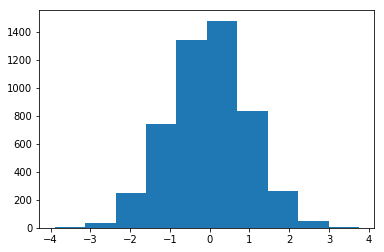

In [63]:
plt.hist(np.ravel(X_train));

20000


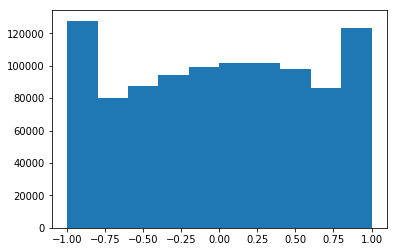

In [64]:
print(len(l_img))
plt.hist(np.ravel(l_img));

In [123]:
len(l_img), max(np.ravel(l_img)), min(np.ravel(l_img))

(20000, 1.0, -1.0000001)

In [125]:
np.ravel(l_img).shape

(1000000,)

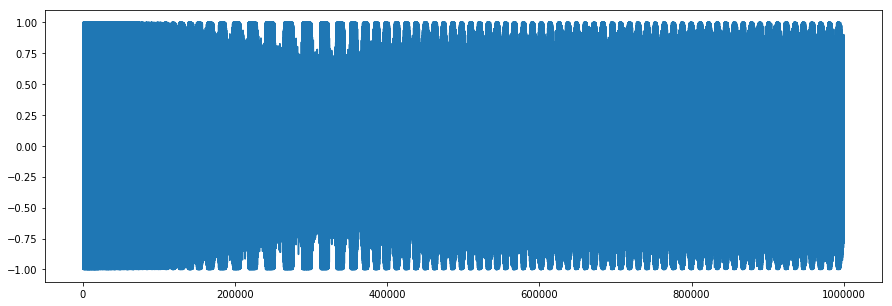

In [129]:
plt.figure(figsize=(15,5))
plt.plot(range(len(np.ravel(l_img))), np.ravel(l_img))